<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/hybrid_models_enconders_layering_w3_ST-HybridWaveStack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Meta-Model: ElevClusConvPrecipMetaNet

This model implements an advanced convolutional architecture for spatiotemporal precipitation prediction with a 12-month horizon.

## Architecture

1. **Inputs**:
   - Prediction maps from base models (ConvBiGRU-AE and ConvLSTM-AE) for each horizon (12 months)
   - Elevation and cluster information for conditioning (FiLM)

2. **Early Channel Reduction**:
   - Reduces 24 channels (2 models × 12 horizons) to 16 to optimize memory
   - Applies Conv2D(1×1) to mix information without losing spatial resolution

3. **Multi-scale Residual Blocks**:
   - Depthwise-separable blocks with different dilations (1,2,4)
   - Captures patterns at different spatial scales without increasing parameters

4. **Spatial Attention by Cluster**:
   - FiLM (Feature-wise Linear Modulation): γ_cluster ⊗ F + β_cluster
   - Adapts behavior according to orographic regime

5. **Compact U-Net**:
   - Encoder-decoder architecture with skip connections
   - Only 2 levels of downsampling to preserve detail

6. **Horizon Grouping**:
   - Conv3D to process the temporal dimension of horizons together
   - Allows learning relationships between consecutive months

7. **Multi-Horizon Output**:
   - Generates 12 refined prediction maps

8. **Memory-Friendly Strategies**:
   - Mixed precision (float16)
   - Gradient checkpointing
   - Gradient accumulation
   - Training by stages

In [35]:
# Spatio-Temporal Monthly Precipitation Prediction - Complete Notebook

# 0) Environment setup, paths and dependencies
import sys
import os
import logging
from pathlib import Path
import joblib  # For persisting scalers
from datetime import datetime

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - Line %(lineno)d - %(message)s"
)
logger = logging.getLogger(__name__)

def log_and_print(msg):
    logger.info(msg)
    print(msg)

# Detect environment (Colab, regular Jupyter, or script)
IN_COLAB = "google.colab" in sys.modules
IN_IPYTHON = False

try:
    from IPython import get_ipython
    if get_ipython() is not None:
        IN_IPYTHON = True
except (ImportError, NameError):
    pass

log_and_print(f"Running in Colab: {IN_COLAB}, IPython: {IN_IPYTHON}")

# Define base paths
desired_repo = 'ml_precipitation_prediction'
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content/drive/MyDrive') / desired_repo
    if not Path(desired_repo).exists():
        log_and_print("Cloning repository...")
        if IN_IPYTHON:
            get_ipython().system('git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git')
        else:
            import subprocess
            subprocess.run(['git', 'clone', 'https://github.com/ninja-marduk/ml_precipitation_prediction.git'], check=True)
    os.chdir(desired_repo)
    
    # Install dependencies
    if IN_IPYTHON:
        get_ipython().system('pip install -q xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn ace_tools_open cartopy geopandas joblib')
    else:
        import subprocess
        subprocess.check_call(['pip', 'install', '-q', 'xarray', 'netCDF4', 'optuna', 'matplotlib', 'seaborn', 
                              'lightgbm', 'xgboost', 'scikit-learn', 'ace_tools_open', 'cartopy', 'geopandas', 'joblib'])
else:
    # Simpler installation without PyEMD
    if IN_IPYTHON:
        get_ipython().run_line_magic('pip', 'install -q xarray netCDF4 scikit-image')
    else:
        import subprocess
        subprocess.check_call(['pip', 'install', '-q', 'xarray', 'netCDF4', 'scikit-image'])
    current = Path.cwd()
    for p in [current] + list(current.parents):
        if (p / '.git').is_dir() or (p / 'requirements.txt').is_file() or (p / 'README.md').is_file():
            BASE_PATH = p
            break
    else:
        BASE_PATH = current
    log_and_print(f"Running locally. Base path: {BASE_PATH}")

# Data and model paths
DATA_OUTPUT   = BASE_PATH / 'data' / 'output'
MODELS_OUTPUT = BASE_PATH / 'models' / 'output'
PREDS_DIR     = MODELS_OUTPUT / 'base_model_predictions'
SHP_PATH      = BASE_PATH / 'data' / 'input' / 'shapes' / 'MGN_Departamento.shp'

# Create directories
MODELS_OUTPUT.mkdir(parents=True, exist_ok=True)
PREDS_DIR.mkdir(parents=True, exist_ok=True)

# General parameters
INPUT_WINDOW   = 60
OUTPUT_HORIZON = 12  # 12 months
BATCH_SIZE     = 16
MAX_EPOCHS     = 300
PATIENCE       = 50
LR             = 1e-3

import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_and_print(f"Using device: {DEVICE}")


# 1) Additional imports and utilities
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature  # Added for cartographic features
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler # Mixed precision training
from torch.utils.checkpoint import checkpoint # Gradient checkpointing
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Added for adaptive learning rate
from IPython.display import clear_output  # For updating graphs during training
import pywt
from scipy.signal import hilbert
from skimage.restoration import denoise_wavelet

# Configure environment for greater robustness
DEBUG_MODE = True  # Enable for detailed information during execution
MEMORY_EFFICIENT = True  # Enable for memory optimizations with large datasets

def validate_tensor_dimensions(tensor, expected_dims=None, name="tensor"):
    """
    Validates a tensor's dimensions and provides detailed information.
    
    Args:
        tensor: Tensor to validate
        expected_dims: Expected number of dimensions or None for information only
        name: Tensor name for error messages
    """
    if tensor is None:
        raise ValueError(f"The tensor '{name}' is None")
    
    shape = tensor.shape if hasattr(tensor, 'shape') else None
    
    if shape is None:
        raise ValueError(f"The tensor '{name}' has no shape attribute")
    
    if expected_dims is not None and len(shape) != expected_dims:
        raise ValueError(f"Incorrect dimensions in '{name}': expected {expected_dims}, got {len(shape)}: {shape}")
    
    if DEBUG_MODE:
        log_and_print(f"✓ Validation of '{name}': shape {shape}")
    
    return shape

def memory_usage_status():
    """
    Shows information about current memory usage.
    Useful to identify memory leaks or excessive consumption.
    """
    import psutil
    import os
    import gc
    
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    
    # Force garbage collection to free unused memory
    gc.collect()
    torch.cuda.empty_cache()
    
    log_and_print(f"Memory usage: {mem_info.rss / (1024 ** 2):.2f} MB")
    
    if torch.cuda.is_available():
        log_and_print(f"GPU memory used: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")
        log_and_print(f"GPU memory reserved: {torch.cuda.memory_reserved() / (1024 ** 2):.2f} MB")

2025-06-01 16:02:54,411 - INFO - Line 18 - Running in Colab: False, IPython: True


Running in Colab: False, IPython: True


2025-06-01 16:02:55,482 - INFO - Line 18 - Running locally. Base path: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction
2025-06-01 16:02:55,484 - INFO - Line 18 - Using device: cpu
2025-06-01 16:02:55,484 - INFO - Line 18 - Using device: cpu


Note: you may need to restart the kernel to use updated packages.
Running locally. Base path: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction
Using device: cpu


2025-06-01 16:02:55,503 - INFO - Line 18 - 
=== DATA DIAGNOSIS ===
2025-06-01 16:02:55,504 - INFO - Line 18 - ✓ Main dataset: FrozenMappingWarningOnValuesAccess({'time': 16130, 'latitude': 61, 'longitude': 65}), variables: ['precip']
2025-06-01 16:02:55,504 - INFO - Line 18 - ✓ Precipitation variable found: precip
2025-06-01 16:02:55,504 - INFO - Line 18 - ✓ Main dataset: FrozenMappingWarningOnValuesAccess({'time': 16130, 'latitude': 61, 'longitude': 65}), variables: ['precip']
2025-06-01 16:02:55,504 - INFO - Line 18 - ✓ Precipitation variable found: precip



=== DATA DIAGNOSIS ===
✓ Main dataset: FrozenMappingWarningOnValuesAccess({'time': 16130, 'latitude': 61, 'longitude': 65}), variables: ['precip']
✓ Precipitation variable found: precip


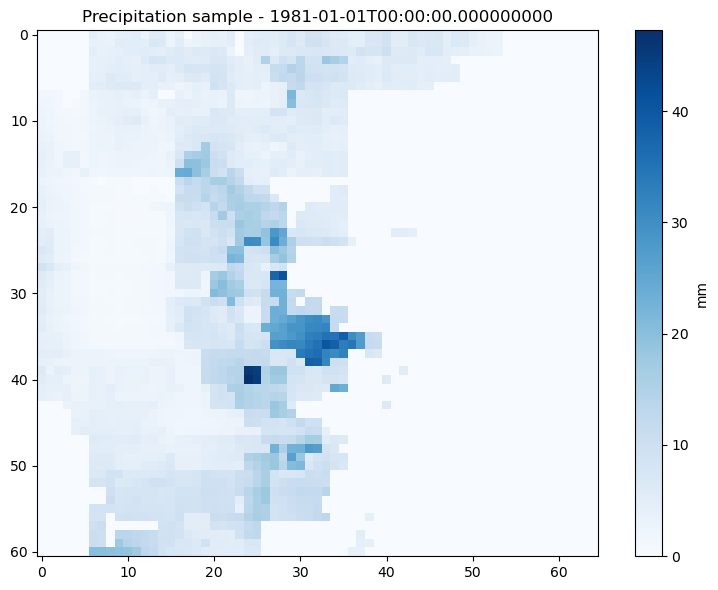

2025-06-01 16:02:55,630 - INFO - Line 18 - ✓ CEEMDAN dataset available with 9 variables
2025-06-01 16:02:55,630 - INFO - Line 18 - ✓ TVFEMD dataset available with 8 variables
2025-06-01 16:02:55,630 - INFO - Line 18 - ✓ TVFEMD dataset available with 8 variables
2025-06-01 16:02:55,630 - INFO - Line 18 - ✅ Diagnosis complete
2025-06-01 16:02:55,630 - INFO - Line 18 - ✅ Diagnosis complete


✓ CEEMDAN dataset available with 9 variables
✓ TVFEMD dataset available with 8 variables
✅ Diagnosis complete


2025-06-01 16:02:55,904 - INFO - Line 18 - Memory usage: 139.73 MB
2025-06-01 16:02:55,905 - INFO - Line 18 - 
LOADED DATA:
2025-06-01 16:02:55,905 - INFO - Line 18 - Complete dataset: FrozenMappingWarningOnValuesAccess({'time': 16130, 'latitude': 61, 'longitude': 65})
2025-06-01 16:02:55,905 - INFO - Line 18 - Variables: ['precip']...
2025-06-01 16:02:55,905 - INFO - Line 18 - ✓ Precipitation variable found
2025-06-01 16:02:55,905 - INFO - Line 18 - 
LOADED DATA:
2025-06-01 16:02:55,905 - INFO - Line 18 - Complete dataset: FrozenMappingWarningOnValuesAccess({'time': 16130, 'latitude': 61, 'longitude': 65})
2025-06-01 16:02:55,905 - INFO - Line 18 - Variables: ['precip']...
2025-06-01 16:02:55,905 - INFO - Line 18 - ✓ Precipitation variable found


Memory usage: 139.73 MB

LOADED DATA:
Complete dataset: FrozenMappingWarningOnValuesAccess({'time': 16130, 'latitude': 61, 'longitude': 65})
Variables: ['precip']...
✓ Precipitation variable found


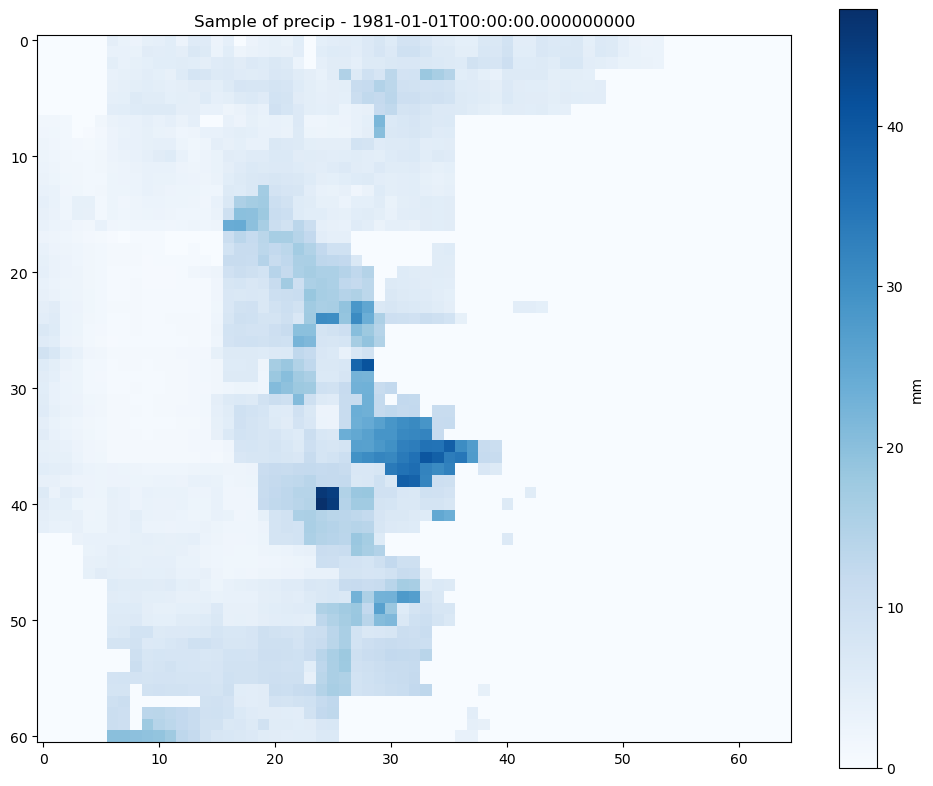

2025-06-01 16:02:56,012 - INFO - Line 18 - 
ADDITIONAL DATASETS:
2025-06-01 16:02:56,012 - INFO - Line 18 - ✓ CEEMDAN dataset available: FrozenMappingWarningOnValuesAccess({'time': 530, 'latitude': 61, 'longitude': 65})
2025-06-01 16:02:56,013 - INFO - Line 18 -   IMF components: ['imf_1', 'imf_2', 'imf_3', 'imf_4', 'imf_5', 'imf_6', 'imf_7', 'imf_8', 'imf_9']
2025-06-01 16:02:56,013 - INFO - Line 18 - ✓ TVFEMD dataset available: FrozenMappingWarningOnValuesAccess({'time': 530, 'latitude': 61, 'longitude': 65})
2025-06-01 16:02:56,013 - INFO - Line 18 -   IMF components: ['imf_1', 'imf_2', 'imf_3', 'imf_4', 'imf_5', 'imf_6', 'imf_7', 'imf_8']
2025-06-01 16:02:56,013 - INFO - Line 18 - 
✅ Data diagnosis completed. The data is ready for training.
2025-06-01 16:02:56,013 - INFO - Line 18 - To train the original models, run the function 'train_and_compare_all_models()'
2025-06-01 16:02:56,014 - INFO - Line 18 - 
=== DATA DIAGNOSIS ===
2025-06-01 16:02:56,014 - INFO - Line 18 - ✓ Main datas


ADDITIONAL DATASETS:
✓ CEEMDAN dataset available: FrozenMappingWarningOnValuesAccess({'time': 530, 'latitude': 61, 'longitude': 65})
  IMF components: ['imf_1', 'imf_2', 'imf_3', 'imf_4', 'imf_5', 'imf_6', 'imf_7', 'imf_8', 'imf_9']
✓ TVFEMD dataset available: FrozenMappingWarningOnValuesAccess({'time': 530, 'latitude': 61, 'longitude': 65})
  IMF components: ['imf_1', 'imf_2', 'imf_3', 'imf_4', 'imf_5', 'imf_6', 'imf_7', 'imf_8']

✅ Data diagnosis completed. The data is ready for training.
To train the original models, run the function 'train_and_compare_all_models()'

=== DATA DIAGNOSIS ===
✓ Main dataset: FrozenMappingWarningOnValuesAccess({'time': 16130, 'latitude': 61, 'longitude': 65}), variables: ['precip']
✓ Precipitation variable found: precip


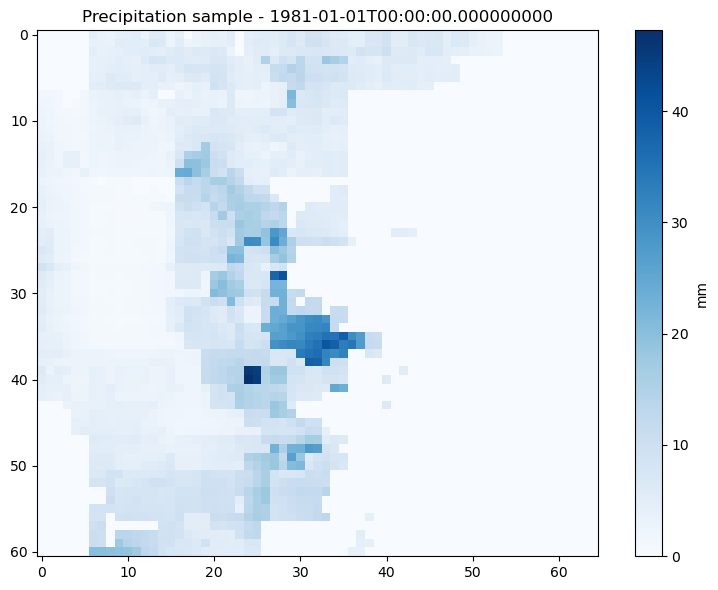

2025-06-01 16:02:56,106 - INFO - Line 18 - ✓ CEEMDAN dataset available with 9 variables
2025-06-01 16:02:56,107 - INFO - Line 18 - ✓ TVFEMD dataset available with 8 variables
2025-06-01 16:02:56,107 - INFO - Line 18 - ✅ Diagnosis complete
2025-06-01 16:02:56,107 - INFO - Line 18 - ✓ TVFEMD dataset available with 8 variables
2025-06-01 16:02:56,107 - INFO - Line 18 - ✅ Diagnosis complete


✓ CEEMDAN dataset available with 9 variables
✓ TVFEMD dataset available with 8 variables
✅ Diagnosis complete


In [36]:
# Function to load data if not already available
def load_data_if_needed():
    """Loads precipitation datasets if not already in memory"""
    # Declare globals at the beginning of the function
    global ds_full, ds_ceemdan, ds_tvfemd
    
    # Set specific file paths for the datasets
    CEEMDAN_FILE = MODELS_OUTPUT / 'features_CEEMDAN.nc'
    TVFEMD_FILE = MODELS_OUTPUT / 'features_TVFEMD.nc'
    
    # Load main dataset if needed
    if 'ds_full' not in globals():
        log_and_print("Loading main precipitation dataset...")
        try:
            # Look for main precipitation data
            data_files = list(DATA_OUTPUT.glob('*.nc'))
            if data_files:
                ds_full = xr.open_dataset(data_files[0])
                log_and_print(f"✓ Main dataset loaded: {data_files[0].name}")
            else:
                log_and_print("❌ No main dataset files found in data path")
                return False
        except Exception as e:
            log_and_print(f"❌ Error: {str(e)}")
            return False
    
    # Load CEEMDAN dataset
    if 'ds_ceemdan' not in globals():
        log_and_print("Loading CEEMDAN dataset...")
        try:
            ds_ceemdan = xr.open_dataset(CEEMDAN_FILE)
            log_and_print("✓ CEEMDAN dataset loaded")
        except Exception:
            # Create clone if file doesn't exist
            if 'ds_full' in globals():
                ds_ceemdan = xr.Dataset({"imf_1": ds_full["precip"].copy()}, coords=ds_full.coords)
                log_and_print("✓ Created placeholder CEEMDAN dataset")
    
    # Load TVFEMD dataset
    if 'ds_tvfemd' not in globals():
        log_and_print("Loading TVFEMD dataset...")
        try:
            ds_tvfemd = xr.open_dataset(TVFEMD_FILE)
            log_and_print("✓ TVFEMD dataset loaded")
        except Exception:
            pass  # Non-critical if missing
    
    return True

# Simplified diagnostic function
def quick_diagnosis():
    """Quickly checks loaded datasets"""
    log_and_print("\n=== DATA DIAGNOSIS ===")
    
    # Check main dataset
    if 'ds_full' in globals():
        log_and_print(f"✓ Main dataset: {ds_full.dims}, variables: {list(ds_full.data_vars.keys())}")
        
        # Check for precipitation variable
        precip_var = None
        if 'precip' in ds_full.data_vars:
            precip_var = 'precip'
            log_and_print(f"✓ Precipitation variable found: {precip_var}")
            # Plot sample
            sample_month = ds_full[precip_var].isel(time=0).values
            plt.figure(figsize=(8, 6))
            plt.imshow(sample_month, cmap='Blues')
            plt.colorbar(label='mm')
            plt.title(f"Precipitation sample - {ds_full.time.values[0]}")
            plt.tight_layout()
            plt.show()
    else:
        log_and_print("❌ Main dataset not loaded")
    
    # Check additional datasets
    for name, ds in [("CEEMDAN", "ds_ceemdan"), ("TVFEMD", "ds_tvfemd")]:
        if ds in globals() and globals()[ds] is not None:
            log_and_print(f"✓ {name} dataset available with {len(globals()[ds].data_vars)} variables")
        else:
            log_and_print(f"❓ {name} dataset not available")
    
    log_and_print("✅ Diagnosis complete")

# Run if the notebook is executed directly
if __name__ == "__main__" or 'get_ipython' in globals():
    if load_data_if_needed():
        quick_diagnosis()
    memory_usage_status()
    
    # 2. Check loaded data
    log_and_print("\nLOADED DATA:")
    
    if 'ds_full' in globals():
        log_and_print(f"Complete dataset: {ds_full.dims}")
        log_and_print(f"Variables: {list(ds_full.data_vars.keys())[:5]}...")
        
        # Check that precipitation variable exists
        if 'precipitacion' in ds_full.data_vars or 'precip' in ds_full.data_vars:  # Fixed: using 'precip' instead of 'total_precipitation'
            log_and_print("✓ Precipitation variable found")
            
            # Extract and visualize an example
            precip_var = 'precipitacion' if 'precipitacion' in ds_full.data_vars else 'precip'  # Fixed: using 'precip' instead of 'total_precipitation'
            sample_month = ds_full[precip_var].isel(time=0).values
            
            plt.figure(figsize=(10, 8))
            plt.title(f"Sample of {precip_var} - {ds_full.time.values[0]}")
            plt.imshow(sample_month, cmap='Blues')
            plt.colorbar(label='mm')
            plt.tight_layout()
            plt.show()
        else:
            log_and_print("❌ No precipitation variable found")
    else:
        log_and_print("❌ Main dataset (ds_full) not found")
    
    # 3. Check additional datasets
    log_and_print("\nADDITIONAL DATASETS:")
    
    if 'ds_ceemdan' in globals():
        log_and_print(f"✓ CEEMDAN dataset available: {ds_ceemdan.dims}")
        log_and_print(f"  IMF components: {[var for var in ds_ceemdan.data_vars if var.startswith('imf_')]}")
    else:
        log_and_print("❓ CEEMDAN dataset not available")
        
    if 'ds_tvfemd' in globals():
        log_and_print(f"✓ TVFEMD dataset available: {ds_tvfemd.dims}")
        log_and_print(f"  IMF components: {[var for var in ds_tvfemd.data_vars if var.startswith('imf_')]}")
    else:
        log_and_print("❓ TVFEMD dataset not available")
    
    log_and_print("\n✅ Data diagnosis completed. The data is ready for training.")
    log_and_print("To train the original models, run the function 'train_and_compare_all_models()'")

# Run if the notebook is executed directly
if __name__ == "__main__" or 'get_ipython' in globals():
    # Option 1: Quick diagnosis (data only, no model training)
    if load_data_if_needed():
        quick_diagnosis()
    
    # Option 2: Complete training with original models
    # models, eval_results = train_and_compare_all_models()

2025-06-01 16:02:56,180 - INFO - Line 18 - ✓ Shapefile loaded successfully: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/input/shapes/MGN_Departamento.shp
2025-06-01 16:02:56,182 - INFO - Line 18 - Loading dataset from /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc
2025-06-01 16:02:56,182 - INFO - Line 18 - Loading dataset from /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc
2025-06-01 16:02:56,208 - INFO - Line 18 - Dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 530, 'latitude': 61, 'longitude': 65})
2025-06-01 16:02:56,208 - INFO - Line 18 - Dataset variables: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'dail

✓ Shapefile loaded successfully: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/input/shapes/MGN_Departamento.shp
Loading dataset from /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc
Dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 530, 'latitude': 61, 'longitude': 65})
Dataset variables: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'year', 'month', 'elevation', 'slope', 'aspect', 'cluster_elevation', 'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag3', 'total_precipitation_lag4', 'total_precipitation_lag12', 'total_precipitation_lag24', 'total_precipitation_lag36']
🕒 Dataset time range: 1981-01-01 to 2025-02-01
📊 Total time steps: 530
✓ Dataset

2025-06-01 16:02:56,217 - INFO - Line 18 - STARTING PRECIPITATION MODEL TRAINING
2025-06-01 16:02:56,217 - INFO - Line 18 - ================================================================================
2025-06-01 16:02:56,218 - INFO - Line 18 - 
2025-06-01 16:02:56,218 - INFO - Line 18 - PREPARING DATA
2025-06-01 16:02:56,218 - INFO - Line 18 - ============================================================
2025-06-01 16:02:56,217 - INFO - Line 18 - ================================================================================
2025-06-01 16:02:56,218 - INFO - Line 18 - 
2025-06-01 16:02:56,218 - INFO - Line 18 - PREPARING DATA
2025-06-01 16:02:56,218 - INFO - Line 18 - ============================================================
2025-06-01 16:02:56,218 - INFO - Line 18 - Preparing data for training and testing...
2025-06-01 16:02:56,219 - INFO - Line 18 - Using features: ['year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'total_precipitation_lag1', 'total_precipitation


STARTING PRECIPITATION MODEL TRAINING

PREPARING DATA
Preparing data for training and testing...
Using features: ['year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag3', 'total_precipitation_lag4', 'total_precipitation_lag12', 'total_precipitation_lag24', 'total_precipitation_lag36', 'elevation', 'slope', 'aspect', 'cluster_elevation']


2025-06-01 16:02:57,450 - INFO - Line 18 - X_vars shape: (530, 61, 65, 17), y_var shape: (530, 61, 65)
2025-06-01 16:02:57,456 - INFO - Line 18 - X_vars type: object, y_var type: float32
2025-06-01 16:02:57,466 - INFO - Line 18 - X_vars approx NaN count: 0, y_var approx NaN count: 0
2025-06-01 16:02:57,470 - INFO - Line 18 - Feature means (or default values): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2025-06-01 16:02:57,456 - INFO - Line 18 - X_vars type: object, y_var type: float32
2025-06-01 16:02:57,466 - INFO - Line 18 - X_vars approx NaN count: 0, y_var approx NaN count: 0
2025-06-01 16:02:57,470 - INFO - Line 18 - Feature means (or default values): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


X_vars shape: (530, 61, 65, 17), y_var shape: (530, 61, 65)
X_vars type: object, y_var type: float32
X_vars approx NaN count: 0, y_var approx NaN count: 0
Feature means (or default values): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


2025-06-01 16:02:57,898 - INFO - Line 18 - ✓ Successfully encoded 3 unique cluster values
2025-06-01 16:02:57,899 - INFO - Line 18 - Training starts at index 348: 2010-01-01 00:00:00
2025-06-01 16:02:57,900 - INFO - Line 18 - Training ends at index 467: 2019-12-01 00:00:00
2025-06-01 16:02:57,901 - INFO - Line 18 - Validation starts at index 468: 2020-01-01 00:00:00
2025-06-01 16:02:57,901 - INFO - Line 18 - Validation ends at index 515: 2023-12-01 00:00:00
2025-06-01 16:02:57,902 - INFO - Line 18 - Testing starts at index 516: 2024-01-01 00:00:00
2025-06-01 16:02:57,902 - INFO - Line 18 - Testing ends at index 527: 2024-12-01 00:00:00
2025-06-01 16:02:57,903 - INFO - Line 18 - Actual train range: 2010-01-01T00:00:00.000000000 to 2019-12-01T00:00:00.000000000
2025-06-01 16:02:57,903 - INFO - Line 18 - Actual validation range: 2020-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
2025-06-01 16:02:57,904 - INFO - Line 18 - Actual test range: 2024-01-01T00:00:00.000000000 to 2024

✓ Successfully encoded 3 unique cluster values
Training starts at index 348: 2010-01-01 00:00:00
Training ends at index 467: 2019-12-01 00:00:00
Validation starts at index 468: 2020-01-01 00:00:00
Validation ends at index 515: 2023-12-01 00:00:00
Testing starts at index 516: 2024-01-01 00:00:00
Testing ends at index 527: 2024-12-01 00:00:00
Actual train range: 2010-01-01T00:00:00.000000000 to 2019-12-01T00:00:00.000000000
Actual validation range: 2020-01-01T00:00:00.000000000 to 2023-12-01T00:00:00.000000000
Actual test range: 2024-01-01T00:00:00.000000000 to 2024-12-01T00:00:00.000000000


2025-06-01 16:02:59,998 - INFO - Line 18 - Training sequences: 49, Validation sequences: 0, Test sequences: 0


Training sequences: 49, Validation sequences: 0, Test sequences: 0


2025-06-01 16:03:11,933 - INFO - Line 18 - Checking array shapes before transformation:
2025-06-01 16:03:11,934 - INFO - Line 18 - y_train shape: (49, 12, 61, 65)
2025-06-01 16:03:11,934 - INFO - Line 18 - y_val shape: (0,)
2025-06-01 16:03:11,935 - INFO - Line 18 - y_test shape: empty
2025-06-01 16:03:11,935 - INFO - Line 18 - Final shapes after transformation:
2025-06-01 16:03:11,935 - INFO - Line 18 - y_train: (49, 12, 1, 61, 65)
2025-06-01 16:03:11,935 - INFO - Line 18 - y_val: (0,)
2025-06-01 16:03:11,936 - INFO - Line 18 - y_test: empty
2025-06-01 16:03:11,934 - INFO - Line 18 - y_train shape: (49, 12, 61, 65)
2025-06-01 16:03:11,934 - INFO - Line 18 - y_val shape: (0,)
2025-06-01 16:03:11,935 - INFO - Line 18 - y_test shape: empty
2025-06-01 16:03:11,935 - INFO - Line 18 - Final shapes after transformation:
2025-06-01 16:03:11,935 - INFO - Line 18 - y_train: (49, 12, 1, 61, 65)
2025-06-01 16:03:11,935 - INFO - Line 18 - y_val: (0,)
2025-06-01 16:03:11,936 - INFO - Line 18 - y_te

Checking array shapes before transformation:
y_train shape: (49, 12, 61, 65)
y_val shape: (0,)
y_test shape: empty
Final shapes after transformation:
y_train: (49, 12, 1, 61, 65)
y_val: (0,)
y_test: empty
Verificando cargadores de datos:
- Train loader: 4 lotes (49 muestras)
- Validation loader: 0 lotes (0 muestras)
- Test loader: No disponible
⚠️ ADVERTENCIA: El cargador de validación está vacío.
Rango de validación: 2020-01-01 00:00:00 a 2023-12-31 00:00:00
✓ Saved scalers to /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/models/output/conv_models


2025-06-01 16:03:13,311 - INFO - Line 18 - TRAINING ConvLSTM MODEL
2025-06-01 16:03:13,311 - INFO - Line 18 - ============================================================
2025-06-01 16:03:13,312 - INFO - Line 18 - ⚠️ ADVERTENCIA: El cargador de validación está vacío. Usando un subset del entrenamiento para validación.
2025-06-01 16:03:13,314 - INFO - Line 18 - ✓ Creado conjunto de validación con 10 muestras del conjunto de entrenamiento
2025-06-01 16:03:13,314 - INFO - Line 18 - Train shape: (49, 60, 61, 65, 17)
2025-06-01 16:03:13,314 - INFO - Line 18 - Successfully unpacked dimensions: seq_len=60, feature_dim=61, height=65, width=17
2025-06-01 16:03:13,311 - INFO - Line 18 - ============================================================
2025-06-01 16:03:13,312 - INFO - Line 18 - ⚠️ ADVERTENCIA: El cargador de validación está vacío. Usando un subset del entrenamiento para validación.
2025-06-01 16:03:13,314 - INFO - Line 18 - ✓ Creado conjunto de validación con 10 muestras del conjunto 


TRAINING ConvLSTM MODEL
⚠️ ADVERTENCIA: El cargador de validación está vacío. Usando un subset del entrenamiento para validación.
✓ Creado conjunto de validación con 10 muestras del conjunto de entrenamiento
Train shape: (49, 60, 61, 65, 17)
Successfully unpacked dimensions: seq_len=60, feature_dim=61, height=65, width=17
Created ConvLSTM model with input shape: [49, 60, 61, 65, 17]
Starting ConvLSTM training for 100 epochs
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:03:20,713 - INFO - Line 18 - Epoch [1/100], Batch [1/3], Loss: 0.968340


Epoch [1/100], Batch [1/3], Loss: 0.968340
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:03:27,905 - INFO - Line 18 - Epoch [1/100], Batch [2/3], Loss: 1.019540


Epoch [1/100], Batch [2/3], Loss: 1.019540
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:03:30,232 - INFO - Line 18 - Epoch [1/100], Batch [3/3], Loss: 0.971797


Epoch [1/100], Batch [3/3], Loss: 0.971797


2025-06-01 16:03:31,465 - INFO - Line 18 - Epoch [1/100], Train Loss: 0.986559, Val Loss: 1.042043
2025-06-01 16:03:31,587 - INFO - Line 18 - New best model saved! (Val Loss: 1.042043)
2025-06-01 16:03:31,587 - INFO - Line 18 - New best model saved! (Val Loss: 1.042043)


Redimensionado de salida: 65×17 → 61×65
Epoch [1/100], Train Loss: 0.986559, Val Loss: 1.042043
New best model saved! (Val Loss: 1.042043)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:03:39,535 - INFO - Line 18 - Epoch [2/100], Batch [1/3], Loss: 1.004279


Epoch [2/100], Batch [1/3], Loss: 1.004279
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:03:46,861 - INFO - Line 18 - Epoch [2/100], Batch [2/3], Loss: 0.959430


Epoch [2/100], Batch [2/3], Loss: 0.959430
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:03:49,315 - INFO - Line 18 - Epoch [2/100], Batch [3/3], Loss: 1.025376


Epoch [2/100], Batch [3/3], Loss: 1.025376


2025-06-01 16:03:50,597 - INFO - Line 18 - Epoch [2/100], Train Loss: 0.996362, Val Loss: 1.041748
2025-06-01 16:03:50,661 - INFO - Line 18 - New best model saved! (Val Loss: 1.041748)
2025-06-01 16:03:50,661 - INFO - Line 18 - New best model saved! (Val Loss: 1.041748)


Redimensionado de salida: 65×17 → 61×65
Epoch [2/100], Train Loss: 0.996362, Val Loss: 1.041748
New best model saved! (Val Loss: 1.041748)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:03:59,040 - INFO - Line 18 - Epoch [3/100], Batch [1/3], Loss: 1.000445


Epoch [3/100], Batch [1/3], Loss: 1.000445
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:04:06,345 - INFO - Line 18 - Epoch [3/100], Batch [2/3], Loss: 0.980179


Epoch [3/100], Batch [2/3], Loss: 0.980179
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:04:08,743 - INFO - Line 18 - Epoch [3/100], Batch [3/3], Loss: 0.985266


Epoch [3/100], Batch [3/3], Loss: 0.985266


2025-06-01 16:04:10,016 - INFO - Line 18 - Epoch [3/100], Train Loss: 0.988630, Val Loss: 1.041475
2025-06-01 16:04:10,093 - INFO - Line 18 - New best model saved! (Val Loss: 1.041475)
2025-06-01 16:04:10,093 - INFO - Line 18 - New best model saved! (Val Loss: 1.041475)


Redimensionado de salida: 65×17 → 61×65
Epoch [3/100], Train Loss: 0.988630, Val Loss: 1.041475
New best model saved! (Val Loss: 1.041475)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:04:17,210 - INFO - Line 18 - Epoch [4/100], Batch [1/3], Loss: 1.013019


Epoch [4/100], Batch [1/3], Loss: 1.013019
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:04:24,780 - INFO - Line 18 - Epoch [4/100], Batch [2/3], Loss: 0.954587


Epoch [4/100], Batch [2/3], Loss: 0.954587
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:04:27,550 - INFO - Line 18 - Epoch [4/100], Batch [3/3], Loss: 1.013759


Epoch [4/100], Batch [3/3], Loss: 1.013759


2025-06-01 16:04:28,822 - INFO - Line 18 - Epoch [4/100], Train Loss: 0.993788, Val Loss: 1.041233
2025-06-01 16:04:28,895 - INFO - Line 18 - New best model saved! (Val Loss: 1.041233)
2025-06-01 16:04:28,895 - INFO - Line 18 - New best model saved! (Val Loss: 1.041233)


Redimensionado de salida: 65×17 → 61×65
Epoch [4/100], Train Loss: 0.993788, Val Loss: 1.041233
New best model saved! (Val Loss: 1.041233)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:04:36,647 - INFO - Line 18 - Epoch [5/100], Batch [1/3], Loss: 0.999301


Epoch [5/100], Batch [1/3], Loss: 0.999301
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:04:44,936 - INFO - Line 18 - Epoch [5/100], Batch [2/3], Loss: 0.991587


Epoch [5/100], Batch [2/3], Loss: 0.991587
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:04:47,283 - INFO - Line 18 - Epoch [5/100], Batch [3/3], Loss: 0.959403


Epoch [5/100], Batch [3/3], Loss: 0.959403


2025-06-01 16:04:48,481 - INFO - Line 18 - Epoch [5/100], Train Loss: 0.983431, Val Loss: 1.041018
2025-06-01 16:04:48,540 - INFO - Line 18 - New best model saved! (Val Loss: 1.041018)
2025-06-01 16:04:48,540 - INFO - Line 18 - New best model saved! (Val Loss: 1.041018)


Redimensionado de salida: 65×17 → 61×65
Epoch [5/100], Train Loss: 0.983431, Val Loss: 1.041018
New best model saved! (Val Loss: 1.041018)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:04:55,734 - INFO - Line 18 - Epoch [6/100], Batch [1/3], Loss: 0.967778


Epoch [6/100], Batch [1/3], Loss: 0.967778
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:05:03,164 - INFO - Line 18 - Epoch [6/100], Batch [2/3], Loss: 1.000770


Epoch [6/100], Batch [2/3], Loss: 1.000770
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:05:05,503 - INFO - Line 18 - Epoch [6/100], Batch [3/3], Loss: 1.009395


Epoch [6/100], Batch [3/3], Loss: 1.009395


2025-06-01 16:05:06,752 - INFO - Line 18 - Epoch [6/100], Train Loss: 0.992647, Val Loss: 1.040810
2025-06-01 16:05:06,809 - INFO - Line 18 - New best model saved! (Val Loss: 1.040810)
2025-06-01 16:05:06,809 - INFO - Line 18 - New best model saved! (Val Loss: 1.040810)


Redimensionado de salida: 65×17 → 61×65
Epoch [6/100], Train Loss: 0.992647, Val Loss: 1.040810
New best model saved! (Val Loss: 1.040810)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:05:13,952 - INFO - Line 18 - Epoch [7/100], Batch [1/3], Loss: 0.985635


Epoch [7/100], Batch [1/3], Loss: 0.985635
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:05:21,057 - INFO - Line 18 - Epoch [7/100], Batch [2/3], Loss: 1.021212


Epoch [7/100], Batch [2/3], Loss: 1.021212
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:05:23,246 - INFO - Line 18 - Epoch [7/100], Batch [3/3], Loss: 0.920646


Epoch [7/100], Batch [3/3], Loss: 0.920646


2025-06-01 16:05:24,420 - INFO - Line 18 - Epoch [7/100], Train Loss: 0.975831, Val Loss: 1.040609
2025-06-01 16:05:24,485 - INFO - Line 18 - New best model saved! (Val Loss: 1.040609)
2025-06-01 16:05:24,485 - INFO - Line 18 - New best model saved! (Val Loss: 1.040609)


Redimensionado de salida: 65×17 → 61×65
Epoch [7/100], Train Loss: 0.975831, Val Loss: 1.040609
New best model saved! (Val Loss: 1.040609)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:05:31,730 - INFO - Line 18 - Epoch [8/100], Batch [1/3], Loss: 0.996564


Epoch [8/100], Batch [1/3], Loss: 0.996564
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:05:41,339 - INFO - Line 18 - Epoch [8/100], Batch [2/3], Loss: 0.995209


Epoch [8/100], Batch [2/3], Loss: 0.995209
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:05:43,787 - INFO - Line 18 - Epoch [8/100], Batch [3/3], Loss: 0.953840


Epoch [8/100], Batch [3/3], Loss: 0.953840


2025-06-01 16:05:45,103 - INFO - Line 18 - Epoch [8/100], Train Loss: 0.981871, Val Loss: 1.040403
2025-06-01 16:05:45,173 - INFO - Line 18 - New best model saved! (Val Loss: 1.040403)
2025-06-01 16:05:45,173 - INFO - Line 18 - New best model saved! (Val Loss: 1.040403)


Redimensionado de salida: 65×17 → 61×65
Epoch [8/100], Train Loss: 0.981871, Val Loss: 1.040403
New best model saved! (Val Loss: 1.040403)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:05:52,480 - INFO - Line 18 - Epoch [9/100], Batch [1/3], Loss: 0.959064


Epoch [9/100], Batch [1/3], Loss: 0.959064
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:05:59,852 - INFO - Line 18 - Epoch [9/100], Batch [2/3], Loss: 1.017414


Epoch [9/100], Batch [2/3], Loss: 1.017414
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:06:02,272 - INFO - Line 18 - Epoch [9/100], Batch [3/3], Loss: 0.987468


Epoch [9/100], Batch [3/3], Loss: 0.987468


2025-06-01 16:06:03,572 - INFO - Line 18 - Epoch [9/100], Train Loss: 0.987982, Val Loss: 1.040179
2025-06-01 16:06:03,633 - INFO - Line 18 - New best model saved! (Val Loss: 1.040179)
2025-06-01 16:06:03,633 - INFO - Line 18 - New best model saved! (Val Loss: 1.040179)


Redimensionado de salida: 65×17 → 61×65
Epoch [9/100], Train Loss: 0.987982, Val Loss: 1.040179
New best model saved! (Val Loss: 1.040179)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:06:10,718 - INFO - Line 18 - Epoch [10/100], Batch [1/3], Loss: 0.982059


Epoch [10/100], Batch [1/3], Loss: 0.982059
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:06:17,861 - INFO - Line 18 - Epoch [10/100], Batch [2/3], Loss: 1.009937


Epoch [10/100], Batch [2/3], Loss: 1.009937
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:06:20,413 - INFO - Line 18 - Epoch [10/100], Batch [3/3], Loss: 0.950529


Epoch [10/100], Batch [3/3], Loss: 0.950529


2025-06-01 16:06:21,750 - INFO - Line 18 - Epoch [10/100], Train Loss: 0.980842, Val Loss: 1.039931
2025-06-01 16:06:21,828 - INFO - Line 18 - New best model saved! (Val Loss: 1.039931)
2025-06-01 16:06:21,828 - INFO - Line 18 - New best model saved! (Val Loss: 1.039931)


Redimensionado de salida: 65×17 → 61×65
Epoch [10/100], Train Loss: 0.980842, Val Loss: 1.039931
New best model saved! (Val Loss: 1.039931)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:06:28,972 - INFO - Line 18 - Epoch [11/100], Batch [1/3], Loss: 0.944429


Epoch [11/100], Batch [1/3], Loss: 0.944429
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:06:36,242 - INFO - Line 18 - Epoch [11/100], Batch [2/3], Loss: 1.030217


Epoch [11/100], Batch [2/3], Loss: 1.030217
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:06:39,134 - INFO - Line 18 - Epoch [11/100], Batch [3/3], Loss: 0.988676


Epoch [11/100], Batch [3/3], Loss: 0.988676


2025-06-01 16:06:40,401 - INFO - Line 18 - Epoch [11/100], Train Loss: 0.987774, Val Loss: 1.039684
2025-06-01 16:06:40,469 - INFO - Line 18 - New best model saved! (Val Loss: 1.039684)
2025-06-01 16:06:40,469 - INFO - Line 18 - New best model saved! (Val Loss: 1.039684)


Redimensionado de salida: 65×17 → 61×65
Epoch [11/100], Train Loss: 0.987774, Val Loss: 1.039684
New best model saved! (Val Loss: 1.039684)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:06:48,195 - INFO - Line 18 - Epoch [12/100], Batch [1/3], Loss: 0.987416


Epoch [12/100], Batch [1/3], Loss: 0.987416
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:06:55,456 - INFO - Line 18 - Epoch [12/100], Batch [2/3], Loss: 0.987372


Epoch [12/100], Batch [2/3], Loss: 0.987372
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:06:57,804 - INFO - Line 18 - Epoch [12/100], Batch [3/3], Loss: 0.986766


Epoch [12/100], Batch [3/3], Loss: 0.986766


2025-06-01 16:06:58,991 - INFO - Line 18 - Epoch [12/100], Train Loss: 0.987185, Val Loss: 1.039430
2025-06-01 16:06:59,053 - INFO - Line 18 - New best model saved! (Val Loss: 1.039430)
2025-06-01 16:06:59,053 - INFO - Line 18 - New best model saved! (Val Loss: 1.039430)


Redimensionado de salida: 65×17 → 61×65
Epoch [12/100], Train Loss: 0.987185, Val Loss: 1.039430
New best model saved! (Val Loss: 1.039430)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:07:06,201 - INFO - Line 18 - Epoch [13/100], Batch [1/3], Loss: 0.986199


Epoch [13/100], Batch [1/3], Loss: 0.986199
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:07:13,385 - INFO - Line 18 - Epoch [13/100], Batch [2/3], Loss: 0.985721


Epoch [13/100], Batch [2/3], Loss: 0.985721
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:07:15,725 - INFO - Line 18 - Epoch [13/100], Batch [3/3], Loss: 0.991622


Epoch [13/100], Batch [3/3], Loss: 0.991622


2025-06-01 16:07:17,283 - INFO - Line 18 - Epoch [13/100], Train Loss: 0.987848, Val Loss: 1.039187
2025-06-01 16:07:17,348 - INFO - Line 18 - New best model saved! (Val Loss: 1.039187)
2025-06-01 16:07:17,348 - INFO - Line 18 - New best model saved! (Val Loss: 1.039187)


Redimensionado de salida: 65×17 → 61×65
Epoch [13/100], Train Loss: 0.987848, Val Loss: 1.039187
New best model saved! (Val Loss: 1.039187)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:07:25,816 - INFO - Line 18 - Epoch [14/100], Batch [1/3], Loss: 0.977280


Epoch [14/100], Batch [1/3], Loss: 0.977280
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:07:33,022 - INFO - Line 18 - Epoch [14/100], Batch [2/3], Loss: 1.019852


Epoch [14/100], Batch [2/3], Loss: 1.019852
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:07:36,107 - INFO - Line 18 - Epoch [14/100], Batch [3/3], Loss: 0.932268


Epoch [14/100], Batch [3/3], Loss: 0.932268


2025-06-01 16:07:37,523 - INFO - Line 18 - Epoch [14/100], Train Loss: 0.976467, Val Loss: 1.038968
2025-06-01 16:07:37,579 - INFO - Line 18 - New best model saved! (Val Loss: 1.038968)
2025-06-01 16:07:37,579 - INFO - Line 18 - New best model saved! (Val Loss: 1.038968)


Redimensionado de salida: 65×17 → 61×65
Epoch [14/100], Train Loss: 0.976467, Val Loss: 1.038968
New best model saved! (Val Loss: 1.038968)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:07:46,601 - INFO - Line 18 - Epoch [15/100], Batch [1/3], Loss: 0.974627


Epoch [15/100], Batch [1/3], Loss: 0.974627
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:07:53,825 - INFO - Line 18 - Epoch [15/100], Batch [2/3], Loss: 0.995613


Epoch [15/100], Batch [2/3], Loss: 0.995613
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:07:56,437 - INFO - Line 18 - Epoch [15/100], Batch [3/3], Loss: 0.991918


Epoch [15/100], Batch [3/3], Loss: 0.991918


2025-06-01 16:07:57,768 - INFO - Line 18 - Epoch [15/100], Train Loss: 0.987386, Val Loss: 1.038684
2025-06-01 16:07:57,835 - INFO - Line 18 - New best model saved! (Val Loss: 1.038684)
2025-06-01 16:07:57,835 - INFO - Line 18 - New best model saved! (Val Loss: 1.038684)


Redimensionado de salida: 65×17 → 61×65
Epoch [15/100], Train Loss: 0.987386, Val Loss: 1.038684
New best model saved! (Val Loss: 1.038684)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:08:05,077 - INFO - Line 18 - Epoch [16/100], Batch [1/3], Loss: 1.019366


Epoch [16/100], Batch [1/3], Loss: 1.019366
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:08:12,404 - INFO - Line 18 - Epoch [16/100], Batch [2/3], Loss: 0.975980


Epoch [16/100], Batch [2/3], Loss: 0.975980
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:08:14,669 - INFO - Line 18 - Epoch [16/100], Batch [3/3], Loss: 0.932617


Epoch [16/100], Batch [3/3], Loss: 0.932617


2025-06-01 16:08:15,970 - INFO - Line 18 - Epoch [16/100], Train Loss: 0.975988, Val Loss: 1.038345
2025-06-01 16:08:16,033 - INFO - Line 18 - New best model saved! (Val Loss: 1.038345)
2025-06-01 16:08:16,033 - INFO - Line 18 - New best model saved! (Val Loss: 1.038345)


Redimensionado de salida: 65×17 → 61×65
Epoch [16/100], Train Loss: 0.975988, Val Loss: 1.038345
New best model saved! (Val Loss: 1.038345)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:08:23,934 - INFO - Line 18 - Epoch [17/100], Batch [1/3], Loss: 1.004032


Epoch [17/100], Batch [1/3], Loss: 1.004032
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:08:31,517 - INFO - Line 18 - Epoch [17/100], Batch [2/3], Loss: 1.012419


Epoch [17/100], Batch [2/3], Loss: 1.012419
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:08:33,980 - INFO - Line 18 - Epoch [17/100], Batch [3/3], Loss: 0.882149


Epoch [17/100], Batch [3/3], Loss: 0.882149


2025-06-01 16:08:35,317 - INFO - Line 18 - Epoch [17/100], Train Loss: 0.966200, Val Loss: 1.037970
2025-06-01 16:08:35,403 - INFO - Line 18 - New best model saved! (Val Loss: 1.037970)
2025-06-01 16:08:35,403 - INFO - Line 18 - New best model saved! (Val Loss: 1.037970)


Redimensionado de salida: 65×17 → 61×65
Epoch [17/100], Train Loss: 0.966200, Val Loss: 1.037970
New best model saved! (Val Loss: 1.037970)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:08:46,841 - INFO - Line 18 - Epoch [18/100], Batch [1/3], Loss: 0.974848


Epoch [18/100], Batch [1/3], Loss: 0.974848
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:08:55,161 - INFO - Line 18 - Epoch [18/100], Batch [2/3], Loss: 0.974949


Epoch [18/100], Batch [2/3], Loss: 0.974949
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:08:57,629 - INFO - Line 18 - Epoch [18/100], Batch [3/3], Loss: 1.032054


Epoch [18/100], Batch [3/3], Loss: 1.032054


2025-06-01 16:08:58,981 - INFO - Line 18 - Epoch [18/100], Train Loss: 0.993950, Val Loss: 1.037621
2025-06-01 16:08:59,062 - INFO - Line 18 - New best model saved! (Val Loss: 1.037621)
2025-06-01 16:08:59,062 - INFO - Line 18 - New best model saved! (Val Loss: 1.037621)


Redimensionado de salida: 65×17 → 61×65
Epoch [18/100], Train Loss: 0.993950, Val Loss: 1.037621
New best model saved! (Val Loss: 1.037621)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:09:06,766 - INFO - Line 18 - Epoch [19/100], Batch [1/3], Loss: 0.995278


Epoch [19/100], Batch [1/3], Loss: 0.995278
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:09:14,164 - INFO - Line 18 - Epoch [19/100], Batch [2/3], Loss: 0.989307


Epoch [19/100], Batch [2/3], Loss: 0.989307
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:09:16,754 - INFO - Line 18 - Epoch [19/100], Batch [3/3], Loss: 0.950024


Epoch [19/100], Batch [3/3], Loss: 0.950024


2025-06-01 16:09:18,115 - INFO - Line 18 - Epoch [19/100], Train Loss: 0.978203, Val Loss: 1.037238
2025-06-01 16:09:18,178 - INFO - Line 18 - New best model saved! (Val Loss: 1.037238)
2025-06-01 16:09:18,178 - INFO - Line 18 - New best model saved! (Val Loss: 1.037238)


Redimensionado de salida: 65×17 → 61×65
Epoch [19/100], Train Loss: 0.978203, Val Loss: 1.037238
New best model saved! (Val Loss: 1.037238)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:09:25,675 - INFO - Line 18 - Epoch [20/100], Batch [1/3], Loss: 1.008049


Epoch [20/100], Batch [1/3], Loss: 1.008049
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:09:33,240 - INFO - Line 18 - Epoch [20/100], Batch [2/3], Loss: 0.983168


Epoch [20/100], Batch [2/3], Loss: 0.983168
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:09:35,688 - INFO - Line 18 - Epoch [20/100], Batch [3/3], Loss: 0.932044


Epoch [20/100], Batch [3/3], Loss: 0.932044


2025-06-01 16:09:37,161 - INFO - Line 18 - Epoch [20/100], Train Loss: 0.974420, Val Loss: 1.036783
2025-06-01 16:09:37,228 - INFO - Line 18 - New best model saved! (Val Loss: 1.036783)
2025-06-01 16:09:37,228 - INFO - Line 18 - New best model saved! (Val Loss: 1.036783)


Redimensionado de salida: 65×17 → 61×65
Epoch [20/100], Train Loss: 0.974420, Val Loss: 1.036783
New best model saved! (Val Loss: 1.036783)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:09:46,312 - INFO - Line 18 - Epoch [21/100], Batch [1/3], Loss: 1.023739


Epoch [21/100], Batch [1/3], Loss: 1.023739
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:09:53,959 - INFO - Line 18 - Epoch [21/100], Batch [2/3], Loss: 0.961111


Epoch [21/100], Batch [2/3], Loss: 0.961111
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:09:56,316 - INFO - Line 18 - Epoch [21/100], Batch [3/3], Loss: 0.943497


Epoch [21/100], Batch [3/3], Loss: 0.943497


2025-06-01 16:09:57,732 - INFO - Line 18 - Epoch [21/100], Train Loss: 0.976115, Val Loss: 1.036299
2025-06-01 16:09:57,788 - INFO - Line 18 - New best model saved! (Val Loss: 1.036299)
2025-06-01 16:09:57,788 - INFO - Line 18 - New best model saved! (Val Loss: 1.036299)


Redimensionado de salida: 65×17 → 61×65
Epoch [21/100], Train Loss: 0.976115, Val Loss: 1.036299
New best model saved! (Val Loss: 1.036299)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:10:07,244 - INFO - Line 18 - Epoch [22/100], Batch [1/3], Loss: 0.977451


Epoch [22/100], Batch [1/3], Loss: 0.977451
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:10:15,743 - INFO - Line 18 - Epoch [22/100], Batch [2/3], Loss: 0.978653


Epoch [22/100], Batch [2/3], Loss: 0.978653
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:10:18,473 - INFO - Line 18 - Epoch [22/100], Batch [3/3], Loss: 1.005979


Epoch [22/100], Batch [3/3], Loss: 1.005979


2025-06-01 16:10:19,837 - INFO - Line 18 - Epoch [22/100], Train Loss: 0.987361, Val Loss: 1.035788
2025-06-01 16:10:19,896 - INFO - Line 18 - New best model saved! (Val Loss: 1.035788)
2025-06-01 16:10:19,896 - INFO - Line 18 - New best model saved! (Val Loss: 1.035788)


Redimensionado de salida: 65×17 → 61×65
Epoch [22/100], Train Loss: 0.987361, Val Loss: 1.035788
New best model saved! (Val Loss: 1.035788)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:10:28,471 - INFO - Line 18 - Epoch [23/100], Batch [1/3], Loss: 1.052176


Epoch [23/100], Batch [1/3], Loss: 1.052176
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:10:36,307 - INFO - Line 18 - Epoch [23/100], Batch [2/3], Loss: 0.945725


Epoch [23/100], Batch [2/3], Loss: 0.945725
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:10:39,279 - INFO - Line 18 - Epoch [23/100], Batch [3/3], Loss: 0.907044


Epoch [23/100], Batch [3/3], Loss: 0.907044


2025-06-01 16:10:40,601 - INFO - Line 18 - Epoch [23/100], Train Loss: 0.968315, Val Loss: 1.035262
2025-06-01 16:10:40,671 - INFO - Line 18 - New best model saved! (Val Loss: 1.035262)
2025-06-01 16:10:40,671 - INFO - Line 18 - New best model saved! (Val Loss: 1.035262)


Redimensionado de salida: 65×17 → 61×65
Epoch [23/100], Train Loss: 0.968315, Val Loss: 1.035262
New best model saved! (Val Loss: 1.035262)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:10:49,243 - INFO - Line 18 - Epoch [24/100], Batch [1/3], Loss: 0.925516


Epoch [24/100], Batch [1/3], Loss: 0.925516
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:10:56,886 - INFO - Line 18 - Epoch [24/100], Batch [2/3], Loss: 1.057652


Epoch [24/100], Batch [2/3], Loss: 1.057652
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:10:59,293 - INFO - Line 18 - Epoch [24/100], Batch [3/3], Loss: 0.937612


Epoch [24/100], Batch [3/3], Loss: 0.937612


2025-06-01 16:11:00,645 - INFO - Line 18 - Epoch [24/100], Train Loss: 0.973593, Val Loss: 1.034868
2025-06-01 16:11:00,713 - INFO - Line 18 - New best model saved! (Val Loss: 1.034868)
2025-06-01 16:11:00,713 - INFO - Line 18 - New best model saved! (Val Loss: 1.034868)


Redimensionado de salida: 65×17 → 61×65
Epoch [24/100], Train Loss: 0.973593, Val Loss: 1.034868
New best model saved! (Val Loss: 1.034868)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:11:09,069 - INFO - Line 18 - Epoch [25/100], Batch [1/3], Loss: 0.989919


Epoch [25/100], Batch [1/3], Loss: 0.989919
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:11:16,989 - INFO - Line 18 - Epoch [25/100], Batch [2/3], Loss: 0.957464


Epoch [25/100], Batch [2/3], Loss: 0.957464
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:11:19,491 - INFO - Line 18 - Epoch [25/100], Batch [3/3], Loss: 1.016391


Epoch [25/100], Batch [3/3], Loss: 1.016391


2025-06-01 16:11:20,886 - INFO - Line 18 - Epoch [25/100], Train Loss: 0.987924, Val Loss: 1.034433
2025-06-01 16:11:20,943 - INFO - Line 18 - New best model saved! (Val Loss: 1.034433)
2025-06-01 16:11:20,943 - INFO - Line 18 - New best model saved! (Val Loss: 1.034433)


Redimensionado de salida: 65×17 → 61×65
Epoch [25/100], Train Loss: 0.987924, Val Loss: 1.034433
New best model saved! (Val Loss: 1.034433)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:11:30,351 - INFO - Line 18 - Epoch [26/100], Batch [1/3], Loss: 0.970784


Epoch [26/100], Batch [1/3], Loss: 0.970784
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:11:39,028 - INFO - Line 18 - Epoch [26/100], Batch [2/3], Loss: 0.976843


Epoch [26/100], Batch [2/3], Loss: 0.976843
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:11:42,674 - INFO - Line 18 - Epoch [26/100], Batch [3/3], Loss: 1.013174


Epoch [26/100], Batch [3/3], Loss: 1.013174


2025-06-01 16:11:44,012 - INFO - Line 18 - Epoch [26/100], Train Loss: 0.986934, Val Loss: 1.033960
2025-06-01 16:11:44,084 - INFO - Line 18 - New best model saved! (Val Loss: 1.033960)
2025-06-01 16:11:44,084 - INFO - Line 18 - New best model saved! (Val Loss: 1.033960)


Redimensionado de salida: 65×17 → 61×65
Epoch [26/100], Train Loss: 0.986934, Val Loss: 1.033960
New best model saved! (Val Loss: 1.033960)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:11:52,311 - INFO - Line 18 - Epoch [27/100], Batch [1/3], Loss: 0.996618


Epoch [27/100], Batch [1/3], Loss: 0.996618
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:12:01,821 - INFO - Line 18 - Epoch [27/100], Batch [2/3], Loss: 1.017760


Epoch [27/100], Batch [2/3], Loss: 1.017760
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:12:04,297 - INFO - Line 18 - Epoch [27/100], Batch [3/3], Loss: 0.857853


Epoch [27/100], Batch [3/3], Loss: 0.857853


2025-06-01 16:12:05,703 - INFO - Line 18 - Epoch [27/100], Train Loss: 0.957410, Val Loss: 1.033434
2025-06-01 16:12:05,793 - INFO - Line 18 - New best model saved! (Val Loss: 1.033434)
2025-06-01 16:12:05,793 - INFO - Line 18 - New best model saved! (Val Loss: 1.033434)


Redimensionado de salida: 65×17 → 61×65
Epoch [27/100], Train Loss: 0.957410, Val Loss: 1.033434
New best model saved! (Val Loss: 1.033434)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:12:15,493 - INFO - Line 18 - Epoch [28/100], Batch [1/3], Loss: 0.966508


Epoch [28/100], Batch [1/3], Loss: 0.966508
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:12:24,165 - INFO - Line 18 - Epoch [28/100], Batch [2/3], Loss: 1.030176


Epoch [28/100], Batch [2/3], Loss: 1.030176
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:12:26,624 - INFO - Line 18 - Epoch [28/100], Batch [3/3], Loss: 0.895473


Epoch [28/100], Batch [3/3], Loss: 0.895473


2025-06-01 16:12:28,133 - INFO - Line 18 - Epoch [28/100], Train Loss: 0.964052, Val Loss: 1.033003
2025-06-01 16:12:28,227 - INFO - Line 18 - New best model saved! (Val Loss: 1.033003)
2025-06-01 16:12:28,227 - INFO - Line 18 - New best model saved! (Val Loss: 1.033003)


Redimensionado de salida: 65×17 → 61×65
Epoch [28/100], Train Loss: 0.964052, Val Loss: 1.033003
New best model saved! (Val Loss: 1.033003)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:12:36,280 - INFO - Line 18 - Epoch [29/100], Batch [1/3], Loss: 0.939204


Epoch [29/100], Batch [1/3], Loss: 0.939204
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:12:46,014 - INFO - Line 18 - Epoch [29/100], Batch [2/3], Loss: 1.025477


Epoch [29/100], Batch [2/3], Loss: 1.025477
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:12:48,831 - INFO - Line 18 - Epoch [29/100], Batch [3/3], Loss: 0.966104


Epoch [29/100], Batch [3/3], Loss: 0.966104


2025-06-01 16:12:50,352 - INFO - Line 18 - Epoch [29/100], Train Loss: 0.976929, Val Loss: 1.032676
2025-06-01 16:12:50,427 - INFO - Line 18 - New best model saved! (Val Loss: 1.032676)
2025-06-01 16:12:50,427 - INFO - Line 18 - New best model saved! (Val Loss: 1.032676)


Redimensionado de salida: 65×17 → 61×65
Epoch [29/100], Train Loss: 0.976929, Val Loss: 1.032676
New best model saved! (Val Loss: 1.032676)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:13:00,280 - INFO - Line 18 - Epoch [30/100], Batch [1/3], Loss: 0.992283


Epoch [30/100], Batch [1/3], Loss: 0.992283
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:13:08,417 - INFO - Line 18 - Epoch [30/100], Batch [2/3], Loss: 0.932999


Epoch [30/100], Batch [2/3], Loss: 0.932999
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:13:11,027 - INFO - Line 18 - Epoch [30/100], Batch [3/3], Loss: 1.053458


Epoch [30/100], Batch [3/3], Loss: 1.053458


2025-06-01 16:13:12,475 - INFO - Line 18 - Epoch [30/100], Train Loss: 0.992914, Val Loss: 1.032224
2025-06-01 16:13:12,551 - INFO - Line 18 - New best model saved! (Val Loss: 1.032224)
2025-06-01 16:13:12,551 - INFO - Line 18 - New best model saved! (Val Loss: 1.032224)


Redimensionado de salida: 65×17 → 61×65
Epoch [30/100], Train Loss: 0.992914, Val Loss: 1.032224
New best model saved! (Val Loss: 1.032224)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:13:23,291 - INFO - Line 18 - Epoch [31/100], Batch [1/3], Loss: 0.972419


Epoch [31/100], Batch [1/3], Loss: 0.972419
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:13:34,630 - INFO - Line 18 - Epoch [31/100], Batch [2/3], Loss: 0.962513


Epoch [31/100], Batch [2/3], Loss: 0.962513
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:13:37,115 - INFO - Line 18 - Epoch [31/100], Batch [3/3], Loss: 1.028679


Epoch [31/100], Batch [3/3], Loss: 1.028679


2025-06-01 16:13:38,723 - INFO - Line 18 - Epoch [31/100], Train Loss: 0.987871, Val Loss: 1.031914
2025-06-01 16:13:38,808 - INFO - Line 18 - New best model saved! (Val Loss: 1.031914)
2025-06-01 16:13:38,808 - INFO - Line 18 - New best model saved! (Val Loss: 1.031914)


Redimensionado de salida: 65×17 → 61×65
Epoch [31/100], Train Loss: 0.987871, Val Loss: 1.031914
New best model saved! (Val Loss: 1.031914)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:13:47,967 - INFO - Line 18 - Epoch [32/100], Batch [1/3], Loss: 0.994619


Epoch [32/100], Batch [1/3], Loss: 0.994619
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:13:56,928 - INFO - Line 18 - Epoch [32/100], Batch [2/3], Loss: 0.983392


Epoch [32/100], Batch [2/3], Loss: 0.983392
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:13:59,658 - INFO - Line 18 - Epoch [32/100], Batch [3/3], Loss: 0.927709


Epoch [32/100], Batch [3/3], Loss: 0.927709


2025-06-01 16:14:01,119 - INFO - Line 18 - Epoch [32/100], Train Loss: 0.968574, Val Loss: 1.031397
2025-06-01 16:14:01,185 - INFO - Line 18 - New best model saved! (Val Loss: 1.031397)
2025-06-01 16:14:01,185 - INFO - Line 18 - New best model saved! (Val Loss: 1.031397)


Redimensionado de salida: 65×17 → 61×65
Epoch [32/100], Train Loss: 0.968574, Val Loss: 1.031397
New best model saved! (Val Loss: 1.031397)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:14:09,747 - INFO - Line 18 - Epoch [33/100], Batch [1/3], Loss: 1.003165


Epoch [33/100], Batch [1/3], Loss: 1.003165
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:14:19,400 - INFO - Line 18 - Epoch [33/100], Batch [2/3], Loss: 0.985738


Epoch [33/100], Batch [2/3], Loss: 0.985738
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:14:21,997 - INFO - Line 18 - Epoch [33/100], Batch [3/3], Loss: 0.900170


Epoch [33/100], Batch [3/3], Loss: 0.900170


2025-06-01 16:14:23,742 - INFO - Line 18 - Epoch [33/100], Train Loss: 0.963024, Val Loss: 1.031100
2025-06-01 16:14:23,811 - INFO - Line 18 - New best model saved! (Val Loss: 1.031100)
2025-06-01 16:14:23,811 - INFO - Line 18 - New best model saved! (Val Loss: 1.031100)


Redimensionado de salida: 65×17 → 61×65
Epoch [33/100], Train Loss: 0.963024, Val Loss: 1.031100
New best model saved! (Val Loss: 1.031100)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:14:33,539 - INFO - Line 18 - Epoch [34/100], Batch [1/3], Loss: 1.005779


Epoch [34/100], Batch [1/3], Loss: 1.005779
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:14:45,037 - INFO - Line 18 - Epoch [34/100], Batch [2/3], Loss: 0.968805


Epoch [34/100], Batch [2/3], Loss: 0.968805
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:14:47,709 - INFO - Line 18 - Epoch [34/100], Batch [3/3], Loss: 0.930449


Epoch [34/100], Batch [3/3], Loss: 0.930449


2025-06-01 16:14:49,430 - INFO - Line 18 - Epoch [34/100], Train Loss: 0.968344, Val Loss: 1.030529
2025-06-01 16:14:49,519 - INFO - Line 18 - New best model saved! (Val Loss: 1.030529)
2025-06-01 16:14:49,519 - INFO - Line 18 - New best model saved! (Val Loss: 1.030529)


Redimensionado de salida: 65×17 → 61×65
Epoch [34/100], Train Loss: 0.968344, Val Loss: 1.030529
New best model saved! (Val Loss: 1.030529)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:14:58,347 - INFO - Line 18 - Epoch [35/100], Batch [1/3], Loss: 0.996055


Epoch [35/100], Batch [1/3], Loss: 0.996055
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:15:06,913 - INFO - Line 18 - Epoch [35/100], Batch [2/3], Loss: 0.992261


Epoch [35/100], Batch [2/3], Loss: 0.992261
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:15:09,590 - INFO - Line 18 - Epoch [35/100], Batch [3/3], Loss: 0.896472


Epoch [35/100], Batch [3/3], Loss: 0.896472


2025-06-01 16:15:11,053 - INFO - Line 18 - Epoch [35/100], Train Loss: 0.961596, Val Loss: 1.030096
2025-06-01 16:15:11,137 - INFO - Line 18 - New best model saved! (Val Loss: 1.030096)
2025-06-01 16:15:11,137 - INFO - Line 18 - New best model saved! (Val Loss: 1.030096)


Redimensionado de salida: 65×17 → 61×65
Epoch [35/100], Train Loss: 0.961596, Val Loss: 1.030096
New best model saved! (Val Loss: 1.030096)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:15:19,181 - INFO - Line 18 - Epoch [36/100], Batch [1/3], Loss: 0.980530


Epoch [36/100], Batch [1/3], Loss: 0.980530
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:15:27,290 - INFO - Line 18 - Epoch [36/100], Batch [2/3], Loss: 0.987684


Epoch [36/100], Batch [2/3], Loss: 0.987684
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:15:29,863 - INFO - Line 18 - Epoch [36/100], Batch [3/3], Loss: 0.939543


Epoch [36/100], Batch [3/3], Loss: 0.939543


2025-06-01 16:15:31,338 - INFO - Line 18 - Epoch [36/100], Train Loss: 0.969252, Val Loss: 1.029748
2025-06-01 16:15:31,400 - INFO - Line 18 - New best model saved! (Val Loss: 1.029748)
2025-06-01 16:15:31,400 - INFO - Line 18 - New best model saved! (Val Loss: 1.029748)


Redimensionado de salida: 65×17 → 61×65
Epoch [36/100], Train Loss: 0.969252, Val Loss: 1.029748
New best model saved! (Val Loss: 1.029748)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:15:41,191 - INFO - Line 18 - Epoch [37/100], Batch [1/3], Loss: 0.967121


Epoch [37/100], Batch [1/3], Loss: 0.967121
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:15:49,989 - INFO - Line 18 - Epoch [37/100], Batch [2/3], Loss: 0.993688


Epoch [37/100], Batch [2/3], Loss: 0.993688
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:15:52,521 - INFO - Line 18 - Epoch [37/100], Batch [3/3], Loss: 0.954033


Epoch [37/100], Batch [3/3], Loss: 0.954033


2025-06-01 16:15:54,018 - INFO - Line 18 - Epoch [37/100], Train Loss: 0.971614, Val Loss: 1.029274
2025-06-01 16:15:54,089 - INFO - Line 18 - New best model saved! (Val Loss: 1.029274)
2025-06-01 16:15:54,089 - INFO - Line 18 - New best model saved! (Val Loss: 1.029274)


Redimensionado de salida: 65×17 → 61×65
Epoch [37/100], Train Loss: 0.971614, Val Loss: 1.029274
New best model saved! (Val Loss: 1.029274)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:16:02,811 - INFO - Line 18 - Epoch [38/100], Batch [1/3], Loss: 1.012502


Epoch [38/100], Batch [1/3], Loss: 1.012502
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:16:10,565 - INFO - Line 18 - Epoch [38/100], Batch [2/3], Loss: 0.961627


Epoch [38/100], Batch [2/3], Loss: 0.961627
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:16:13,352 - INFO - Line 18 - Epoch [38/100], Batch [3/3], Loss: 0.920590


Epoch [38/100], Batch [3/3], Loss: 0.920590


2025-06-01 16:16:14,897 - INFO - Line 18 - Epoch [38/100], Train Loss: 0.964907, Val Loss: 1.028869
2025-06-01 16:16:14,963 - INFO - Line 18 - New best model saved! (Val Loss: 1.028869)
2025-06-01 16:16:14,963 - INFO - Line 18 - New best model saved! (Val Loss: 1.028869)


Redimensionado de salida: 65×17 → 61×65
Epoch [38/100], Train Loss: 0.964907, Val Loss: 1.028869
New best model saved! (Val Loss: 1.028869)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:16:24,040 - INFO - Line 18 - Epoch [39/100], Batch [1/3], Loss: 0.933328


Epoch [39/100], Batch [1/3], Loss: 0.933328
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:16:33,514 - INFO - Line 18 - Epoch [39/100], Batch [2/3], Loss: 0.990331


Epoch [39/100], Batch [2/3], Loss: 0.990331
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:16:36,860 - INFO - Line 18 - Epoch [39/100], Batch [3/3], Loss: 1.033037


Epoch [39/100], Batch [3/3], Loss: 1.033037


2025-06-01 16:16:38,318 - INFO - Line 18 - Epoch [39/100], Train Loss: 0.985565, Val Loss: 1.028403
2025-06-01 16:16:38,375 - INFO - Line 18 - New best model saved! (Val Loss: 1.028403)
2025-06-01 16:16:38,375 - INFO - Line 18 - New best model saved! (Val Loss: 1.028403)


Redimensionado de salida: 65×17 → 61×65
Epoch [39/100], Train Loss: 0.985565, Val Loss: 1.028403
New best model saved! (Val Loss: 1.028403)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:16:47,082 - INFO - Line 18 - Epoch [40/100], Batch [1/3], Loss: 0.913527


Epoch [40/100], Batch [1/3], Loss: 0.913527
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:16:55,478 - INFO - Line 18 - Epoch [40/100], Batch [2/3], Loss: 1.017113


Epoch [40/100], Batch [2/3], Loss: 1.017113
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:16:58,235 - INFO - Line 18 - Epoch [40/100], Batch [3/3], Loss: 1.013737


Epoch [40/100], Batch [3/3], Loss: 1.013737


2025-06-01 16:16:59,710 - INFO - Line 18 - Epoch [40/100], Train Loss: 0.981459, Val Loss: 1.028020
2025-06-01 16:16:59,768 - INFO - Line 18 - New best model saved! (Val Loss: 1.028020)
2025-06-01 16:16:59,768 - INFO - Line 18 - New best model saved! (Val Loss: 1.028020)


Redimensionado de salida: 65×17 → 61×65
Epoch [40/100], Train Loss: 0.981459, Val Loss: 1.028020
New best model saved! (Val Loss: 1.028020)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:17:08,326 - INFO - Line 18 - Epoch [41/100], Batch [1/3], Loss: 0.935136


Epoch [41/100], Batch [1/3], Loss: 0.935136
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:17:16,940 - INFO - Line 18 - Epoch [41/100], Batch [2/3], Loss: 1.005375


Epoch [41/100], Batch [2/3], Loss: 1.005375
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:17:19,752 - INFO - Line 18 - Epoch [41/100], Batch [3/3], Loss: 0.987963


Epoch [41/100], Batch [3/3], Loss: 0.987963


2025-06-01 16:17:21,630 - INFO - Line 18 - Epoch [41/100], Train Loss: 0.976158, Val Loss: 1.027675
2025-06-01 16:17:21,714 - INFO - Line 18 - New best model saved! (Val Loss: 1.027675)
2025-06-01 16:17:21,714 - INFO - Line 18 - New best model saved! (Val Loss: 1.027675)


Redimensionado de salida: 65×17 → 61×65
Epoch [41/100], Train Loss: 0.976158, Val Loss: 1.027675
New best model saved! (Val Loss: 1.027675)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:17:30,938 - INFO - Line 18 - Epoch [42/100], Batch [1/3], Loss: 0.989447


Epoch [42/100], Batch [1/3], Loss: 0.989447
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:17:39,510 - INFO - Line 18 - Epoch [42/100], Batch [2/3], Loss: 0.948414


Epoch [42/100], Batch [2/3], Loss: 0.948414
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:17:43,275 - INFO - Line 18 - Epoch [42/100], Batch [3/3], Loss: 0.990358


Epoch [42/100], Batch [3/3], Loss: 0.990358


2025-06-01 16:17:44,776 - INFO - Line 18 - Epoch [42/100], Train Loss: 0.976073, Val Loss: 1.027371
2025-06-01 16:17:44,837 - INFO - Line 18 - New best model saved! (Val Loss: 1.027371)
2025-06-01 16:17:44,837 - INFO - Line 18 - New best model saved! (Val Loss: 1.027371)


Redimensionado de salida: 65×17 → 61×65
Epoch [42/100], Train Loss: 0.976073, Val Loss: 1.027371
New best model saved! (Val Loss: 1.027371)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:17:54,724 - INFO - Line 18 - Epoch [43/100], Batch [1/3], Loss: 0.980775


Epoch [43/100], Batch [1/3], Loss: 0.980775
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:18:04,927 - INFO - Line 18 - Epoch [43/100], Batch [2/3], Loss: 0.975752


Epoch [43/100], Batch [2/3], Loss: 0.975752
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:18:08,270 - INFO - Line 18 - Epoch [43/100], Batch [3/3], Loss: 0.944763


Epoch [43/100], Batch [3/3], Loss: 0.944763


2025-06-01 16:18:09,977 - INFO - Line 18 - Epoch [43/100], Train Loss: 0.967097, Val Loss: 1.026740
2025-06-01 16:18:10,044 - INFO - Line 18 - New best model saved! (Val Loss: 1.026740)
2025-06-01 16:18:10,044 - INFO - Line 18 - New best model saved! (Val Loss: 1.026740)


Redimensionado de salida: 65×17 → 61×65
Epoch [43/100], Train Loss: 0.967097, Val Loss: 1.026740
New best model saved! (Val Loss: 1.026740)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:18:20,313 - INFO - Line 18 - Epoch [44/100], Batch [1/3], Loss: 0.959505


Epoch [44/100], Batch [1/3], Loss: 0.959505
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:18:29,493 - INFO - Line 18 - Epoch [44/100], Batch [2/3], Loss: 0.969635


Epoch [44/100], Batch [2/3], Loss: 0.969635
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:18:32,744 - INFO - Line 18 - Epoch [44/100], Batch [3/3], Loss: 1.004065


Epoch [44/100], Batch [3/3], Loss: 1.004065


2025-06-01 16:18:34,385 - INFO - Line 18 - Epoch [44/100], Train Loss: 0.977735, Val Loss: 1.026042
2025-06-01 16:18:34,443 - INFO - Line 18 - New best model saved! (Val Loss: 1.026042)
2025-06-01 16:18:34,443 - INFO - Line 18 - New best model saved! (Val Loss: 1.026042)


Redimensionado de salida: 65×17 → 61×65
Epoch [44/100], Train Loss: 0.977735, Val Loss: 1.026042
New best model saved! (Val Loss: 1.026042)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:18:43,963 - INFO - Line 18 - Epoch [45/100], Batch [1/3], Loss: 0.982518


Epoch [45/100], Batch [1/3], Loss: 0.982518
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:18:52,090 - INFO - Line 18 - Epoch [45/100], Batch [2/3], Loss: 0.966192


Epoch [45/100], Batch [2/3], Loss: 0.966192
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:18:54,720 - INFO - Line 18 - Epoch [45/100], Batch [3/3], Loss: 0.955761


Epoch [45/100], Batch [3/3], Loss: 0.955761


2025-06-01 16:18:56,179 - INFO - Line 18 - Epoch [45/100], Train Loss: 0.968157, Val Loss: 1.025606
2025-06-01 16:18:56,238 - INFO - Line 18 - New best model saved! (Val Loss: 1.025606)
2025-06-01 16:18:56,238 - INFO - Line 18 - New best model saved! (Val Loss: 1.025606)


Redimensionado de salida: 65×17 → 61×65
Epoch [45/100], Train Loss: 0.968157, Val Loss: 1.025606
New best model saved! (Val Loss: 1.025606)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:19:04,379 - INFO - Line 18 - Epoch [46/100], Batch [1/3], Loss: 0.968253


Epoch [46/100], Batch [1/3], Loss: 0.968253
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:19:12,728 - INFO - Line 18 - Epoch [46/100], Batch [2/3], Loss: 0.944483


Epoch [46/100], Batch [2/3], Loss: 0.944483
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:19:16,518 - INFO - Line 18 - Epoch [46/100], Batch [3/3], Loss: 1.035170


Epoch [46/100], Batch [3/3], Loss: 1.035170


2025-06-01 16:19:17,985 - INFO - Line 18 - Epoch [46/100], Train Loss: 0.982635, Val Loss: 1.025247
2025-06-01 16:19:18,044 - INFO - Line 18 - New best model saved! (Val Loss: 1.025247)
2025-06-01 16:19:18,044 - INFO - Line 18 - New best model saved! (Val Loss: 1.025247)


Redimensionado de salida: 65×17 → 61×65
Epoch [46/100], Train Loss: 0.982635, Val Loss: 1.025247
New best model saved! (Val Loss: 1.025247)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:19:26,586 - INFO - Line 18 - Epoch [47/100], Batch [1/3], Loss: 0.968435


Epoch [47/100], Batch [1/3], Loss: 0.968435
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:19:36,549 - INFO - Line 18 - Epoch [47/100], Batch [2/3], Loss: 0.940487


Epoch [47/100], Batch [2/3], Loss: 0.940487
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:19:40,477 - INFO - Line 18 - Epoch [47/100], Batch [3/3], Loss: 1.040152


Epoch [47/100], Batch [3/3], Loss: 1.040152


2025-06-01 16:19:42,342 - INFO - Line 18 - Epoch [47/100], Train Loss: 0.983025, Val Loss: 1.024363
2025-06-01 16:19:42,407 - INFO - Line 18 - New best model saved! (Val Loss: 1.024363)
2025-06-01 16:19:42,407 - INFO - Line 18 - New best model saved! (Val Loss: 1.024363)


Redimensionado de salida: 65×17 → 61×65
Epoch [47/100], Train Loss: 0.983025, Val Loss: 1.024363
New best model saved! (Val Loss: 1.024363)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:19:51,366 - INFO - Line 18 - Epoch [48/100], Batch [1/3], Loss: 0.988628


Epoch [48/100], Batch [1/3], Loss: 0.988628
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:20:00,058 - INFO - Line 18 - Epoch [48/100], Batch [2/3], Loss: 0.920321


Epoch [48/100], Batch [2/3], Loss: 0.920321
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:20:02,991 - INFO - Line 18 - Epoch [48/100], Batch [3/3], Loss: 1.036682


Epoch [48/100], Batch [3/3], Loss: 1.036682


2025-06-01 16:20:04,885 - INFO - Line 18 - Epoch [48/100], Train Loss: 0.981877, Val Loss: 1.024211
2025-06-01 16:20:04,954 - INFO - Line 18 - New best model saved! (Val Loss: 1.024211)
2025-06-01 16:20:04,954 - INFO - Line 18 - New best model saved! (Val Loss: 1.024211)


Redimensionado de salida: 65×17 → 61×65
Epoch [48/100], Train Loss: 0.981877, Val Loss: 1.024211
New best model saved! (Val Loss: 1.024211)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:20:14,036 - INFO - Line 18 - Epoch [49/100], Batch [1/3], Loss: 0.974917


Epoch [49/100], Batch [1/3], Loss: 0.974917
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:20:22,301 - INFO - Line 18 - Epoch [49/100], Batch [2/3], Loss: 0.978382


Epoch [49/100], Batch [2/3], Loss: 0.978382
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:20:25,029 - INFO - Line 18 - Epoch [49/100], Batch [3/3], Loss: 0.931992


Epoch [49/100], Batch [3/3], Loss: 0.931992


2025-06-01 16:20:26,569 - INFO - Line 18 - Epoch [49/100], Train Loss: 0.961764, Val Loss: 1.023818
2025-06-01 16:20:26,654 - INFO - Line 18 - New best model saved! (Val Loss: 1.023818)
2025-06-01 16:20:26,654 - INFO - Line 18 - New best model saved! (Val Loss: 1.023818)


Redimensionado de salida: 65×17 → 61×65
Epoch [49/100], Train Loss: 0.961764, Val Loss: 1.023818
New best model saved! (Val Loss: 1.023818)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:20:34,371 - INFO - Line 18 - Epoch [50/100], Batch [1/3], Loss: 0.957693


Epoch [50/100], Batch [1/3], Loss: 0.957693
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:20:43,436 - INFO - Line 18 - Epoch [50/100], Batch [2/3], Loss: 0.972829


Epoch [50/100], Batch [2/3], Loss: 0.972829
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:20:46,182 - INFO - Line 18 - Epoch [50/100], Batch [3/3], Loss: 0.980044


Epoch [50/100], Batch [3/3], Loss: 0.980044


2025-06-01 16:20:47,977 - INFO - Line 18 - Epoch [50/100], Train Loss: 0.970189, Val Loss: 1.023513
2025-06-01 16:20:48,044 - INFO - Line 18 - New best model saved! (Val Loss: 1.023513)
2025-06-01 16:20:48,044 - INFO - Line 18 - New best model saved! (Val Loss: 1.023513)


Redimensionado de salida: 65×17 → 61×65
Epoch [50/100], Train Loss: 0.970189, Val Loss: 1.023513
New best model saved! (Val Loss: 1.023513)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:20:57,106 - INFO - Line 18 - Epoch [51/100], Batch [1/3], Loss: 0.961807


Epoch [51/100], Batch [1/3], Loss: 0.961807
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:21:05,681 - INFO - Line 18 - Epoch [51/100], Batch [2/3], Loss: 0.980648


Epoch [51/100], Batch [2/3], Loss: 0.980648
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:21:08,564 - INFO - Line 18 - Epoch [51/100], Batch [3/3], Loss: 0.950193


Epoch [51/100], Batch [3/3], Loss: 0.950193


2025-06-01 16:21:10,086 - INFO - Line 18 - Epoch [51/100], Train Loss: 0.964216, Val Loss: 1.023140
2025-06-01 16:21:10,144 - INFO - Line 18 - New best model saved! (Val Loss: 1.023140)
2025-06-01 16:21:10,144 - INFO - Line 18 - New best model saved! (Val Loss: 1.023140)


Redimensionado de salida: 65×17 → 61×65
Epoch [51/100], Train Loss: 0.964216, Val Loss: 1.023140
New best model saved! (Val Loss: 1.023140)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:21:20,831 - INFO - Line 18 - Epoch [52/100], Batch [1/3], Loss: 0.994919


Epoch [52/100], Batch [1/3], Loss: 0.994919
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:21:30,946 - INFO - Line 18 - Epoch [52/100], Batch [2/3], Loss: 0.948887


Epoch [52/100], Batch [2/3], Loss: 0.948887
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:21:35,304 - INFO - Line 18 - Epoch [52/100], Batch [3/3], Loss: 0.944407


Epoch [52/100], Batch [3/3], Loss: 0.944407


2025-06-01 16:21:36,966 - INFO - Line 18 - Epoch [52/100], Train Loss: 0.962738, Val Loss: 1.022568
2025-06-01 16:21:37,067 - INFO - Line 18 - New best model saved! (Val Loss: 1.022568)
2025-06-01 16:21:37,067 - INFO - Line 18 - New best model saved! (Val Loss: 1.022568)


Redimensionado de salida: 65×17 → 61×65
Epoch [52/100], Train Loss: 0.962738, Val Loss: 1.022568
New best model saved! (Val Loss: 1.022568)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:21:45,934 - INFO - Line 18 - Epoch [53/100], Batch [1/3], Loss: 1.001203


Epoch [53/100], Batch [1/3], Loss: 1.001203
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:21:54,049 - INFO - Line 18 - Epoch [53/100], Batch [2/3], Loss: 0.923771


Epoch [53/100], Batch [2/3], Loss: 0.923771
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:21:56,973 - INFO - Line 18 - Epoch [53/100], Batch [3/3], Loss: 0.985323


Epoch [53/100], Batch [3/3], Loss: 0.985323


2025-06-01 16:21:58,508 - INFO - Line 18 - Epoch [53/100], Train Loss: 0.970099, Val Loss: 1.022352
2025-06-01 16:21:58,565 - INFO - Line 18 - New best model saved! (Val Loss: 1.022352)
2025-06-01 16:21:58,565 - INFO - Line 18 - New best model saved! (Val Loss: 1.022352)


Redimensionado de salida: 65×17 → 61×65
Epoch [53/100], Train Loss: 0.970099, Val Loss: 1.022352
New best model saved! (Val Loss: 1.022352)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:22:07,503 - INFO - Line 18 - Epoch [54/100], Batch [1/3], Loss: 0.978963


Epoch [54/100], Batch [1/3], Loss: 0.978963
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:22:16,161 - INFO - Line 18 - Epoch [54/100], Batch [2/3], Loss: 0.918579


Epoch [54/100], Batch [2/3], Loss: 0.918579
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:22:19,425 - INFO - Line 18 - Epoch [54/100], Batch [3/3], Loss: 1.044472


Epoch [54/100], Batch [3/3], Loss: 1.044472


2025-06-01 16:22:20,973 - INFO - Line 18 - Epoch [54/100], Train Loss: 0.980671, Val Loss: 1.022511


Redimensionado de salida: 65×17 → 61×65
Epoch [54/100], Train Loss: 0.980671, Val Loss: 1.022511
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:22:29,343 - INFO - Line 18 - Epoch [55/100], Batch [1/3], Loss: 0.965535


Epoch [55/100], Batch [1/3], Loss: 0.965535
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:22:37,826 - INFO - Line 18 - Epoch [55/100], Batch [2/3], Loss: 0.936878


Epoch [55/100], Batch [2/3], Loss: 0.936878
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:22:41,187 - INFO - Line 18 - Epoch [55/100], Batch [3/3], Loss: 1.031306


Epoch [55/100], Batch [3/3], Loss: 1.031306


2025-06-01 16:22:42,686 - INFO - Line 18 - Epoch [55/100], Train Loss: 0.977906, Val Loss: 1.022348
2025-06-01 16:22:42,740 - INFO - Line 18 - New best model saved! (Val Loss: 1.022348)
2025-06-01 16:22:42,740 - INFO - Line 18 - New best model saved! (Val Loss: 1.022348)


Redimensionado de salida: 65×17 → 61×65
Epoch [55/100], Train Loss: 0.977906, Val Loss: 1.022348
New best model saved! (Val Loss: 1.022348)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:22:51,266 - INFO - Line 18 - Epoch [56/100], Batch [1/3], Loss: 0.972215


Epoch [56/100], Batch [1/3], Loss: 0.972215
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:23:00,070 - INFO - Line 18 - Epoch [56/100], Batch [2/3], Loss: 0.961969


Epoch [56/100], Batch [2/3], Loss: 0.961969
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:23:03,968 - INFO - Line 18 - Epoch [56/100], Batch [3/3], Loss: 0.955727


Epoch [56/100], Batch [3/3], Loss: 0.955727


2025-06-01 16:23:05,470 - INFO - Line 18 - Epoch [56/100], Train Loss: 0.963304, Val Loss: 1.022000
2025-06-01 16:23:05,532 - INFO - Line 18 - New best model saved! (Val Loss: 1.022000)
2025-06-01 16:23:05,532 - INFO - Line 18 - New best model saved! (Val Loss: 1.022000)


Redimensionado de salida: 65×17 → 61×65
Epoch [56/100], Train Loss: 0.963304, Val Loss: 1.022000
New best model saved! (Val Loss: 1.022000)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:23:13,655 - INFO - Line 18 - Epoch [57/100], Batch [1/3], Loss: 0.963023


Epoch [57/100], Batch [1/3], Loss: 0.963023
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:23:23,276 - INFO - Line 18 - Epoch [57/100], Batch [2/3], Loss: 0.996855


Epoch [57/100], Batch [2/3], Loss: 0.996855
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:23:26,249 - INFO - Line 18 - Epoch [57/100], Batch [3/3], Loss: 0.894007


Epoch [57/100], Batch [3/3], Loss: 0.894007


2025-06-01 16:23:27,653 - INFO - Line 18 - Epoch [57/100], Train Loss: 0.951295, Val Loss: 1.021581
2025-06-01 16:23:27,712 - INFO - Line 18 - New best model saved! (Val Loss: 1.021581)
2025-06-01 16:23:27,712 - INFO - Line 18 - New best model saved! (Val Loss: 1.021581)


Redimensionado de salida: 65×17 → 61×65
Epoch [57/100], Train Loss: 0.951295, Val Loss: 1.021581
New best model saved! (Val Loss: 1.021581)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:23:36,806 - INFO - Line 18 - Epoch [58/100], Batch [1/3], Loss: 0.977828


Epoch [58/100], Batch [1/3], Loss: 0.977828
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:23:46,242 - INFO - Line 18 - Epoch [58/100], Batch [2/3], Loss: 0.933566


Epoch [58/100], Batch [2/3], Loss: 0.933566
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:23:49,670 - INFO - Line 18 - Epoch [58/100], Batch [3/3], Loss: 1.001495


Epoch [58/100], Batch [3/3], Loss: 1.001495


2025-06-01 16:23:51,145 - INFO - Line 18 - Epoch [58/100], Train Loss: 0.970963, Val Loss: 1.021624


Redimensionado de salida: 65×17 → 61×65
Epoch [58/100], Train Loss: 0.970963, Val Loss: 1.021624
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:24:02,387 - INFO - Line 18 - Epoch [59/100], Batch [1/3], Loss: 1.008730


Epoch [59/100], Batch [1/3], Loss: 1.008730
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:24:15,555 - INFO - Line 18 - Epoch [59/100], Batch [2/3], Loss: 0.939579


Epoch [59/100], Batch [2/3], Loss: 0.939579
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:24:21,361 - INFO - Line 18 - Epoch [59/100], Batch [3/3], Loss: 0.914505


Epoch [59/100], Batch [3/3], Loss: 0.914505


2025-06-01 16:24:23,336 - INFO - Line 18 - Epoch [59/100], Train Loss: 0.954272, Val Loss: 1.021333
2025-06-01 16:24:23,461 - INFO - Line 18 - New best model saved! (Val Loss: 1.021333)
2025-06-01 16:24:23,461 - INFO - Line 18 - New best model saved! (Val Loss: 1.021333)


Redimensionado de salida: 65×17 → 61×65
Epoch [59/100], Train Loss: 0.954272, Val Loss: 1.021333
New best model saved! (Val Loss: 1.021333)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:24:37,990 - INFO - Line 18 - Epoch [60/100], Batch [1/3], Loss: 0.958669


Epoch [60/100], Batch [1/3], Loss: 0.958669
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:24:49,364 - INFO - Line 18 - Epoch [60/100], Batch [2/3], Loss: 0.984310


Epoch [60/100], Batch [2/3], Loss: 0.984310
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:24:54,275 - INFO - Line 18 - Epoch [60/100], Batch [3/3], Loss: 0.924369


Epoch [60/100], Batch [3/3], Loss: 0.924369


2025-06-01 16:24:56,928 - INFO - Line 18 - Epoch [60/100], Train Loss: 0.955783, Val Loss: 1.020833
2025-06-01 16:24:57,001 - INFO - Line 18 - New best model saved! (Val Loss: 1.020833)
2025-06-01 16:24:57,001 - INFO - Line 18 - New best model saved! (Val Loss: 1.020833)


Redimensionado de salida: 65×17 → 61×65
Epoch [60/100], Train Loss: 0.955783, Val Loss: 1.020833
New best model saved! (Val Loss: 1.020833)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:25:17,261 - INFO - Line 18 - Epoch [61/100], Batch [1/3], Loss: 0.999283


Epoch [61/100], Batch [1/3], Loss: 0.999283
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:25:27,263 - INFO - Line 18 - Epoch [61/100], Batch [2/3], Loss: 0.922986


Epoch [61/100], Batch [2/3], Loss: 0.922986
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:25:30,763 - INFO - Line 18 - Epoch [61/100], Batch [3/3], Loss: 0.968306


Epoch [61/100], Batch [3/3], Loss: 0.968306


2025-06-01 16:25:32,781 - INFO - Line 18 - Epoch [61/100], Train Loss: 0.963525, Val Loss: 1.020600
2025-06-01 16:25:32,893 - INFO - Line 18 - New best model saved! (Val Loss: 1.020600)
2025-06-01 16:25:32,893 - INFO - Line 18 - New best model saved! (Val Loss: 1.020600)


Redimensionado de salida: 65×17 → 61×65
Epoch [61/100], Train Loss: 0.963525, Val Loss: 1.020600
New best model saved! (Val Loss: 1.020600)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:25:44,423 - INFO - Line 18 - Epoch [62/100], Batch [1/3], Loss: 0.943918


Epoch [62/100], Batch [1/3], Loss: 0.943918
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:25:54,265 - INFO - Line 18 - Epoch [62/100], Batch [2/3], Loss: 1.024211


Epoch [62/100], Batch [2/3], Loss: 1.024211
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:25:57,620 - INFO - Line 18 - Epoch [62/100], Batch [3/3], Loss: 0.860578


Epoch [62/100], Batch [3/3], Loss: 0.860578


2025-06-01 16:25:59,265 - INFO - Line 18 - Epoch [62/100], Train Loss: 0.942902, Val Loss: 1.020187
2025-06-01 16:25:59,331 - INFO - Line 18 - New best model saved! (Val Loss: 1.020187)
2025-06-01 16:25:59,331 - INFO - Line 18 - New best model saved! (Val Loss: 1.020187)


Redimensionado de salida: 65×17 → 61×65
Epoch [62/100], Train Loss: 0.942902, Val Loss: 1.020187
New best model saved! (Val Loss: 1.020187)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:26:09,248 - INFO - Line 18 - Epoch [63/100], Batch [1/3], Loss: 0.943582


Epoch [63/100], Batch [1/3], Loss: 0.943582
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:26:30,500 - INFO - Line 18 - Epoch [63/100], Batch [2/3], Loss: 0.961372


Epoch [63/100], Batch [2/3], Loss: 0.961372
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:26:36,580 - INFO - Line 18 - Epoch [63/100], Batch [3/3], Loss: 1.003042


Epoch [63/100], Batch [3/3], Loss: 1.003042


2025-06-01 16:26:38,857 - INFO - Line 18 - Epoch [63/100], Train Loss: 0.969332, Val Loss: 1.019784
2025-06-01 16:26:38,983 - INFO - Line 18 - New best model saved! (Val Loss: 1.019784)
2025-06-01 16:26:38,983 - INFO - Line 18 - New best model saved! (Val Loss: 1.019784)


Redimensionado de salida: 65×17 → 61×65
Epoch [63/100], Train Loss: 0.969332, Val Loss: 1.019784
New best model saved! (Val Loss: 1.019784)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:26:52,081 - INFO - Line 18 - Epoch [64/100], Batch [1/3], Loss: 0.985918


Epoch [64/100], Batch [1/3], Loss: 0.985918
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:27:01,307 - INFO - Line 18 - Epoch [64/100], Batch [2/3], Loss: 0.927923


Epoch [64/100], Batch [2/3], Loss: 0.927923
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:27:04,917 - INFO - Line 18 - Epoch [64/100], Batch [3/3], Loss: 0.979755


Epoch [64/100], Batch [3/3], Loss: 0.979755


2025-06-01 16:27:06,652 - INFO - Line 18 - Epoch [64/100], Train Loss: 0.964532, Val Loss: 1.019233
2025-06-01 16:27:06,721 - INFO - Line 18 - New best model saved! (Val Loss: 1.019233)
2025-06-01 16:27:06,721 - INFO - Line 18 - New best model saved! (Val Loss: 1.019233)


Redimensionado de salida: 65×17 → 61×65
Epoch [64/100], Train Loss: 0.964532, Val Loss: 1.019233
New best model saved! (Val Loss: 1.019233)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:27:18,344 - INFO - Line 18 - Epoch [65/100], Batch [1/3], Loss: 0.965303


Epoch [65/100], Batch [1/3], Loss: 0.965303
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:27:27,072 - INFO - Line 18 - Epoch [65/100], Batch [2/3], Loss: 0.945848


Epoch [65/100], Batch [2/3], Loss: 0.945848
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:27:30,526 - INFO - Line 18 - Epoch [65/100], Batch [3/3], Loss: 0.982572


Epoch [65/100], Batch [3/3], Loss: 0.982572


2025-06-01 16:27:32,032 - INFO - Line 18 - Epoch [65/100], Train Loss: 0.964574, Val Loss: 1.018558
2025-06-01 16:27:32,101 - INFO - Line 18 - New best model saved! (Val Loss: 1.018558)
2025-06-01 16:27:32,101 - INFO - Line 18 - New best model saved! (Val Loss: 1.018558)


Redimensionado de salida: 65×17 → 61×65
Epoch [65/100], Train Loss: 0.964574, Val Loss: 1.018558
New best model saved! (Val Loss: 1.018558)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:27:40,249 - INFO - Line 18 - Epoch [66/100], Batch [1/3], Loss: 0.913644


Epoch [66/100], Batch [1/3], Loss: 0.913644
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:27:48,057 - INFO - Line 18 - Epoch [66/100], Batch [2/3], Loss: 0.968382


Epoch [66/100], Batch [2/3], Loss: 0.968382
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:27:51,170 - INFO - Line 18 - Epoch [66/100], Batch [3/3], Loss: 1.045779


Epoch [66/100], Batch [3/3], Loss: 1.045779


2025-06-01 16:27:52,606 - INFO - Line 18 - Epoch [66/100], Train Loss: 0.975935, Val Loss: 1.018355
2025-06-01 16:27:52,665 - INFO - Line 18 - New best model saved! (Val Loss: 1.018355)
2025-06-01 16:27:52,665 - INFO - Line 18 - New best model saved! (Val Loss: 1.018355)


Redimensionado de salida: 65×17 → 61×65
Epoch [66/100], Train Loss: 0.975935, Val Loss: 1.018355
New best model saved! (Val Loss: 1.018355)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:28:00,470 - INFO - Line 18 - Epoch [67/100], Batch [1/3], Loss: 0.962849


Epoch [67/100], Batch [1/3], Loss: 0.962849
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:28:08,759 - INFO - Line 18 - Epoch [67/100], Batch [2/3], Loss: 0.945231


Epoch [67/100], Batch [2/3], Loss: 0.945231
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:28:12,531 - INFO - Line 18 - Epoch [67/100], Batch [3/3], Loss: 0.984421


Epoch [67/100], Batch [3/3], Loss: 0.984421


2025-06-01 16:28:14,173 - INFO - Line 18 - Epoch [67/100], Train Loss: 0.964167, Val Loss: 1.017969
2025-06-01 16:28:14,251 - INFO - Line 18 - New best model saved! (Val Loss: 1.017969)
2025-06-01 16:28:14,251 - INFO - Line 18 - New best model saved! (Val Loss: 1.017969)


Redimensionado de salida: 65×17 → 61×65
Epoch [67/100], Train Loss: 0.964167, Val Loss: 1.017969
New best model saved! (Val Loss: 1.017969)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:28:24,201 - INFO - Line 18 - Epoch [68/100], Batch [1/3], Loss: 0.927400


Epoch [68/100], Batch [1/3], Loss: 0.927400
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:28:32,606 - INFO - Line 18 - Epoch [68/100], Batch [2/3], Loss: 0.991971


Epoch [68/100], Batch [2/3], Loss: 0.991971
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:28:35,967 - INFO - Line 18 - Epoch [68/100], Batch [3/3], Loss: 0.954606


Epoch [68/100], Batch [3/3], Loss: 0.954606


2025-06-01 16:28:37,514 - INFO - Line 18 - Epoch [68/100], Train Loss: 0.957992, Val Loss: 1.018007


Redimensionado de salida: 65×17 → 61×65
Epoch [68/100], Train Loss: 0.957992, Val Loss: 1.018007
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:28:46,392 - INFO - Line 18 - Epoch [69/100], Batch [1/3], Loss: 0.924326


Epoch [69/100], Batch [1/3], Loss: 0.924326
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:28:54,950 - INFO - Line 18 - Epoch [69/100], Batch [2/3], Loss: 0.999457


Epoch [69/100], Batch [2/3], Loss: 0.999457
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:28:58,489 - INFO - Line 18 - Epoch [69/100], Batch [3/3], Loss: 0.941382


Epoch [69/100], Batch [3/3], Loss: 0.941382


2025-06-01 16:29:00,134 - INFO - Line 18 - Epoch [69/100], Train Loss: 0.955055, Val Loss: 1.017586
2025-06-01 16:29:00,203 - INFO - Line 18 - New best model saved! (Val Loss: 1.017586)
2025-06-01 16:29:00,203 - INFO - Line 18 - New best model saved! (Val Loss: 1.017586)


Redimensionado de salida: 65×17 → 61×65
Epoch [69/100], Train Loss: 0.955055, Val Loss: 1.017586
New best model saved! (Val Loss: 1.017586)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:29:08,880 - INFO - Line 18 - Epoch [70/100], Batch [1/3], Loss: 0.971082


Epoch [70/100], Batch [1/3], Loss: 0.971082
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:29:19,507 - INFO - Line 18 - Epoch [70/100], Batch [2/3], Loss: 0.935816


Epoch [70/100], Batch [2/3], Loss: 0.935816
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:29:23,160 - INFO - Line 18 - Epoch [70/100], Batch [3/3], Loss: 0.977723


Epoch [70/100], Batch [3/3], Loss: 0.977723


2025-06-01 16:29:24,684 - INFO - Line 18 - Epoch [70/100], Train Loss: 0.961541, Val Loss: 1.017496
2025-06-01 16:29:24,739 - INFO - Line 18 - New best model saved! (Val Loss: 1.017496)
2025-06-01 16:29:24,739 - INFO - Line 18 - New best model saved! (Val Loss: 1.017496)


Redimensionado de salida: 65×17 → 61×65
Epoch [70/100], Train Loss: 0.961541, Val Loss: 1.017496
New best model saved! (Val Loss: 1.017496)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:29:34,709 - INFO - Line 18 - Epoch [71/100], Batch [1/3], Loss: 0.959605


Epoch [71/100], Batch [1/3], Loss: 0.959605
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:29:43,476 - INFO - Line 18 - Epoch [71/100], Batch [2/3], Loss: 0.960824


Epoch [71/100], Batch [2/3], Loss: 0.960824
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:29:47,304 - INFO - Line 18 - Epoch [71/100], Batch [3/3], Loss: 0.944207


Epoch [71/100], Batch [3/3], Loss: 0.944207


2025-06-01 16:29:49,081 - INFO - Line 18 - Epoch [71/100], Train Loss: 0.954878, Val Loss: 1.016755
2025-06-01 16:29:49,149 - INFO - Line 18 - New best model saved! (Val Loss: 1.016755)
2025-06-01 16:29:49,149 - INFO - Line 18 - New best model saved! (Val Loss: 1.016755)


Redimensionado de salida: 65×17 → 61×65
Epoch [71/100], Train Loss: 0.954878, Val Loss: 1.016755
New best model saved! (Val Loss: 1.016755)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:29:58,425 - INFO - Line 18 - Epoch [72/100], Batch [1/3], Loss: 0.928029


Epoch [72/100], Batch [1/3], Loss: 0.928029
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:30:09,070 - INFO - Line 18 - Epoch [72/100], Batch [2/3], Loss: 0.970551


Epoch [72/100], Batch [2/3], Loss: 0.970551
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:30:15,034 - INFO - Line 18 - Epoch [72/100], Batch [3/3], Loss: 0.991662


Epoch [72/100], Batch [3/3], Loss: 0.991662


2025-06-01 16:30:16,877 - INFO - Line 18 - Epoch [72/100], Train Loss: 0.963414, Val Loss: 1.016321
2025-06-01 16:30:16,949 - INFO - Line 18 - New best model saved! (Val Loss: 1.016321)
2025-06-01 16:30:16,949 - INFO - Line 18 - New best model saved! (Val Loss: 1.016321)


Redimensionado de salida: 65×17 → 61×65
Epoch [72/100], Train Loss: 0.963414, Val Loss: 1.016321
New best model saved! (Val Loss: 1.016321)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:30:27,002 - INFO - Line 18 - Epoch [73/100], Batch [1/3], Loss: 0.955764


Epoch [73/100], Batch [1/3], Loss: 0.955764
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:30:36,143 - INFO - Line 18 - Epoch [73/100], Batch [2/3], Loss: 0.999078


Epoch [73/100], Batch [2/3], Loss: 0.999078
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:30:40,288 - INFO - Line 18 - Epoch [73/100], Batch [3/3], Loss: 0.861756


Epoch [73/100], Batch [3/3], Loss: 0.861756


2025-06-01 16:30:42,642 - INFO - Line 18 - Epoch [73/100], Train Loss: 0.938866, Val Loss: 1.015701
2025-06-01 16:30:42,715 - INFO - Line 18 - New best model saved! (Val Loss: 1.015701)
2025-06-01 16:30:42,715 - INFO - Line 18 - New best model saved! (Val Loss: 1.015701)


Redimensionado de salida: 65×17 → 61×65
Epoch [73/100], Train Loss: 0.938866, Val Loss: 1.015701
New best model saved! (Val Loss: 1.015701)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:30:53,303 - INFO - Line 18 - Epoch [74/100], Batch [1/3], Loss: 0.976937


Epoch [74/100], Batch [1/3], Loss: 0.976937
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:31:01,497 - INFO - Line 18 - Epoch [74/100], Batch [2/3], Loss: 0.939504


Epoch [74/100], Batch [2/3], Loss: 0.939504
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:31:04,981 - INFO - Line 18 - Epoch [74/100], Batch [3/3], Loss: 0.945627


Epoch [74/100], Batch [3/3], Loss: 0.945627


2025-06-01 16:31:06,585 - INFO - Line 18 - Epoch [74/100], Train Loss: 0.954023, Val Loss: 1.016010


Redimensionado de salida: 65×17 → 61×65
Epoch [74/100], Train Loss: 0.954023, Val Loss: 1.016010
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:31:15,420 - INFO - Line 18 - Epoch [75/100], Batch [1/3], Loss: 0.937291


Epoch [75/100], Batch [1/3], Loss: 0.937291
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:31:26,143 - INFO - Line 18 - Epoch [75/100], Batch [2/3], Loss: 0.978178


Epoch [75/100], Batch [2/3], Loss: 0.978178
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:31:30,229 - INFO - Line 18 - Epoch [75/100], Batch [3/3], Loss: 0.945518


Epoch [75/100], Batch [3/3], Loss: 0.945518


2025-06-01 16:31:32,009 - INFO - Line 18 - Epoch [75/100], Train Loss: 0.953662, Val Loss: 1.015650
2025-06-01 16:31:32,095 - INFO - Line 18 - New best model saved! (Val Loss: 1.015650)
2025-06-01 16:31:32,095 - INFO - Line 18 - New best model saved! (Val Loss: 1.015650)


Redimensionado de salida: 65×17 → 61×65
Epoch [75/100], Train Loss: 0.953662, Val Loss: 1.015650
New best model saved! (Val Loss: 1.015650)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:31:42,297 - INFO - Line 18 - Epoch [76/100], Batch [1/3], Loss: 1.000168


Epoch [76/100], Batch [1/3], Loss: 1.000168
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:31:53,010 - INFO - Line 18 - Epoch [76/100], Batch [2/3], Loss: 0.900334


Epoch [76/100], Batch [2/3], Loss: 0.900334
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:31:57,622 - INFO - Line 18 - Epoch [76/100], Batch [3/3], Loss: 0.977543


Epoch [76/100], Batch [3/3], Loss: 0.977543


2025-06-01 16:31:59,267 - INFO - Line 18 - Epoch [76/100], Train Loss: 0.959348, Val Loss: 1.015219
2025-06-01 16:31:59,325 - INFO - Line 18 - New best model saved! (Val Loss: 1.015219)
2025-06-01 16:31:59,325 - INFO - Line 18 - New best model saved! (Val Loss: 1.015219)


Redimensionado de salida: 65×17 → 61×65
Epoch [76/100], Train Loss: 0.959348, Val Loss: 1.015219
New best model saved! (Val Loss: 1.015219)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:32:09,681 - INFO - Line 18 - Epoch [77/100], Batch [1/3], Loss: 0.975290


Epoch [77/100], Batch [1/3], Loss: 0.975290
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:32:18,710 - INFO - Line 18 - Epoch [77/100], Batch [2/3], Loss: 0.920329


Epoch [77/100], Batch [2/3], Loss: 0.920329
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:32:22,907 - INFO - Line 18 - Epoch [77/100], Batch [3/3], Loss: 0.985688


Epoch [77/100], Batch [3/3], Loss: 0.985688


2025-06-01 16:32:24,427 - INFO - Line 18 - Epoch [77/100], Train Loss: 0.960436, Val Loss: 1.015528


Redimensionado de salida: 65×17 → 61×65
Epoch [77/100], Train Loss: 0.960436, Val Loss: 1.015528
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:32:35,039 - INFO - Line 18 - Epoch [78/100], Batch [1/3], Loss: 0.975875


Epoch [78/100], Batch [1/3], Loss: 0.975875
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:32:45,529 - INFO - Line 18 - Epoch [78/100], Batch [2/3], Loss: 0.969210


Epoch [78/100], Batch [2/3], Loss: 0.969210
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:32:49,465 - INFO - Line 18 - Epoch [78/100], Batch [3/3], Loss: 0.871328


Epoch [78/100], Batch [3/3], Loss: 0.871328


2025-06-01 16:32:50,961 - INFO - Line 18 - Epoch [78/100], Train Loss: 0.938804, Val Loss: 1.015174
2025-06-01 16:32:51,038 - INFO - Line 18 - New best model saved! (Val Loss: 1.015174)
2025-06-01 16:32:51,038 - INFO - Line 18 - New best model saved! (Val Loss: 1.015174)


Redimensionado de salida: 65×17 → 61×65
Epoch [78/100], Train Loss: 0.938804, Val Loss: 1.015174
New best model saved! (Val Loss: 1.015174)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:33:01,406 - INFO - Line 18 - Epoch [79/100], Batch [1/3], Loss: 1.008030


Epoch [79/100], Batch [1/3], Loss: 1.008030
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:33:10,377 - INFO - Line 18 - Epoch [79/100], Batch [2/3], Loss: 0.912391


Epoch [79/100], Batch [2/3], Loss: 0.912391
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:33:15,572 - INFO - Line 18 - Epoch [79/100], Batch [3/3], Loss: 0.925374


Epoch [79/100], Batch [3/3], Loss: 0.925374


2025-06-01 16:33:17,469 - INFO - Line 18 - Epoch [79/100], Train Loss: 0.948598, Val Loss: 1.015643


Redimensionado de salida: 65×17 → 61×65
Epoch [79/100], Train Loss: 0.948598, Val Loss: 1.015643
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:33:27,904 - INFO - Line 18 - Epoch [80/100], Batch [1/3], Loss: 0.991391


Epoch [80/100], Batch [1/3], Loss: 0.991391
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:33:36,500 - INFO - Line 18 - Epoch [80/100], Batch [2/3], Loss: 0.957543


Epoch [80/100], Batch [2/3], Loss: 0.957543
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:33:40,608 - INFO - Line 18 - Epoch [80/100], Batch [3/3], Loss: 0.860201


Epoch [80/100], Batch [3/3], Loss: 0.860201


2025-06-01 16:33:42,538 - INFO - Line 18 - Epoch [80/100], Train Loss: 0.936379, Val Loss: 1.014409
2025-06-01 16:33:42,617 - INFO - Line 18 - New best model saved! (Val Loss: 1.014409)
2025-06-01 16:33:42,617 - INFO - Line 18 - New best model saved! (Val Loss: 1.014409)


Redimensionado de salida: 65×17 → 61×65
Epoch [80/100], Train Loss: 0.936379, Val Loss: 1.014409
New best model saved! (Val Loss: 1.014409)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:33:52,220 - INFO - Line 18 - Epoch [81/100], Batch [1/3], Loss: 0.928083


Epoch [81/100], Batch [1/3], Loss: 0.928083
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:34:00,666 - INFO - Line 18 - Epoch [81/100], Batch [2/3], Loss: 0.978203


Epoch [81/100], Batch [2/3], Loss: 0.978203
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:34:05,011 - INFO - Line 18 - Epoch [81/100], Batch [3/3], Loss: 0.955954


Epoch [81/100], Batch [3/3], Loss: 0.955954


2025-06-01 16:34:06,708 - INFO - Line 18 - Epoch [81/100], Train Loss: 0.954080, Val Loss: 1.015125


Redimensionado de salida: 65×17 → 61×65
Epoch [81/100], Train Loss: 0.954080, Val Loss: 1.015125
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:34:15,987 - INFO - Line 18 - Epoch [82/100], Batch [1/3], Loss: 0.961471


Epoch [82/100], Batch [1/3], Loss: 0.961471
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:34:25,806 - INFO - Line 18 - Epoch [82/100], Batch [2/3], Loss: 0.945374


Epoch [82/100], Batch [2/3], Loss: 0.945374
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:34:29,961 - INFO - Line 18 - Epoch [82/100], Batch [3/3], Loss: 0.951670


Epoch [82/100], Batch [3/3], Loss: 0.951670


2025-06-01 16:34:31,720 - INFO - Line 18 - Epoch [82/100], Train Loss: 0.952838, Val Loss: 1.013589
2025-06-01 16:34:31,808 - INFO - Line 18 - New best model saved! (Val Loss: 1.013589)
2025-06-01 16:34:31,808 - INFO - Line 18 - New best model saved! (Val Loss: 1.013589)


Redimensionado de salida: 65×17 → 61×65
Epoch [82/100], Train Loss: 0.952838, Val Loss: 1.013589
New best model saved! (Val Loss: 1.013589)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:34:42,425 - INFO - Line 18 - Epoch [83/100], Batch [1/3], Loss: 0.988627


Epoch [83/100], Batch [1/3], Loss: 0.988627
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:34:51,038 - INFO - Line 18 - Epoch [83/100], Batch [2/3], Loss: 0.919243


Epoch [83/100], Batch [2/3], Loss: 0.919243
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:34:56,484 - INFO - Line 18 - Epoch [83/100], Batch [3/3], Loss: 0.946576


Epoch [83/100], Batch [3/3], Loss: 0.946576


2025-06-01 16:34:58,423 - INFO - Line 18 - Epoch [83/100], Train Loss: 0.951482, Val Loss: 1.013524
2025-06-01 16:34:58,485 - INFO - Line 18 - New best model saved! (Val Loss: 1.013524)
2025-06-01 16:34:58,485 - INFO - Line 18 - New best model saved! (Val Loss: 1.013524)


Redimensionado de salida: 65×17 → 61×65
Epoch [83/100], Train Loss: 0.951482, Val Loss: 1.013524
New best model saved! (Val Loss: 1.013524)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:35:10,453 - INFO - Line 18 - Epoch [84/100], Batch [1/3], Loss: 0.951132


Epoch [84/100], Batch [1/3], Loss: 0.951132
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:35:18,930 - INFO - Line 18 - Epoch [84/100], Batch [2/3], Loss: 0.941166


Epoch [84/100], Batch [2/3], Loss: 0.941166
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:35:23,492 - INFO - Line 18 - Epoch [84/100], Batch [3/3], Loss: 0.978176


Epoch [84/100], Batch [3/3], Loss: 0.978176


2025-06-01 16:35:25,251 - INFO - Line 18 - Epoch [84/100], Train Loss: 0.956825, Val Loss: 1.013621


Redimensionado de salida: 65×17 → 61×65
Epoch [84/100], Train Loss: 0.956825, Val Loss: 1.013621
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:35:33,895 - INFO - Line 18 - Epoch [85/100], Batch [1/3], Loss: 0.912625


Epoch [85/100], Batch [1/3], Loss: 0.912625
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:35:42,844 - INFO - Line 18 - Epoch [85/100], Batch [2/3], Loss: 0.962861


Epoch [85/100], Batch [2/3], Loss: 0.962861
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:35:47,654 - INFO - Line 18 - Epoch [85/100], Batch [3/3], Loss: 1.015387


Epoch [85/100], Batch [3/3], Loss: 1.015387


2025-06-01 16:35:49,433 - INFO - Line 18 - Epoch [85/100], Train Loss: 0.963624, Val Loss: 1.013207
2025-06-01 16:35:49,510 - INFO - Line 18 - New best model saved! (Val Loss: 1.013207)
2025-06-01 16:35:49,510 - INFO - Line 18 - New best model saved! (Val Loss: 1.013207)


Redimensionado de salida: 65×17 → 61×65
Epoch [85/100], Train Loss: 0.963624, Val Loss: 1.013207
New best model saved! (Val Loss: 1.013207)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:36:01,213 - INFO - Line 18 - Epoch [86/100], Batch [1/3], Loss: 0.992247


Epoch [86/100], Batch [1/3], Loss: 0.992247
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:36:09,797 - INFO - Line 18 - Epoch [86/100], Batch [2/3], Loss: 0.910377


Epoch [86/100], Batch [2/3], Loss: 0.910377
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:36:14,251 - INFO - Line 18 - Epoch [86/100], Batch [3/3], Loss: 0.950011


Epoch [86/100], Batch [3/3], Loss: 0.950011


2025-06-01 16:36:16,019 - INFO - Line 18 - Epoch [86/100], Train Loss: 0.950878, Val Loss: 1.013482


Redimensionado de salida: 65×17 → 61×65
Epoch [86/100], Train Loss: 0.950878, Val Loss: 1.013482
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:36:24,765 - INFO - Line 18 - Epoch [87/100], Batch [1/3], Loss: 0.939328


Epoch [87/100], Batch [1/3], Loss: 0.939328
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:36:34,054 - INFO - Line 18 - Epoch [87/100], Batch [2/3], Loss: 0.976452


Epoch [87/100], Batch [2/3], Loss: 0.976452
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:36:39,011 - INFO - Line 18 - Epoch [87/100], Batch [3/3], Loss: 0.917852


Epoch [87/100], Batch [3/3], Loss: 0.917852


2025-06-01 16:36:40,725 - INFO - Line 18 - Epoch [87/100], Train Loss: 0.944544, Val Loss: 1.012687
2025-06-01 16:36:40,808 - INFO - Line 18 - New best model saved! (Val Loss: 1.012687)
2025-06-01 16:36:40,808 - INFO - Line 18 - New best model saved! (Val Loss: 1.012687)


Redimensionado de salida: 65×17 → 61×65
Epoch [87/100], Train Loss: 0.944544, Val Loss: 1.012687
New best model saved! (Val Loss: 1.012687)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:36:51,324 - INFO - Line 18 - Epoch [88/100], Batch [1/3], Loss: 0.982945


Epoch [88/100], Batch [1/3], Loss: 0.982945
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:37:00,070 - INFO - Line 18 - Epoch [88/100], Batch [2/3], Loss: 0.966751


Epoch [88/100], Batch [2/3], Loss: 0.966751
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:37:04,208 - INFO - Line 18 - Epoch [88/100], Batch [3/3], Loss: 0.837529


Epoch [88/100], Batch [3/3], Loss: 0.837529


2025-06-01 16:37:05,866 - INFO - Line 18 - Epoch [88/100], Train Loss: 0.929075, Val Loss: 1.013139


Redimensionado de salida: 65×17 → 61×65
Epoch [88/100], Train Loss: 0.929075, Val Loss: 1.013139
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:37:15,337 - INFO - Line 18 - Epoch [89/100], Batch [1/3], Loss: 0.914088


Epoch [89/100], Batch [1/3], Loss: 0.914088
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:37:23,965 - INFO - Line 18 - Epoch [89/100], Batch [2/3], Loss: 0.949991


Epoch [89/100], Batch [2/3], Loss: 0.949991
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:37:28,058 - INFO - Line 18 - Epoch [89/100], Batch [3/3], Loss: 1.031678


Epoch [89/100], Batch [3/3], Loss: 1.031678


2025-06-01 16:37:29,746 - INFO - Line 18 - Epoch [89/100], Train Loss: 0.965252, Val Loss: 1.013015


Redimensionado de salida: 65×17 → 61×65
Epoch [89/100], Train Loss: 0.965252, Val Loss: 1.013015
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:37:40,043 - INFO - Line 18 - Epoch [90/100], Batch [1/3], Loss: 0.969221


Epoch [90/100], Batch [1/3], Loss: 0.969221
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:37:49,845 - INFO - Line 18 - Epoch [90/100], Batch [2/3], Loss: 0.920726


Epoch [90/100], Batch [2/3], Loss: 0.920726
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:37:54,044 - INFO - Line 18 - Epoch [90/100], Batch [3/3], Loss: 0.971782


Epoch [90/100], Batch [3/3], Loss: 0.971782


2025-06-01 16:37:55,803 - INFO - Line 18 - Epoch [90/100], Train Loss: 0.953909, Val Loss: 1.012511
2025-06-01 16:37:55,872 - INFO - Line 18 - New best model saved! (Val Loss: 1.012511)
2025-06-01 16:37:55,872 - INFO - Line 18 - New best model saved! (Val Loss: 1.012511)


Redimensionado de salida: 65×17 → 61×65
Epoch [90/100], Train Loss: 0.953909, Val Loss: 1.012511
New best model saved! (Val Loss: 1.012511)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:38:06,881 - INFO - Line 18 - Epoch [91/100], Batch [1/3], Loss: 0.973825


Epoch [91/100], Batch [1/3], Loss: 0.973825
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:38:15,629 - INFO - Line 18 - Epoch [91/100], Batch [2/3], Loss: 0.942805


Epoch [91/100], Batch [2/3], Loss: 0.942805
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:38:20,019 - INFO - Line 18 - Epoch [91/100], Batch [3/3], Loss: 0.907877


Epoch [91/100], Batch [3/3], Loss: 0.907877


2025-06-01 16:38:21,797 - INFO - Line 18 - Epoch [91/100], Train Loss: 0.941503, Val Loss: 1.012567


Redimensionado de salida: 65×17 → 61×65
Epoch [91/100], Train Loss: 0.941503, Val Loss: 1.012567
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:38:31,413 - INFO - Line 18 - Epoch [92/100], Batch [1/3], Loss: 0.920077


Epoch [92/100], Batch [1/3], Loss: 0.920077
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:38:40,597 - INFO - Line 18 - Epoch [92/100], Batch [2/3], Loss: 0.989902


Epoch [92/100], Batch [2/3], Loss: 0.989902
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:38:46,553 - INFO - Line 18 - Epoch [92/100], Batch [3/3], Loss: 0.921279


Epoch [92/100], Batch [3/3], Loss: 0.921279


2025-06-01 16:38:48,415 - INFO - Line 18 - Epoch [92/100], Train Loss: 0.943753, Val Loss: 1.011884
2025-06-01 16:38:48,515 - INFO - Line 18 - New best model saved! (Val Loss: 1.011884)
2025-06-01 16:38:48,515 - INFO - Line 18 - New best model saved! (Val Loss: 1.011884)


Redimensionado de salida: 65×17 → 61×65
Epoch [92/100], Train Loss: 0.943753, Val Loss: 1.011884
New best model saved! (Val Loss: 1.011884)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:38:59,782 - INFO - Line 18 - Epoch [93/100], Batch [1/3], Loss: 0.955291


Epoch [93/100], Batch [1/3], Loss: 0.955291
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:39:08,893 - INFO - Line 18 - Epoch [93/100], Batch [2/3], Loss: 0.916687


Epoch [93/100], Batch [2/3], Loss: 0.916687
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:39:13,136 - INFO - Line 18 - Epoch [93/100], Batch [3/3], Loss: 1.004968


Epoch [93/100], Batch [3/3], Loss: 1.004968


2025-06-01 16:39:14,683 - INFO - Line 18 - Epoch [93/100], Train Loss: 0.958982, Val Loss: 1.011423
2025-06-01 16:39:14,760 - INFO - Line 18 - New best model saved! (Val Loss: 1.011423)
2025-06-01 16:39:14,760 - INFO - Line 18 - New best model saved! (Val Loss: 1.011423)


Redimensionado de salida: 65×17 → 61×65
Epoch [93/100], Train Loss: 0.958982, Val Loss: 1.011423
New best model saved! (Val Loss: 1.011423)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:39:26,444 - INFO - Line 18 - Epoch [94/100], Batch [1/3], Loss: 0.966821


Epoch [94/100], Batch [1/3], Loss: 0.966821
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:39:35,372 - INFO - Line 18 - Epoch [94/100], Batch [2/3], Loss: 0.923620


Epoch [94/100], Batch [2/3], Loss: 0.923620
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:39:40,019 - INFO - Line 18 - Epoch [94/100], Batch [3/3], Loss: 0.960554


Epoch [94/100], Batch [3/3], Loss: 0.960554


2025-06-01 16:39:41,738 - INFO - Line 18 - Epoch [94/100], Train Loss: 0.950332, Val Loss: 1.011110
2025-06-01 16:39:41,813 - INFO - Line 18 - New best model saved! (Val Loss: 1.011110)
2025-06-01 16:39:41,813 - INFO - Line 18 - New best model saved! (Val Loss: 1.011110)


Redimensionado de salida: 65×17 → 61×65
Epoch [94/100], Train Loss: 0.950332, Val Loss: 1.011110
New best model saved! (Val Loss: 1.011110)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:39:53,454 - INFO - Line 18 - Epoch [95/100], Batch [1/3], Loss: 0.967000


Epoch [95/100], Batch [1/3], Loss: 0.967000
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:40:02,668 - INFO - Line 18 - Epoch [95/100], Batch [2/3], Loss: 0.961007


Epoch [95/100], Batch [2/3], Loss: 0.961007
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:40:07,039 - INFO - Line 18 - Epoch [95/100], Batch [3/3], Loss: 0.873578


Epoch [95/100], Batch [3/3], Loss: 0.873578


2025-06-01 16:40:08,436 - INFO - Line 18 - Epoch [95/100], Train Loss: 0.933862, Val Loss: 1.011643


Redimensionado de salida: 65×17 → 61×65
Epoch [95/100], Train Loss: 0.933862, Val Loss: 1.011643
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:40:20,917 - INFO - Line 18 - Epoch [96/100], Batch [1/3], Loss: 0.957732


Epoch [96/100], Batch [1/3], Loss: 0.957732
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:40:32,336 - INFO - Line 18 - Epoch [96/100], Batch [2/3], Loss: 0.951772


Epoch [96/100], Batch [2/3], Loss: 0.951772
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:40:36,796 - INFO - Line 18 - Epoch [96/100], Batch [3/3], Loss: 0.913714


Epoch [96/100], Batch [3/3], Loss: 0.913714


2025-06-01 16:40:38,246 - INFO - Line 18 - Epoch [96/100], Train Loss: 0.941073, Val Loss: 1.010977
2025-06-01 16:40:38,325 - INFO - Line 18 - New best model saved! (Val Loss: 1.010977)
2025-06-01 16:40:38,325 - INFO - Line 18 - New best model saved! (Val Loss: 1.010977)


Redimensionado de salida: 65×17 → 61×65
Epoch [96/100], Train Loss: 0.941073, Val Loss: 1.010977
New best model saved! (Val Loss: 1.010977)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:40:49,929 - INFO - Line 18 - Epoch [97/100], Batch [1/3], Loss: 0.971749


Epoch [97/100], Batch [1/3], Loss: 0.971749
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:40:59,531 - INFO - Line 18 - Epoch [97/100], Batch [2/3], Loss: 0.914433


Epoch [97/100], Batch [2/3], Loss: 0.914433
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:41:03,703 - INFO - Line 18 - Epoch [97/100], Batch [3/3], Loss: 0.964499


Epoch [97/100], Batch [3/3], Loss: 0.964499


2025-06-01 16:41:05,112 - INFO - Line 18 - Epoch [97/100], Train Loss: 0.950227, Val Loss: 1.010996


Redimensionado de salida: 65×17 → 61×65
Epoch [97/100], Train Loss: 0.950227, Val Loss: 1.010996
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:41:15,100 - INFO - Line 18 - Epoch [98/100], Batch [1/3], Loss: 0.961070


Epoch [98/100], Batch [1/3], Loss: 0.961070
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:41:24,328 - INFO - Line 18 - Epoch [98/100], Batch [2/3], Loss: 0.923468


Epoch [98/100], Batch [2/3], Loss: 0.923468
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:41:28,541 - INFO - Line 18 - Epoch [98/100], Batch [3/3], Loss: 0.965995


Epoch [98/100], Batch [3/3], Loss: 0.965995


2025-06-01 16:41:30,006 - INFO - Line 18 - Epoch [98/100], Train Loss: 0.950178, Val Loss: 1.010428
2025-06-01 16:41:30,094 - INFO - Line 18 - New best model saved! (Val Loss: 1.010428)
2025-06-01 16:41:30,094 - INFO - Line 18 - New best model saved! (Val Loss: 1.010428)


Redimensionado de salida: 65×17 → 61×65
Epoch [98/100], Train Loss: 0.950178, Val Loss: 1.010428
New best model saved! (Val Loss: 1.010428)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:41:41,957 - INFO - Line 18 - Epoch [99/100], Batch [1/3], Loss: 0.941558


Epoch [99/100], Batch [1/3], Loss: 0.941558
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:41:53,456 - INFO - Line 18 - Epoch [99/100], Batch [2/3], Loss: 0.937793


Epoch [99/100], Batch [2/3], Loss: 0.937793
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:41:57,782 - INFO - Line 18 - Epoch [99/100], Batch [3/3], Loss: 0.976474


Epoch [99/100], Batch [3/3], Loss: 0.976474


2025-06-01 16:41:59,222 - INFO - Line 18 - Epoch [99/100], Train Loss: 0.951942, Val Loss: 1.010823


Redimensionado de salida: 65×17 → 61×65
Epoch [99/100], Train Loss: 0.951942, Val Loss: 1.010823
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:42:09,105 - INFO - Line 18 - Epoch [100/100], Batch [1/3], Loss: 0.937948


Epoch [100/100], Batch [1/3], Loss: 0.937948
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:42:18,843 - INFO - Line 18 - Epoch [100/100], Batch [2/3], Loss: 0.947506


Epoch [100/100], Batch [2/3], Loss: 0.947506
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:42:22,949 - INFO - Line 18 - Epoch [100/100], Batch [3/3], Loss: 0.961780


Epoch [100/100], Batch [3/3], Loss: 0.961780


2025-06-01 16:42:24,379 - INFO - Line 18 - Epoch [100/100], Train Loss: 0.949078, Val Loss: 1.010661


Redimensionado de salida: 65×17 → 61×65
Epoch [100/100], Train Loss: 0.949078, Val Loss: 1.010661


2025-06-01 16:42:24,647 - INFO - Line 18 - Final model saved to /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/models/output/conv_models/ConvLSTM_final.pt
2025-06-01 16:42:24,654 - INFO - Line 18 - ConvLSTM best validation loss: 1.010428
2025-06-01 16:42:24,654 - INFO - Line 18 - 
2025-06-01 16:42:24,654 - INFO - Line 18 - ConvLSTM VALIDATION EVALUATION
2025-06-01 16:42:24,654 - INFO - Line 18 - ============================================================
2025-06-01 16:42:24,654 - INFO - Line 18 - ConvLSTM best validation loss: 1.010428
2025-06-01 16:42:24,654 - INFO - Line 18 - 
2025-06-01 16:42:24,654 - INFO - Line 18 - ConvLSTM VALIDATION EVALUATION
2025-06-01 16:42:24,654 - INFO - Line 18 - ============================================================


Final model saved to /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/models/output/conv_models/ConvLSTM_final.pt
ConvLSTM best validation loss: 1.010428

ConvLSTM VALIDATION EVALUATION


2025-06-01 16:42:26,612 - INFO - Line 18 - Evaluation complete. Metrics: {1: {'RMSE': 119.36716270084499, 'MAE': 94.28031158447266, 'R2': 0.012865602970123291}, 2: {'RMSE': 103.7717974090263, 'MAE': 81.48271942138672, 'R2': 0.023711979389190674}, 3: {'RMSE': 126.05818891364218, 'MAE': 103.31584167480469, 'R2': 0.023375093936920166}, 4: {'RMSE': 122.57373418681507, 'MAE': 99.06779479980469, 'R2': 0.021615922451019287}, 5: {'RMSE': 117.80728188046145, 'MAE': 98.89175415039062, 'R2': -0.13214492797851562}, 6: {'RMSE': 108.34613405943472, 'MAE': 87.68534851074219, 'R2': 0.03171348571777344}, 7: {'RMSE': 114.10659678426791, 'MAE': 92.00906372070312, 'R2': 0.04897761344909668}, 8: {'RMSE': 140.03439867582537, 'MAE': 108.59982299804688, 'R2': -0.12381613254547119}, 9: {'RMSE': 133.14539896528532, 'MAE': 106.02149963378906, 'R2': -0.07238924503326416}, 10: {'RMSE': 120.52843041814864, 'MAE': 97.85169982910156, 'R2': 0.024464190006256104}, 11: {'RMSE': 113.89413515821391, 'MAE': 95.751708984375

Redimensionado de salida: 65×17 → 61×65
Evaluation complete. Metrics: {1: {'RMSE': 119.36716270084499, 'MAE': 94.28031158447266, 'R2': 0.012865602970123291}, 2: {'RMSE': 103.7717974090263, 'MAE': 81.48271942138672, 'R2': 0.023711979389190674}, 3: {'RMSE': 126.05818891364218, 'MAE': 103.31584167480469, 'R2': 0.023375093936920166}, 4: {'RMSE': 122.57373418681507, 'MAE': 99.06779479980469, 'R2': 0.021615922451019287}, 5: {'RMSE': 117.80728188046145, 'MAE': 98.89175415039062, 'R2': -0.13214492797851562}, 6: {'RMSE': 108.34613405943472, 'MAE': 87.68534851074219, 'R2': 0.03171348571777344}, 7: {'RMSE': 114.10659678426791, 'MAE': 92.00906372070312, 'R2': 0.04897761344909668}, 8: {'RMSE': 140.03439867582537, 'MAE': 108.59982299804688, 'R2': -0.12381613254547119}, 9: {'RMSE': 133.14539896528532, 'MAE': 106.02149963378906, 'R2': -0.07238924503326416}, 10: {'RMSE': 120.52843041814864, 'MAE': 97.85169982910156, 'R2': 0.024464190006256104}, 11: {'RMSE': 113.89413515821391, 'MAE': 95.751708984375, '

2025-06-01 16:42:46,933 - INFO - Line 18 - Epoch [1/100], Batch [1/4], Loss: 1.004225


Epoch [1/100], Batch [1/4], Loss: 1.004225
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:43:03,689 - INFO - Line 18 - Epoch [1/100], Batch [2/4], Loss: 1.025158


Epoch [1/100], Batch [2/4], Loss: 1.025158
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:43:22,305 - INFO - Line 18 - Epoch [1/100], Batch [3/4], Loss: 0.982154


Epoch [1/100], Batch [3/4], Loss: 0.982154
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:43:25,700 - INFO - Line 18 - Epoch [1/100], Batch [4/4], Loss: 0.962688


Epoch [1/100], Batch [4/4], Loss: 0.962688


2025-06-01 16:43:27,543 - INFO - Line 18 - Epoch [1/100], Train Loss: 0.993556, Val Loss: 1.043542
2025-06-01 16:43:27,659 - INFO - Line 18 - New best model saved! (Val Loss: 1.043542)
2025-06-01 16:43:27,659 - INFO - Line 18 - New best model saved! (Val Loss: 1.043542)


Redimensionado de salida: 65×17 → 61×65
Epoch [1/100], Train Loss: 0.993556, Val Loss: 1.043542
New best model saved! (Val Loss: 1.043542)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:43:46,725 - INFO - Line 18 - Epoch [2/100], Batch [1/4], Loss: 0.959017


Epoch [2/100], Batch [1/4], Loss: 0.959017
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:44:03,741 - INFO - Line 18 - Epoch [2/100], Batch [2/4], Loss: 1.025315


Epoch [2/100], Batch [2/4], Loss: 1.025315
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:44:21,444 - INFO - Line 18 - Epoch [2/100], Batch [3/4], Loss: 1.021508


Epoch [2/100], Batch [3/4], Loss: 1.021508
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:44:24,311 - INFO - Line 18 - Epoch [2/100], Batch [4/4], Loss: 0.979616


Epoch [2/100], Batch [4/4], Loss: 0.979616


2025-06-01 16:44:26,454 - INFO - Line 18 - Epoch [2/100], Train Loss: 0.996364, Val Loss: 1.042582
2025-06-01 16:44:26,544 - INFO - Line 18 - New best model saved! (Val Loss: 1.042582)
2025-06-01 16:44:26,544 - INFO - Line 18 - New best model saved! (Val Loss: 1.042582)


Redimensionado de salida: 65×17 → 61×65
Epoch [2/100], Train Loss: 0.996364, Val Loss: 1.042582
New best model saved! (Val Loss: 1.042582)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:44:46,373 - INFO - Line 18 - Epoch [3/100], Batch [1/4], Loss: 1.048910


Epoch [3/100], Batch [1/4], Loss: 1.048910
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:45:03,386 - INFO - Line 18 - Epoch [3/100], Batch [2/4], Loss: 0.983188


Epoch [3/100], Batch [2/4], Loss: 0.983188
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:45:19,600 - INFO - Line 18 - Epoch [3/100], Batch [3/4], Loss: 0.968273


Epoch [3/100], Batch [3/4], Loss: 0.968273
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:45:22,887 - INFO - Line 18 - Epoch [3/100], Batch [4/4], Loss: 1.021131


Epoch [3/100], Batch [4/4], Loss: 1.021131


2025-06-01 16:45:24,715 - INFO - Line 18 - Epoch [3/100], Train Loss: 1.005376, Val Loss: 1.041846
2025-06-01 16:45:24,783 - INFO - Line 18 - New best model saved! (Val Loss: 1.041846)
2025-06-01 16:45:24,783 - INFO - Line 18 - New best model saved! (Val Loss: 1.041846)


Redimensionado de salida: 65×17 → 61×65
Epoch [3/100], Train Loss: 1.005376, Val Loss: 1.041846
New best model saved! (Val Loss: 1.041846)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:45:44,431 - INFO - Line 18 - Epoch [4/100], Batch [1/4], Loss: 0.989028


Epoch [4/100], Batch [1/4], Loss: 0.989028
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:46:03,569 - INFO - Line 18 - Epoch [4/100], Batch [2/4], Loss: 1.023638


Epoch [4/100], Batch [2/4], Loss: 1.023638
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:46:24,700 - INFO - Line 18 - Epoch [4/100], Batch [3/4], Loss: 0.984330


Epoch [4/100], Batch [3/4], Loss: 0.984330
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:46:28,850 - INFO - Line 18 - Epoch [4/100], Batch [4/4], Loss: 1.037480


Epoch [4/100], Batch [4/4], Loss: 1.037480


2025-06-01 16:46:30,798 - INFO - Line 18 - Epoch [4/100], Train Loss: 1.008619, Val Loss: 1.041359
2025-06-01 16:46:30,869 - INFO - Line 18 - New best model saved! (Val Loss: 1.041359)
2025-06-01 16:46:30,869 - INFO - Line 18 - New best model saved! (Val Loss: 1.041359)


Redimensionado de salida: 65×17 → 61×65
Epoch [4/100], Train Loss: 1.008619, Val Loss: 1.041359
New best model saved! (Val Loss: 1.041359)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:46:53,031 - INFO - Line 18 - Epoch [5/100], Batch [1/4], Loss: 1.064489


Epoch [5/100], Batch [1/4], Loss: 1.064489
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:47:09,891 - INFO - Line 18 - Epoch [5/100], Batch [2/4], Loss: 0.953456


Epoch [5/100], Batch [2/4], Loss: 0.953456
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:47:26,912 - INFO - Line 18 - Epoch [5/100], Batch [3/4], Loss: 0.966550


Epoch [5/100], Batch [3/4], Loss: 0.966550
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:47:31,744 - INFO - Line 18 - Epoch [5/100], Batch [4/4], Loss: 1.213811


Epoch [5/100], Batch [4/4], Loss: 1.213811


2025-06-01 16:47:33,539 - INFO - Line 18 - Epoch [5/100], Train Loss: 1.049577, Val Loss: 1.041030
2025-06-01 16:47:33,624 - INFO - Line 18 - New best model saved! (Val Loss: 1.041030)
2025-06-01 16:47:33,624 - INFO - Line 18 - New best model saved! (Val Loss: 1.041030)


Redimensionado de salida: 65×17 → 61×65
Epoch [5/100], Train Loss: 1.049577, Val Loss: 1.041030
New best model saved! (Val Loss: 1.041030)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:47:52,248 - INFO - Line 18 - Epoch [6/100], Batch [1/4], Loss: 0.990367


Epoch [6/100], Batch [1/4], Loss: 0.990367
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:48:07,826 - INFO - Line 18 - Epoch [6/100], Batch [2/4], Loss: 1.000370


Epoch [6/100], Batch [2/4], Loss: 1.000370
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:48:23,837 - INFO - Line 18 - Epoch [6/100], Batch [3/4], Loss: 0.992233


Epoch [6/100], Batch [3/4], Loss: 0.992233
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:48:27,436 - INFO - Line 18 - Epoch [6/100], Batch [4/4], Loss: 1.222465


Epoch [6/100], Batch [4/4], Loss: 1.222465


2025-06-01 16:48:29,289 - INFO - Line 18 - Epoch [6/100], Train Loss: 1.051359, Val Loss: 1.040688
2025-06-01 16:48:29,369 - INFO - Line 18 - New best model saved! (Val Loss: 1.040688)
2025-06-01 16:48:29,369 - INFO - Line 18 - New best model saved! (Val Loss: 1.040688)


Redimensionado de salida: 65×17 → 61×65
Epoch [6/100], Train Loss: 1.051359, Val Loss: 1.040688
New best model saved! (Val Loss: 1.040688)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:48:49,713 - INFO - Line 18 - Epoch [7/100], Batch [1/4], Loss: 1.020442


Epoch [7/100], Batch [1/4], Loss: 1.020442
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:49:07,852 - INFO - Line 18 - Epoch [7/100], Batch [2/4], Loss: 1.026624


Epoch [7/100], Batch [2/4], Loss: 1.026624
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:49:24,727 - INFO - Line 18 - Epoch [7/100], Batch [3/4], Loss: 0.964548


Epoch [7/100], Batch [3/4], Loss: 0.964548
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:49:27,809 - INFO - Line 18 - Epoch [7/100], Batch [4/4], Loss: 0.747761


Epoch [7/100], Batch [4/4], Loss: 0.747761


2025-06-01 16:49:29,592 - INFO - Line 18 - Epoch [7/100], Train Loss: 0.939844, Val Loss: 1.040217
2025-06-01 16:49:29,665 - INFO - Line 18 - New best model saved! (Val Loss: 1.040217)
2025-06-01 16:49:29,665 - INFO - Line 18 - New best model saved! (Val Loss: 1.040217)


Redimensionado de salida: 65×17 → 61×65
Epoch [7/100], Train Loss: 0.939844, Val Loss: 1.040217
New best model saved! (Val Loss: 1.040217)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:49:48,140 - INFO - Line 18 - Epoch [8/100], Batch [1/4], Loss: 1.006746


Epoch [8/100], Batch [1/4], Loss: 1.006746
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:50:04,801 - INFO - Line 18 - Epoch [8/100], Batch [2/4], Loss: 1.020029


Epoch [8/100], Batch [2/4], Loss: 1.020029
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:50:24,910 - INFO - Line 18 - Epoch [8/100], Batch [3/4], Loss: 0.959316


Epoch [8/100], Batch [3/4], Loss: 0.959316
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:50:28,401 - INFO - Line 18 - Epoch [8/100], Batch [4/4], Loss: 1.137988


Epoch [8/100], Batch [4/4], Loss: 1.137988


2025-06-01 16:50:30,282 - INFO - Line 18 - Epoch [8/100], Train Loss: 1.031020, Val Loss: 1.039790
2025-06-01 16:50:30,373 - INFO - Line 18 - New best model saved! (Val Loss: 1.039790)
2025-06-01 16:50:30,373 - INFO - Line 18 - New best model saved! (Val Loss: 1.039790)


Redimensionado de salida: 65×17 → 61×65
Epoch [8/100], Train Loss: 1.031020, Val Loss: 1.039790
New best model saved! (Val Loss: 1.039790)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:50:53,269 - INFO - Line 18 - Epoch [9/100], Batch [1/4], Loss: 0.992004


Epoch [9/100], Batch [1/4], Loss: 0.992004
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:51:11,579 - INFO - Line 18 - Epoch [9/100], Batch [2/4], Loss: 0.984656


Epoch [9/100], Batch [2/4], Loss: 0.984656
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:51:29,365 - INFO - Line 18 - Epoch [9/100], Batch [3/4], Loss: 1.017414


Epoch [9/100], Batch [3/4], Loss: 1.017414
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:51:32,803 - INFO - Line 18 - Epoch [9/100], Batch [4/4], Loss: 0.996318


Epoch [9/100], Batch [4/4], Loss: 0.996318


2025-06-01 16:51:34,568 - INFO - Line 18 - Epoch [9/100], Train Loss: 0.997598, Val Loss: 1.039437
2025-06-01 16:51:34,657 - INFO - Line 18 - New best model saved! (Val Loss: 1.039437)
2025-06-01 16:51:34,657 - INFO - Line 18 - New best model saved! (Val Loss: 1.039437)


Redimensionado de salida: 65×17 → 61×65
Epoch [9/100], Train Loss: 0.997598, Val Loss: 1.039437
New best model saved! (Val Loss: 1.039437)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:51:55,064 - INFO - Line 18 - Epoch [10/100], Batch [1/4], Loss: 1.034338


Epoch [10/100], Batch [1/4], Loss: 1.034338
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:52:17,426 - INFO - Line 18 - Epoch [10/100], Batch [2/4], Loss: 0.975906


Epoch [10/100], Batch [2/4], Loss: 0.975906
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:52:34,641 - INFO - Line 18 - Epoch [10/100], Batch [3/4], Loss: 0.983264


Epoch [10/100], Batch [3/4], Loss: 0.983264
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:52:38,001 - INFO - Line 18 - Epoch [10/100], Batch [4/4], Loss: 0.992299


Epoch [10/100], Batch [4/4], Loss: 0.992299


2025-06-01 16:52:39,765 - INFO - Line 18 - Epoch [10/100], Train Loss: 0.996452, Val Loss: 1.039183
2025-06-01 16:52:39,828 - INFO - Line 18 - New best model saved! (Val Loss: 1.039183)
2025-06-01 16:52:39,828 - INFO - Line 18 - New best model saved! (Val Loss: 1.039183)


Redimensionado de salida: 65×17 → 61×65
Epoch [10/100], Train Loss: 0.996452, Val Loss: 1.039183
New best model saved! (Val Loss: 1.039183)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:53:00,888 - INFO - Line 18 - Epoch [11/100], Batch [1/4], Loss: 1.053554


Epoch [11/100], Batch [1/4], Loss: 1.053554
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:53:18,832 - INFO - Line 18 - Epoch [11/100], Batch [2/4], Loss: 0.966952


Epoch [11/100], Batch [2/4], Loss: 0.966952
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:53:38,162 - INFO - Line 18 - Epoch [11/100], Batch [3/4], Loss: 0.967547


Epoch [11/100], Batch [3/4], Loss: 0.967547
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:53:41,436 - INFO - Line 18 - Epoch [11/100], Batch [4/4], Loss: 1.066898


Epoch [11/100], Batch [4/4], Loss: 1.066898


2025-06-01 16:53:43,542 - INFO - Line 18 - Epoch [11/100], Train Loss: 1.013738, Val Loss: 1.038928
2025-06-01 16:53:43,624 - INFO - Line 18 - New best model saved! (Val Loss: 1.038928)
2025-06-01 16:53:43,624 - INFO - Line 18 - New best model saved! (Val Loss: 1.038928)


Redimensionado de salida: 65×17 → 61×65
Epoch [11/100], Train Loss: 1.013738, Val Loss: 1.038928
New best model saved! (Val Loss: 1.038928)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:54:03,138 - INFO - Line 18 - Epoch [12/100], Batch [1/4], Loss: 0.983402


Epoch [12/100], Batch [1/4], Loss: 0.983402
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:54:20,018 - INFO - Line 18 - Epoch [12/100], Batch [2/4], Loss: 1.016318


Epoch [12/100], Batch [2/4], Loss: 1.016318
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:54:36,938 - INFO - Line 18 - Epoch [12/100], Batch [3/4], Loss: 0.991746


Epoch [12/100], Batch [3/4], Loss: 0.991746
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:54:40,312 - INFO - Line 18 - Epoch [12/100], Batch [4/4], Loss: 1.000209


Epoch [12/100], Batch [4/4], Loss: 1.000209


2025-06-01 16:54:42,110 - INFO - Line 18 - Epoch [12/100], Train Loss: 0.997919, Val Loss: 1.038646
2025-06-01 16:54:42,168 - INFO - Line 18 - New best model saved! (Val Loss: 1.038646)
2025-06-01 16:54:42,168 - INFO - Line 18 - New best model saved! (Val Loss: 1.038646)


Redimensionado de salida: 65×17 → 61×65
Epoch [12/100], Train Loss: 0.997919, Val Loss: 1.038646
New best model saved! (Val Loss: 1.038646)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:55:02,649 - INFO - Line 18 - Epoch [13/100], Batch [1/4], Loss: 1.029424


Epoch [13/100], Batch [1/4], Loss: 1.029424
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:55:19,460 - INFO - Line 18 - Epoch [13/100], Batch [2/4], Loss: 0.986908


Epoch [13/100], Batch [2/4], Loss: 0.986908
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:55:35,822 - INFO - Line 18 - Epoch [13/100], Batch [3/4], Loss: 0.961152


Epoch [13/100], Batch [3/4], Loss: 0.961152
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:55:39,502 - INFO - Line 18 - Epoch [13/100], Batch [4/4], Loss: 1.211641


Epoch [13/100], Batch [4/4], Loss: 1.211641


2025-06-01 16:55:41,284 - INFO - Line 18 - Epoch [13/100], Train Loss: 1.047281, Val Loss: 1.038492
2025-06-01 16:55:41,343 - INFO - Line 18 - New best model saved! (Val Loss: 1.038492)
2025-06-01 16:55:41,343 - INFO - Line 18 - New best model saved! (Val Loss: 1.038492)


Redimensionado de salida: 65×17 → 61×65
Epoch [13/100], Train Loss: 1.047281, Val Loss: 1.038492
New best model saved! (Val Loss: 1.038492)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:56:00,307 - INFO - Line 18 - Epoch [14/100], Batch [1/4], Loss: 1.050078


Epoch [14/100], Batch [1/4], Loss: 1.050078
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:56:18,983 - INFO - Line 18 - Epoch [14/100], Batch [2/4], Loss: 0.973834


Epoch [14/100], Batch [2/4], Loss: 0.973834
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:56:36,741 - INFO - Line 18 - Epoch [14/100], Batch [3/4], Loss: 0.983556


Epoch [14/100], Batch [3/4], Loss: 0.983556
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:56:39,977 - INFO - Line 18 - Epoch [14/100], Batch [4/4], Loss: 0.720491


Epoch [14/100], Batch [4/4], Loss: 0.720491


2025-06-01 16:56:41,749 - INFO - Line 18 - Epoch [14/100], Train Loss: 0.931990, Val Loss: 1.038284
2025-06-01 16:56:41,804 - INFO - Line 18 - New best model saved! (Val Loss: 1.038284)
2025-06-01 16:56:41,804 - INFO - Line 18 - New best model saved! (Val Loss: 1.038284)


Redimensionado de salida: 65×17 → 61×65
Epoch [14/100], Train Loss: 0.931990, Val Loss: 1.038284
New best model saved! (Val Loss: 1.038284)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:57:01,717 - INFO - Line 18 - Epoch [15/100], Batch [1/4], Loss: 1.074787


Epoch [15/100], Batch [1/4], Loss: 1.074787
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:57:18,962 - INFO - Line 18 - Epoch [15/100], Batch [2/4], Loss: 0.954593


Epoch [15/100], Batch [2/4], Loss: 0.954593
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:57:36,412 - INFO - Line 18 - Epoch [15/100], Batch [3/4], Loss: 0.959747


Epoch [15/100], Batch [3/4], Loss: 0.959747
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:57:39,863 - INFO - Line 18 - Epoch [15/100], Batch [4/4], Loss: 0.998670


Epoch [15/100], Batch [4/4], Loss: 0.998670


2025-06-01 16:57:41,588 - INFO - Line 18 - Epoch [15/100], Train Loss: 0.996949, Val Loss: 1.038054
2025-06-01 16:57:41,644 - INFO - Line 18 - New best model saved! (Val Loss: 1.038054)
2025-06-01 16:57:41,644 - INFO - Line 18 - New best model saved! (Val Loss: 1.038054)


Redimensionado de salida: 65×17 → 61×65
Epoch [15/100], Train Loss: 0.996949, Val Loss: 1.038054
New best model saved! (Val Loss: 1.038054)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:58:04,034 - INFO - Line 18 - Epoch [16/100], Batch [1/4], Loss: 1.010595


Epoch [16/100], Batch [1/4], Loss: 1.010595
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:58:21,626 - INFO - Line 18 - Epoch [16/100], Batch [2/4], Loss: 1.039318


Epoch [16/100], Batch [2/4], Loss: 1.039318
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:58:39,623 - INFO - Line 18 - Epoch [16/100], Batch [3/4], Loss: 0.954737


Epoch [16/100], Batch [3/4], Loss: 0.954737
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:58:43,655 - INFO - Line 18 - Epoch [16/100], Batch [4/4], Loss: 0.737549


Epoch [16/100], Batch [4/4], Loss: 0.737549


2025-06-01 16:58:45,513 - INFO - Line 18 - Epoch [16/100], Train Loss: 0.935550, Val Loss: 1.037836
2025-06-01 16:58:45,588 - INFO - Line 18 - New best model saved! (Val Loss: 1.037836)
2025-06-01 16:58:45,588 - INFO - Line 18 - New best model saved! (Val Loss: 1.037836)


Redimensionado de salida: 65×17 → 61×65
Epoch [16/100], Train Loss: 0.935550, Val Loss: 1.037836
New best model saved! (Val Loss: 1.037836)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:59:05,375 - INFO - Line 18 - Epoch [17/100], Batch [1/4], Loss: 1.000964


Epoch [17/100], Batch [1/4], Loss: 1.000964
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:59:25,300 - INFO - Line 18 - Epoch [17/100], Batch [2/4], Loss: 1.004015


Epoch [17/100], Batch [2/4], Loss: 1.004015
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:59:42,618 - INFO - Line 18 - Epoch [17/100], Batch [3/4], Loss: 0.982675


Epoch [17/100], Batch [3/4], Loss: 0.982675
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 16:59:46,090 - INFO - Line 18 - Epoch [17/100], Batch [4/4], Loss: 0.997516


Epoch [17/100], Batch [4/4], Loss: 0.997516


2025-06-01 16:59:47,731 - INFO - Line 18 - Epoch [17/100], Train Loss: 0.996292, Val Loss: 1.037627
2025-06-01 16:59:47,815 - INFO - Line 18 - New best model saved! (Val Loss: 1.037627)
2025-06-01 16:59:47,815 - INFO - Line 18 - New best model saved! (Val Loss: 1.037627)


Redimensionado de salida: 65×17 → 61×65
Epoch [17/100], Train Loss: 0.996292, Val Loss: 1.037627
New best model saved! (Val Loss: 1.037627)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:00:08,546 - INFO - Line 18 - Epoch [18/100], Batch [1/4], Loss: 0.979653


Epoch [18/100], Batch [1/4], Loss: 0.979653
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:00:28,021 - INFO - Line 18 - Epoch [18/100], Batch [2/4], Loss: 0.982572


Epoch [18/100], Batch [2/4], Loss: 0.982572
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:00:47,043 - INFO - Line 18 - Epoch [18/100], Batch [3/4], Loss: 1.015101


Epoch [18/100], Batch [3/4], Loss: 1.015101
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:00:51,526 - INFO - Line 18 - Epoch [18/100], Batch [4/4], Loss: 1.151284


Epoch [18/100], Batch [4/4], Loss: 1.151284


2025-06-01 17:00:53,411 - INFO - Line 18 - Epoch [18/100], Train Loss: 1.032153, Val Loss: 1.037401
2025-06-01 17:00:53,491 - INFO - Line 18 - New best model saved! (Val Loss: 1.037401)
2025-06-01 17:00:53,491 - INFO - Line 18 - New best model saved! (Val Loss: 1.037401)


Redimensionado de salida: 65×17 → 61×65
Epoch [18/100], Train Loss: 1.032153, Val Loss: 1.037401
New best model saved! (Val Loss: 1.037401)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:01:15,787 - INFO - Line 18 - Epoch [19/100], Batch [1/4], Loss: 1.019792


Epoch [19/100], Batch [1/4], Loss: 1.019792
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:01:33,138 - INFO - Line 18 - Epoch [19/100], Batch [2/4], Loss: 0.970401


Epoch [19/100], Batch [2/4], Loss: 0.970401
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:01:51,115 - INFO - Line 18 - Epoch [19/100], Batch [3/4], Loss: 0.987187


Epoch [19/100], Batch [3/4], Loss: 0.987187
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:01:54,083 - INFO - Line 18 - Epoch [19/100], Batch [4/4], Loss: 1.135023


Epoch [19/100], Batch [4/4], Loss: 1.135023


2025-06-01 17:01:55,815 - INFO - Line 18 - Epoch [19/100], Train Loss: 1.028101, Val Loss: 1.037219
2025-06-01 17:01:55,888 - INFO - Line 18 - New best model saved! (Val Loss: 1.037219)
2025-06-01 17:01:55,888 - INFO - Line 18 - New best model saved! (Val Loss: 1.037219)


Redimensionado de salida: 65×17 → 61×65
Epoch [19/100], Train Loss: 1.028101, Val Loss: 1.037219
New best model saved! (Val Loss: 1.037219)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:02:15,876 - INFO - Line 18 - Epoch [20/100], Batch [1/4], Loss: 1.029002


Epoch [20/100], Batch [1/4], Loss: 1.029002
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:02:35,037 - INFO - Line 18 - Epoch [20/100], Batch [2/4], Loss: 1.022333


Epoch [20/100], Batch [2/4], Loss: 1.022333
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:02:54,134 - INFO - Line 18 - Epoch [20/100], Batch [3/4], Loss: 0.935140


Epoch [20/100], Batch [3/4], Loss: 0.935140
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:02:57,198 - INFO - Line 18 - Epoch [20/100], Batch [4/4], Loss: 0.976368


Epoch [20/100], Batch [4/4], Loss: 0.976368


2025-06-01 17:02:58,955 - INFO - Line 18 - Epoch [20/100], Train Loss: 0.990711, Val Loss: 1.036784
2025-06-01 17:02:59,021 - INFO - Line 18 - New best model saved! (Val Loss: 1.036784)
2025-06-01 17:02:59,021 - INFO - Line 18 - New best model saved! (Val Loss: 1.036784)


Redimensionado de salida: 65×17 → 61×65
Epoch [20/100], Train Loss: 0.990711, Val Loss: 1.036784
New best model saved! (Val Loss: 1.036784)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:03:19,619 - INFO - Line 18 - Epoch [21/100], Batch [1/4], Loss: 0.986935


Epoch [21/100], Batch [1/4], Loss: 0.986935
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:03:37,849 - INFO - Line 18 - Epoch [21/100], Batch [2/4], Loss: 1.046970


Epoch [21/100], Batch [2/4], Loss: 1.046970
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:03:58,764 - INFO - Line 18 - Epoch [21/100], Batch [3/4], Loss: 0.952393


Epoch [21/100], Batch [3/4], Loss: 0.952393
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:04:02,828 - INFO - Line 18 - Epoch [21/100], Batch [4/4], Loss: 0.963450


Epoch [21/100], Batch [4/4], Loss: 0.963450


2025-06-01 17:04:04,512 - INFO - Line 18 - Epoch [21/100], Train Loss: 0.987437, Val Loss: 1.036467
2025-06-01 17:04:04,613 - INFO - Line 18 - New best model saved! (Val Loss: 1.036467)
2025-06-01 17:04:04,613 - INFO - Line 18 - New best model saved! (Val Loss: 1.036467)


Redimensionado de salida: 65×17 → 61×65
Epoch [21/100], Train Loss: 0.987437, Val Loss: 1.036467
New best model saved! (Val Loss: 1.036467)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:04:26,289 - INFO - Line 18 - Epoch [22/100], Batch [1/4], Loss: 1.011541


Epoch [22/100], Batch [1/4], Loss: 1.011541
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:04:45,996 - INFO - Line 18 - Epoch [22/100], Batch [2/4], Loss: 0.979271


Epoch [22/100], Batch [2/4], Loss: 0.979271
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:05:03,912 - INFO - Line 18 - Epoch [22/100], Batch [3/4], Loss: 0.978739


Epoch [22/100], Batch [3/4], Loss: 0.978739
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:05:07,406 - INFO - Line 18 - Epoch [22/100], Batch [4/4], Loss: 1.217203


Epoch [22/100], Batch [4/4], Loss: 1.217203


2025-06-01 17:05:09,171 - INFO - Line 18 - Epoch [22/100], Train Loss: 1.046689, Val Loss: 1.036162
2025-06-01 17:05:09,247 - INFO - Line 18 - New best model saved! (Val Loss: 1.036162)
2025-06-01 17:05:09,247 - INFO - Line 18 - New best model saved! (Val Loss: 1.036162)


Redimensionado de salida: 65×17 → 61×65
Epoch [22/100], Train Loss: 1.046689, Val Loss: 1.036162
New best model saved! (Val Loss: 1.036162)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:05:32,587 - INFO - Line 18 - Epoch [23/100], Batch [1/4], Loss: 1.016533


Epoch [23/100], Batch [1/4], Loss: 1.016533
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:05:52,359 - INFO - Line 18 - Epoch [23/100], Batch [2/4], Loss: 0.994051


Epoch [23/100], Batch [2/4], Loss: 0.994051
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:06:10,786 - INFO - Line 18 - Epoch [23/100], Batch [3/4], Loss: 0.972550


Epoch [23/100], Batch [3/4], Loss: 0.972550
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:06:14,315 - INFO - Line 18 - Epoch [23/100], Batch [4/4], Loss: 0.985893


Epoch [23/100], Batch [4/4], Loss: 0.985893


2025-06-01 17:06:16,040 - INFO - Line 18 - Epoch [23/100], Train Loss: 0.992257, Val Loss: 1.035908
2025-06-01 17:06:16,117 - INFO - Line 18 - New best model saved! (Val Loss: 1.035908)
2025-06-01 17:06:16,117 - INFO - Line 18 - New best model saved! (Val Loss: 1.035908)


Redimensionado de salida: 65×17 → 61×65
Epoch [23/100], Train Loss: 0.992257, Val Loss: 1.035908
New best model saved! (Val Loss: 1.035908)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:06:36,399 - INFO - Line 18 - Epoch [24/100], Batch [1/4], Loss: 0.991688


Epoch [24/100], Batch [1/4], Loss: 0.991688
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:06:56,417 - INFO - Line 18 - Epoch [24/100], Batch [2/4], Loss: 1.055152


Epoch [24/100], Batch [2/4], Loss: 1.055152
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:07:17,863 - INFO - Line 18 - Epoch [24/100], Batch [3/4], Loss: 0.932000


Epoch [24/100], Batch [3/4], Loss: 0.932000
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:07:21,241 - INFO - Line 18 - Epoch [24/100], Batch [4/4], Loss: 1.042944


Epoch [24/100], Batch [4/4], Loss: 1.042944


2025-06-01 17:07:22,982 - INFO - Line 18 - Epoch [24/100], Train Loss: 1.005446, Val Loss: 1.035524
2025-06-01 17:07:23,074 - INFO - Line 18 - New best model saved! (Val Loss: 1.035524)
2025-06-01 17:07:23,074 - INFO - Line 18 - New best model saved! (Val Loss: 1.035524)


Redimensionado de salida: 65×17 → 61×65
Epoch [24/100], Train Loss: 1.005446, Val Loss: 1.035524
New best model saved! (Val Loss: 1.035524)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:07:44,842 - INFO - Line 18 - Epoch [25/100], Batch [1/4], Loss: 1.000448


Epoch [25/100], Batch [1/4], Loss: 1.000448
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:08:04,285 - INFO - Line 18 - Epoch [25/100], Batch [2/4], Loss: 1.064077


Epoch [25/100], Batch [2/4], Loss: 1.064077
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:08:24,371 - INFO - Line 18 - Epoch [25/100], Batch [3/4], Loss: 0.918249


Epoch [25/100], Batch [3/4], Loss: 0.918249
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:08:30,098 - INFO - Line 18 - Epoch [25/100], Batch [4/4], Loss: 0.961431


Epoch [25/100], Batch [4/4], Loss: 0.961431


2025-06-01 17:08:31,989 - INFO - Line 18 - Epoch [25/100], Train Loss: 0.986051, Val Loss: 1.035115
2025-06-01 17:08:32,072 - INFO - Line 18 - New best model saved! (Val Loss: 1.035115)
2025-06-01 17:08:32,072 - INFO - Line 18 - New best model saved! (Val Loss: 1.035115)


Redimensionado de salida: 65×17 → 61×65
Epoch [25/100], Train Loss: 0.986051, Val Loss: 1.035115
New best model saved! (Val Loss: 1.035115)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:08:55,306 - INFO - Line 18 - Epoch [26/100], Batch [1/4], Loss: 0.993124


Epoch [26/100], Batch [1/4], Loss: 0.993124
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:09:17,768 - INFO - Line 18 - Epoch [26/100], Batch [2/4], Loss: 0.965838


Epoch [26/100], Batch [2/4], Loss: 0.965838
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:09:37,045 - INFO - Line 18 - Epoch [26/100], Batch [3/4], Loss: 1.006756


Epoch [26/100], Batch [3/4], Loss: 1.006756
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:09:41,081 - INFO - Line 18 - Epoch [26/100], Batch [4/4], Loss: 1.219699


Epoch [26/100], Batch [4/4], Loss: 1.219699


2025-06-01 17:09:43,030 - INFO - Line 18 - Epoch [26/100], Train Loss: 1.046354, Val Loss: 1.034805
2025-06-01 17:09:43,125 - INFO - Line 18 - New best model saved! (Val Loss: 1.034805)
2025-06-01 17:09:43,125 - INFO - Line 18 - New best model saved! (Val Loss: 1.034805)


Redimensionado de salida: 65×17 → 61×65
Epoch [26/100], Train Loss: 1.046354, Val Loss: 1.034805
New best model saved! (Val Loss: 1.034805)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:10:05,247 - INFO - Line 18 - Epoch [27/100], Batch [1/4], Loss: 1.003838


Epoch [27/100], Batch [1/4], Loss: 1.003838
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:10:26,896 - INFO - Line 18 - Epoch [27/100], Batch [2/4], Loss: 1.008851


Epoch [27/100], Batch [2/4], Loss: 1.008851
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:10:46,272 - INFO - Line 18 - Epoch [27/100], Batch [3/4], Loss: 0.967163


Epoch [27/100], Batch [3/4], Loss: 0.967163
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:10:50,158 - INFO - Line 18 - Epoch [27/100], Batch [4/4], Loss: 0.978104


Epoch [27/100], Batch [4/4], Loss: 0.978104


2025-06-01 17:10:51,988 - INFO - Line 18 - Epoch [27/100], Train Loss: 0.989489, Val Loss: 1.034597
2025-06-01 17:10:52,061 - INFO - Line 18 - New best model saved! (Val Loss: 1.034597)
2025-06-01 17:10:52,061 - INFO - Line 18 - New best model saved! (Val Loss: 1.034597)


Redimensionado de salida: 65×17 → 61×65
Epoch [27/100], Train Loss: 0.989489, Val Loss: 1.034597
New best model saved! (Val Loss: 1.034597)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:11:14,135 - INFO - Line 18 - Epoch [28/100], Batch [1/4], Loss: 0.996392


Epoch [28/100], Batch [1/4], Loss: 0.996392
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:11:33,014 - INFO - Line 18 - Epoch [28/100], Batch [2/4], Loss: 0.926392


Epoch [28/100], Batch [2/4], Loss: 0.926392
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:11:54,773 - INFO - Line 18 - Epoch [28/100], Batch [3/4], Loss: 1.067540


Epoch [28/100], Batch [3/4], Loss: 1.067540
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:11:58,382 - INFO - Line 18 - Epoch [28/100], Batch [4/4], Loss: 0.796289


Epoch [28/100], Batch [4/4], Loss: 0.796289


2025-06-01 17:12:00,125 - INFO - Line 18 - Epoch [28/100], Train Loss: 0.946653, Val Loss: 1.034395
2025-06-01 17:12:00,197 - INFO - Line 18 - New best model saved! (Val Loss: 1.034395)
2025-06-01 17:12:00,197 - INFO - Line 18 - New best model saved! (Val Loss: 1.034395)


Redimensionado de salida: 65×17 → 61×65
Epoch [28/100], Train Loss: 0.946653, Val Loss: 1.034395
New best model saved! (Val Loss: 1.034395)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:12:21,895 - INFO - Line 18 - Epoch [29/100], Batch [1/4], Loss: 0.984074


Epoch [29/100], Batch [1/4], Loss: 0.984074
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:12:47,468 - INFO - Line 18 - Epoch [29/100], Batch [2/4], Loss: 0.994617


Epoch [29/100], Batch [2/4], Loss: 0.994617
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:13:08,205 - INFO - Line 18 - Epoch [29/100], Batch [3/4], Loss: 0.987544


Epoch [29/100], Batch [3/4], Loss: 0.987544
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:13:11,561 - INFO - Line 18 - Epoch [29/100], Batch [4/4], Loss: 1.168318


Epoch [29/100], Batch [4/4], Loss: 1.168318


2025-06-01 17:13:13,295 - INFO - Line 18 - Epoch [29/100], Train Loss: 1.033638, Val Loss: 1.034304
2025-06-01 17:13:13,393 - INFO - Line 18 - New best model saved! (Val Loss: 1.034304)
2025-06-01 17:13:13,393 - INFO - Line 18 - New best model saved! (Val Loss: 1.034304)


Redimensionado de salida: 65×17 → 61×65
Epoch [29/100], Train Loss: 1.033638, Val Loss: 1.034304
New best model saved! (Val Loss: 1.034304)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:13:38,380 - INFO - Line 18 - Epoch [30/100], Batch [1/4], Loss: 1.027558


Epoch [30/100], Batch [1/4], Loss: 1.027558
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:13:59,586 - INFO - Line 18 - Epoch [30/100], Batch [2/4], Loss: 0.929637


Epoch [30/100], Batch [2/4], Loss: 0.929637
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:14:19,110 - INFO - Line 18 - Epoch [30/100], Batch [3/4], Loss: 1.014180


Epoch [30/100], Batch [3/4], Loss: 1.014180
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:14:22,969 - INFO - Line 18 - Epoch [30/100], Batch [4/4], Loss: 1.074938


Epoch [30/100], Batch [4/4], Loss: 1.074938


2025-06-01 17:14:24,688 - INFO - Line 18 - Epoch [30/100], Train Loss: 1.011578, Val Loss: 1.034003
2025-06-01 17:14:24,782 - INFO - Line 18 - New best model saved! (Val Loss: 1.034003)
2025-06-01 17:14:24,782 - INFO - Line 18 - New best model saved! (Val Loss: 1.034003)


Redimensionado de salida: 65×17 → 61×65
Epoch [30/100], Train Loss: 1.011578, Val Loss: 1.034003
New best model saved! (Val Loss: 1.034003)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:14:47,331 - INFO - Line 18 - Epoch [31/100], Batch [1/4], Loss: 1.003213


Epoch [31/100], Batch [1/4], Loss: 1.003213
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:15:08,873 - INFO - Line 18 - Epoch [31/100], Batch [2/4], Loss: 0.964282


Epoch [31/100], Batch [2/4], Loss: 0.964282
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:15:27,579 - INFO - Line 18 - Epoch [31/100], Batch [3/4], Loss: 1.010124


Epoch [31/100], Batch [3/4], Loss: 1.010124
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:15:31,268 - INFO - Line 18 - Epoch [31/100], Batch [4/4], Loss: 0.958777


Epoch [31/100], Batch [4/4], Loss: 0.958777


2025-06-01 17:15:32,978 - INFO - Line 18 - Epoch [31/100], Train Loss: 0.984099, Val Loss: 1.033707
2025-06-01 17:15:33,044 - INFO - Line 18 - New best model saved! (Val Loss: 1.033707)
2025-06-01 17:15:33,044 - INFO - Line 18 - New best model saved! (Val Loss: 1.033707)


Redimensionado de salida: 65×17 → 61×65
Epoch [31/100], Train Loss: 0.984099, Val Loss: 1.033707
New best model saved! (Val Loss: 1.033707)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:15:56,837 - INFO - Line 18 - Epoch [32/100], Batch [1/4], Loss: 1.029898


Epoch [32/100], Batch [1/4], Loss: 1.029898
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:16:16,915 - INFO - Line 18 - Epoch [32/100], Batch [2/4], Loss: 0.969553


Epoch [32/100], Batch [2/4], Loss: 0.969553
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:16:34,512 - INFO - Line 18 - Epoch [32/100], Batch [3/4], Loss: 0.966059


Epoch [32/100], Batch [3/4], Loss: 0.966059
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:16:37,972 - INFO - Line 18 - Epoch [32/100], Batch [4/4], Loss: 1.137478


Epoch [32/100], Batch [4/4], Loss: 1.137478


2025-06-01 17:16:39,641 - INFO - Line 18 - Epoch [32/100], Train Loss: 1.025747, Val Loss: 1.033340
2025-06-01 17:16:39,711 - INFO - Line 18 - New best model saved! (Val Loss: 1.033340)
2025-06-01 17:16:39,711 - INFO - Line 18 - New best model saved! (Val Loss: 1.033340)


Redimensionado de salida: 65×17 → 61×65
Epoch [32/100], Train Loss: 1.025747, Val Loss: 1.033340
New best model saved! (Val Loss: 1.033340)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:17:00,455 - INFO - Line 18 - Epoch [33/100], Batch [1/4], Loss: 0.996885


Epoch [33/100], Batch [1/4], Loss: 0.996885
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:17:18,258 - INFO - Line 18 - Epoch [33/100], Batch [2/4], Loss: 1.019850


Epoch [33/100], Batch [2/4], Loss: 1.019850
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:17:37,874 - INFO - Line 18 - Epoch [33/100], Batch [3/4], Loss: 0.954127


Epoch [33/100], Batch [3/4], Loss: 0.954127
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:17:40,926 - INFO - Line 18 - Epoch [33/100], Batch [4/4], Loss: 1.039757


Epoch [33/100], Batch [4/4], Loss: 1.039757


2025-06-01 17:17:42,600 - INFO - Line 18 - Epoch [33/100], Train Loss: 1.002655, Val Loss: 1.033174
2025-06-01 17:17:42,664 - INFO - Line 18 - New best model saved! (Val Loss: 1.033174)
2025-06-01 17:17:42,664 - INFO - Line 18 - New best model saved! (Val Loss: 1.033174)


Redimensionado de salida: 65×17 → 61×65
Epoch [33/100], Train Loss: 1.002655, Val Loss: 1.033174
New best model saved! (Val Loss: 1.033174)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:18:05,562 - INFO - Line 18 - Epoch [34/100], Batch [1/4], Loss: 0.987426


Epoch [34/100], Batch [1/4], Loss: 0.987426
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:18:23,883 - INFO - Line 18 - Epoch [34/100], Batch [2/4], Loss: 1.015415


Epoch [34/100], Batch [2/4], Loss: 1.015415
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:18:42,131 - INFO - Line 18 - Epoch [34/100], Batch [3/4], Loss: 0.989391


Epoch [34/100], Batch [3/4], Loss: 0.989391
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:18:46,254 - INFO - Line 18 - Epoch [34/100], Batch [4/4], Loss: 0.682874


Epoch [34/100], Batch [4/4], Loss: 0.682874


2025-06-01 17:18:47,970 - INFO - Line 18 - Epoch [34/100], Train Loss: 0.918776, Val Loss: 1.032968
2025-06-01 17:18:48,053 - INFO - Line 18 - New best model saved! (Val Loss: 1.032968)
2025-06-01 17:18:48,053 - INFO - Line 18 - New best model saved! (Val Loss: 1.032968)


Redimensionado de salida: 65×17 → 61×65
Epoch [34/100], Train Loss: 0.918776, Val Loss: 1.032968
New best model saved! (Val Loss: 1.032968)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:19:17,466 - INFO - Line 18 - Epoch [35/100], Batch [1/4], Loss: 1.001124


Epoch [35/100], Batch [1/4], Loss: 1.001124
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:19:39,587 - INFO - Line 18 - Epoch [35/100], Batch [2/4], Loss: 1.021562


Epoch [35/100], Batch [2/4], Loss: 1.021562
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:20:03,223 - INFO - Line 18 - Epoch [35/100], Batch [3/4], Loss: 0.949607


Epoch [35/100], Batch [3/4], Loss: 0.949607
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:20:07,643 - INFO - Line 18 - Epoch [35/100], Batch [4/4], Loss: 0.991607


Epoch [35/100], Batch [4/4], Loss: 0.991607


2025-06-01 17:20:09,744 - INFO - Line 18 - Epoch [35/100], Train Loss: 0.990975, Val Loss: 1.032742
2025-06-01 17:20:09,842 - INFO - Line 18 - New best model saved! (Val Loss: 1.032742)
2025-06-01 17:20:09,842 - INFO - Line 18 - New best model saved! (Val Loss: 1.032742)


Redimensionado de salida: 65×17 → 61×65
Epoch [35/100], Train Loss: 0.990975, Val Loss: 1.032742
New best model saved! (Val Loss: 1.032742)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:20:34,554 - INFO - Line 18 - Epoch [36/100], Batch [1/4], Loss: 1.000512


Epoch [36/100], Batch [1/4], Loss: 1.000512
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:20:52,787 - INFO - Line 18 - Epoch [36/100], Batch [2/4], Loss: 0.995985


Epoch [36/100], Batch [2/4], Loss: 0.995985
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:21:09,442 - INFO - Line 18 - Epoch [36/100], Batch [3/4], Loss: 0.975517


Epoch [36/100], Batch [3/4], Loss: 0.975517
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:21:12,656 - INFO - Line 18 - Epoch [36/100], Batch [4/4], Loss: 0.980204


Epoch [36/100], Batch [4/4], Loss: 0.980204


2025-06-01 17:21:14,304 - INFO - Line 18 - Epoch [36/100], Train Loss: 0.988055, Val Loss: 1.032781


Redimensionado de salida: 65×17 → 61×65
Epoch [36/100], Train Loss: 0.988055, Val Loss: 1.032781
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:21:30,431 - INFO - Line 18 - Epoch [37/100], Batch [1/4], Loss: 0.961367


Epoch [37/100], Batch [1/4], Loss: 0.961367
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:21:49,614 - INFO - Line 18 - Epoch [37/100], Batch [2/4], Loss: 0.995158


Epoch [37/100], Batch [2/4], Loss: 0.995158
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:22:06,619 - INFO - Line 18 - Epoch [37/100], Batch [3/4], Loss: 1.033318


Epoch [37/100], Batch [3/4], Loss: 1.033318
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:22:09,743 - INFO - Line 18 - Epoch [37/100], Batch [4/4], Loss: 0.680891


Epoch [37/100], Batch [4/4], Loss: 0.680891


2025-06-01 17:22:11,461 - INFO - Line 18 - Epoch [37/100], Train Loss: 0.917684, Val Loss: 1.032576
2025-06-01 17:22:11,573 - INFO - Line 18 - New best model saved! (Val Loss: 1.032576)
2025-06-01 17:22:11,573 - INFO - Line 18 - New best model saved! (Val Loss: 1.032576)


Redimensionado de salida: 65×17 → 61×65
Epoch [37/100], Train Loss: 0.917684, Val Loss: 1.032576
New best model saved! (Val Loss: 1.032576)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:22:31,169 - INFO - Line 18 - Epoch [38/100], Batch [1/4], Loss: 0.997764


Epoch [38/100], Batch [1/4], Loss: 0.997764
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:22:46,540 - INFO - Line 18 - Epoch [38/100], Batch [2/4], Loss: 1.021172


Epoch [38/100], Batch [2/4], Loss: 1.021172
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:23:03,995 - INFO - Line 18 - Epoch [38/100], Batch [3/4], Loss: 0.951202


Epoch [38/100], Batch [3/4], Loss: 0.951202
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:23:08,152 - INFO - Line 18 - Epoch [38/100], Batch [4/4], Loss: 0.990475


Epoch [38/100], Batch [4/4], Loss: 0.990475


2025-06-01 17:23:09,824 - INFO - Line 18 - Epoch [38/100], Train Loss: 0.990153, Val Loss: 1.032156
2025-06-01 17:23:09,909 - INFO - Line 18 - New best model saved! (Val Loss: 1.032156)
2025-06-01 17:23:09,909 - INFO - Line 18 - New best model saved! (Val Loss: 1.032156)


Redimensionado de salida: 65×17 → 61×65
Epoch [38/100], Train Loss: 0.990153, Val Loss: 1.032156
New best model saved! (Val Loss: 1.032156)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:23:30,003 - INFO - Line 18 - Epoch [39/100], Batch [1/4], Loss: 0.960657


Epoch [39/100], Batch [1/4], Loss: 0.960657
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:23:44,966 - INFO - Line 18 - Epoch [39/100], Batch [2/4], Loss: 1.000289


Epoch [39/100], Batch [2/4], Loss: 1.000289
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:24:01,722 - INFO - Line 18 - Epoch [39/100], Batch [3/4], Loss: 1.005666


Epoch [39/100], Batch [3/4], Loss: 1.005666
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:24:05,067 - INFO - Line 18 - Epoch [39/100], Batch [4/4], Loss: 1.025962


Epoch [39/100], Batch [4/4], Loss: 1.025962


2025-06-01 17:24:06,733 - INFO - Line 18 - Epoch [39/100], Train Loss: 0.998143, Val Loss: 1.032226


Redimensionado de salida: 65×17 → 61×65
Epoch [39/100], Train Loss: 0.998143, Val Loss: 1.032226
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:24:25,026 - INFO - Line 18 - Epoch [40/100], Batch [1/4], Loss: 0.986408


Epoch [40/100], Batch [1/4], Loss: 0.986408
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:24:43,095 - INFO - Line 18 - Epoch [40/100], Batch [2/4], Loss: 1.024901


Epoch [40/100], Batch [2/4], Loss: 1.024901
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:25:00,217 - INFO - Line 18 - Epoch [40/100], Batch [3/4], Loss: 0.954976


Epoch [40/100], Batch [3/4], Loss: 0.954976
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:25:03,516 - INFO - Line 18 - Epoch [40/100], Batch [4/4], Loss: 1.022497


Epoch [40/100], Batch [4/4], Loss: 1.022497


2025-06-01 17:25:05,240 - INFO - Line 18 - Epoch [40/100], Train Loss: 0.997196, Val Loss: 1.031811
2025-06-01 17:25:05,326 - INFO - Line 18 - New best model saved! (Val Loss: 1.031811)
2025-06-01 17:25:05,326 - INFO - Line 18 - New best model saved! (Val Loss: 1.031811)


Redimensionado de salida: 65×17 → 61×65
Epoch [40/100], Train Loss: 0.997196, Val Loss: 1.031811
New best model saved! (Val Loss: 1.031811)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:25:24,038 - INFO - Line 18 - Epoch [41/100], Batch [1/4], Loss: 0.971352


Epoch [41/100], Batch [1/4], Loss: 0.971352
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:25:40,085 - INFO - Line 18 - Epoch [41/100], Batch [2/4], Loss: 1.036168


Epoch [41/100], Batch [2/4], Loss: 1.036168
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:25:58,161 - INFO - Line 18 - Epoch [41/100], Batch [3/4], Loss: 0.962580


Epoch [41/100], Batch [3/4], Loss: 0.962580
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:26:01,442 - INFO - Line 18 - Epoch [41/100], Batch [4/4], Loss: 0.951427


Epoch [41/100], Batch [4/4], Loss: 0.951427


2025-06-01 17:26:03,154 - INFO - Line 18 - Epoch [41/100], Train Loss: 0.980382, Val Loss: 1.031278
2025-06-01 17:26:03,241 - INFO - Line 18 - New best model saved! (Val Loss: 1.031278)
2025-06-01 17:26:03,241 - INFO - Line 18 - New best model saved! (Val Loss: 1.031278)


Redimensionado de salida: 65×17 → 61×65
Epoch [41/100], Train Loss: 0.980382, Val Loss: 1.031278
New best model saved! (Val Loss: 1.031278)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:26:22,019 - INFO - Line 18 - Epoch [42/100], Batch [1/4], Loss: 0.972773


Epoch [42/100], Batch [1/4], Loss: 0.972773
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:26:38,165 - INFO - Line 18 - Epoch [42/100], Batch [2/4], Loss: 1.002449


Epoch [42/100], Batch [2/4], Loss: 1.002449
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:26:56,357 - INFO - Line 18 - Epoch [42/100], Batch [3/4], Loss: 0.989509


Epoch [42/100], Batch [3/4], Loss: 0.989509
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:26:59,595 - INFO - Line 18 - Epoch [42/100], Batch [4/4], Loss: 1.023466


Epoch [42/100], Batch [4/4], Loss: 1.023466


2025-06-01 17:27:01,271 - INFO - Line 18 - Epoch [42/100], Train Loss: 0.997049, Val Loss: 1.030975
2025-06-01 17:27:01,357 - INFO - Line 18 - New best model saved! (Val Loss: 1.030975)
2025-06-01 17:27:01,357 - INFO - Line 18 - New best model saved! (Val Loss: 1.030975)


Redimensionado de salida: 65×17 → 61×65
Epoch [42/100], Train Loss: 0.997049, Val Loss: 1.030975
New best model saved! (Val Loss: 1.030975)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:27:23,761 - INFO - Line 18 - Epoch [43/100], Batch [1/4], Loss: 1.013348


Epoch [43/100], Batch [1/4], Loss: 1.013348
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:27:39,716 - INFO - Line 18 - Epoch [43/100], Batch [2/4], Loss: 0.999762


Epoch [43/100], Batch [2/4], Loss: 0.999762
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:27:56,664 - INFO - Line 18 - Epoch [43/100], Batch [3/4], Loss: 0.953502


Epoch [43/100], Batch [3/4], Loss: 0.953502
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:27:59,694 - INFO - Line 18 - Epoch [43/100], Batch [4/4], Loss: 0.976971


Epoch [43/100], Batch [4/4], Loss: 0.976971


2025-06-01 17:28:01,449 - INFO - Line 18 - Epoch [43/100], Train Loss: 0.985896, Val Loss: 1.030733
2025-06-01 17:28:01,542 - INFO - Line 18 - New best model saved! (Val Loss: 1.030733)
2025-06-01 17:28:01,542 - INFO - Line 18 - New best model saved! (Val Loss: 1.030733)


Redimensionado de salida: 65×17 → 61×65
Epoch [43/100], Train Loss: 0.985896, Val Loss: 1.030733
New best model saved! (Val Loss: 1.030733)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:28:23,072 - INFO - Line 18 - Epoch [44/100], Batch [1/4], Loss: 0.986872


Epoch [44/100], Batch [1/4], Loss: 0.986872
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:28:40,780 - INFO - Line 18 - Epoch [44/100], Batch [2/4], Loss: 0.993082


Epoch [44/100], Batch [2/4], Loss: 0.993082
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:29:00,481 - INFO - Line 18 - Epoch [44/100], Batch [3/4], Loss: 0.993136


Epoch [44/100], Batch [3/4], Loss: 0.993136
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:29:04,222 - INFO - Line 18 - Epoch [44/100], Batch [4/4], Loss: 0.862597


Epoch [44/100], Batch [4/4], Loss: 0.862597


2025-06-01 17:29:05,961 - INFO - Line 18 - Epoch [44/100], Train Loss: 0.958922, Val Loss: 1.030582
2025-06-01 17:29:06,057 - INFO - Line 18 - New best model saved! (Val Loss: 1.030582)
2025-06-01 17:29:06,057 - INFO - Line 18 - New best model saved! (Val Loss: 1.030582)


Redimensionado de salida: 65×17 → 61×65
Epoch [44/100], Train Loss: 0.958922, Val Loss: 1.030582
New best model saved! (Val Loss: 1.030582)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:29:27,993 - INFO - Line 18 - Epoch [45/100], Batch [1/4], Loss: 0.975191


Epoch [45/100], Batch [1/4], Loss: 0.975191
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:29:43,607 - INFO - Line 18 - Epoch [45/100], Batch [2/4], Loss: 0.977959


Epoch [45/100], Batch [2/4], Loss: 0.977959
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:30:02,312 - INFO - Line 18 - Epoch [45/100], Batch [3/4], Loss: 1.013893


Epoch [45/100], Batch [3/4], Loss: 1.013893
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:30:05,692 - INFO - Line 18 - Epoch [45/100], Batch [4/4], Loss: 0.949127


Epoch [45/100], Batch [4/4], Loss: 0.949127


2025-06-01 17:30:07,400 - INFO - Line 18 - Epoch [45/100], Train Loss: 0.979043, Val Loss: 1.030193
2025-06-01 17:30:07,488 - INFO - Line 18 - New best model saved! (Val Loss: 1.030193)
2025-06-01 17:30:07,488 - INFO - Line 18 - New best model saved! (Val Loss: 1.030193)


Redimensionado de salida: 65×17 → 61×65
Epoch [45/100], Train Loss: 0.979043, Val Loss: 1.030193
New best model saved! (Val Loss: 1.030193)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:30:28,848 - INFO - Line 18 - Epoch [46/100], Batch [1/4], Loss: 1.003748


Epoch [46/100], Batch [1/4], Loss: 1.003748
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:30:44,706 - INFO - Line 18 - Epoch [46/100], Batch [2/4], Loss: 1.000774


Epoch [46/100], Batch [2/4], Loss: 1.000774
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:31:02,038 - INFO - Line 18 - Epoch [46/100], Batch [3/4], Loss: 0.967291


Epoch [46/100], Batch [3/4], Loss: 0.967291
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:31:04,938 - INFO - Line 18 - Epoch [46/100], Batch [4/4], Loss: 0.861219


Epoch [46/100], Batch [4/4], Loss: 0.861219


2025-06-01 17:31:06,888 - INFO - Line 18 - Epoch [46/100], Train Loss: 0.958258, Val Loss: 1.029837
2025-06-01 17:31:06,946 - INFO - Line 18 - New best model saved! (Val Loss: 1.029837)
2025-06-01 17:31:06,946 - INFO - Line 18 - New best model saved! (Val Loss: 1.029837)


Redimensionado de salida: 65×17 → 61×65
Epoch [46/100], Train Loss: 0.958258, Val Loss: 1.029837
New best model saved! (Val Loss: 1.029837)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:31:25,306 - INFO - Line 18 - Epoch [47/100], Batch [1/4], Loss: 0.998957


Epoch [47/100], Batch [1/4], Loss: 0.998957
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:31:42,481 - INFO - Line 18 - Epoch [47/100], Batch [2/4], Loss: 0.994755


Epoch [47/100], Batch [2/4], Loss: 0.994755
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:31:59,783 - INFO - Line 18 - Epoch [47/100], Batch [3/4], Loss: 0.969486


Epoch [47/100], Batch [3/4], Loss: 0.969486
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:32:02,877 - INFO - Line 18 - Epoch [47/100], Batch [4/4], Loss: 0.985718


Epoch [47/100], Batch [4/4], Loss: 0.985718


2025-06-01 17:32:04,618 - INFO - Line 18 - Epoch [47/100], Train Loss: 0.987229, Val Loss: 1.029863


Redimensionado de salida: 65×17 → 61×65
Epoch [47/100], Train Loss: 0.987229, Val Loss: 1.029863
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:32:24,753 - INFO - Line 18 - Epoch [48/100], Batch [1/4], Loss: 0.993593


Epoch [48/100], Batch [1/4], Loss: 0.993593
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:32:42,244 - INFO - Line 18 - Epoch [48/100], Batch [2/4], Loss: 0.963804


Epoch [48/100], Batch [2/4], Loss: 0.963804
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:33:00,168 - INFO - Line 18 - Epoch [48/100], Batch [3/4], Loss: 1.010949


Epoch [48/100], Batch [3/4], Loss: 1.010949
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:33:03,615 - INFO - Line 18 - Epoch [48/100], Batch [4/4], Loss: 0.895223


Epoch [48/100], Batch [4/4], Loss: 0.895223


2025-06-01 17:33:05,331 - INFO - Line 18 - Epoch [48/100], Train Loss: 0.965892, Val Loss: 1.029753
2025-06-01 17:33:05,386 - INFO - Line 18 - New best model saved! (Val Loss: 1.029753)
2025-06-01 17:33:05,386 - INFO - Line 18 - New best model saved! (Val Loss: 1.029753)


Redimensionado de salida: 65×17 → 61×65
Epoch [48/100], Train Loss: 0.965892, Val Loss: 1.029753
New best model saved! (Val Loss: 1.029753)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:33:24,090 - INFO - Line 18 - Epoch [49/100], Batch [1/4], Loss: 0.956618


Epoch [49/100], Batch [1/4], Loss: 0.956618
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:33:44,352 - INFO - Line 18 - Epoch [49/100], Batch [2/4], Loss: 0.985417


Epoch [49/100], Batch [2/4], Loss: 0.985417
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:34:02,453 - INFO - Line 18 - Epoch [49/100], Batch [3/4], Loss: 1.014645


Epoch [49/100], Batch [3/4], Loss: 1.014645
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:34:06,102 - INFO - Line 18 - Epoch [49/100], Batch [4/4], Loss: 1.067140


Epoch [49/100], Batch [4/4], Loss: 1.067140


2025-06-01 17:34:07,836 - INFO - Line 18 - Epoch [49/100], Train Loss: 1.005955, Val Loss: 1.029317
2025-06-01 17:34:07,889 - INFO - Line 18 - New best model saved! (Val Loss: 1.029317)
2025-06-01 17:34:07,889 - INFO - Line 18 - New best model saved! (Val Loss: 1.029317)


Redimensionado de salida: 65×17 → 61×65
Epoch [49/100], Train Loss: 1.005955, Val Loss: 1.029317
New best model saved! (Val Loss: 1.029317)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:34:26,639 - INFO - Line 18 - Epoch [50/100], Batch [1/4], Loss: 0.982688


Epoch [50/100], Batch [1/4], Loss: 0.982688
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:34:43,977 - INFO - Line 18 - Epoch [50/100], Batch [2/4], Loss: 0.943873


Epoch [50/100], Batch [2/4], Loss: 0.943873
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:35:03,404 - INFO - Line 18 - Epoch [50/100], Batch [3/4], Loss: 1.037745


Epoch [50/100], Batch [3/4], Loss: 1.037745
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:35:07,414 - INFO - Line 18 - Epoch [50/100], Batch [4/4], Loss: 0.936633


Epoch [50/100], Batch [4/4], Loss: 0.936633


2025-06-01 17:35:09,351 - INFO - Line 18 - Epoch [50/100], Train Loss: 0.975235, Val Loss: 1.029173
2025-06-01 17:35:09,409 - INFO - Line 18 - New best model saved! (Val Loss: 1.029173)
2025-06-01 17:35:09,409 - INFO - Line 18 - New best model saved! (Val Loss: 1.029173)


Redimensionado de salida: 65×17 → 61×65
Epoch [50/100], Train Loss: 0.975235, Val Loss: 1.029173
New best model saved! (Val Loss: 1.029173)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:35:28,522 - INFO - Line 18 - Epoch [51/100], Batch [1/4], Loss: 1.003640


Epoch [51/100], Batch [1/4], Loss: 1.003640
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:35:48,118 - INFO - Line 18 - Epoch [51/100], Batch [2/4], Loss: 0.977687


Epoch [51/100], Batch [2/4], Loss: 0.977687
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:36:06,197 - INFO - Line 18 - Epoch [51/100], Batch [3/4], Loss: 0.969768


Epoch [51/100], Batch [3/4], Loss: 0.969768
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:36:08,965 - INFO - Line 18 - Epoch [51/100], Batch [4/4], Loss: 1.140134


Epoch [51/100], Batch [4/4], Loss: 1.140134


2025-06-01 17:36:10,926 - INFO - Line 18 - Epoch [51/100], Train Loss: 1.022807, Val Loss: 1.029262


Redimensionado de salida: 65×17 → 61×65
Epoch [51/100], Train Loss: 1.022807, Val Loss: 1.029262
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:36:28,773 - INFO - Line 18 - Epoch [52/100], Batch [1/4], Loss: 0.965287


Epoch [52/100], Batch [1/4], Loss: 0.965287
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:36:44,419 - INFO - Line 18 - Epoch [52/100], Batch [2/4], Loss: 1.024624


Epoch [52/100], Batch [2/4], Loss: 1.024624
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:37:01,882 - INFO - Line 18 - Epoch [52/100], Batch [3/4], Loss: 0.971255


Epoch [52/100], Batch [3/4], Loss: 0.971255
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:37:05,469 - INFO - Line 18 - Epoch [52/100], Batch [4/4], Loss: 0.973559


Epoch [52/100], Batch [4/4], Loss: 0.973559


2025-06-01 17:37:07,194 - INFO - Line 18 - Epoch [52/100], Train Loss: 0.983681, Val Loss: 1.029222


Redimensionado de salida: 65×17 → 61×65
Epoch [52/100], Train Loss: 0.983681, Val Loss: 1.029222
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:37:26,315 - INFO - Line 18 - Epoch [53/100], Batch [1/4], Loss: 0.972241


Epoch [53/100], Batch [1/4], Loss: 0.972241
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:37:44,357 - INFO - Line 18 - Epoch [53/100], Batch [2/4], Loss: 0.926644


Epoch [53/100], Batch [2/4], Loss: 0.926644
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:38:02,744 - INFO - Line 18 - Epoch [53/100], Batch [3/4], Loss: 1.058556


Epoch [53/100], Batch [3/4], Loss: 1.058556
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:38:06,166 - INFO - Line 18 - Epoch [53/100], Batch [4/4], Loss: 1.019601


Epoch [53/100], Batch [4/4], Loss: 1.019601


2025-06-01 17:38:08,072 - INFO - Line 18 - Epoch [53/100], Train Loss: 0.994260, Val Loss: 1.029000
2025-06-01 17:38:08,139 - INFO - Line 18 - New best model saved! (Val Loss: 1.029000)
2025-06-01 17:38:08,139 - INFO - Line 18 - New best model saved! (Val Loss: 1.029000)


Redimensionado de salida: 65×17 → 61×65
Epoch [53/100], Train Loss: 0.994260, Val Loss: 1.029000
New best model saved! (Val Loss: 1.029000)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:38:27,659 - INFO - Line 18 - Epoch [54/100], Batch [1/4], Loss: 0.988772


Epoch [54/100], Batch [1/4], Loss: 0.988772
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:38:45,740 - INFO - Line 18 - Epoch [54/100], Batch [2/4], Loss: 1.004990


Epoch [54/100], Batch [2/4], Loss: 1.004990
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:39:05,764 - INFO - Line 18 - Epoch [54/100], Batch [3/4], Loss: 0.950837


Epoch [54/100], Batch [3/4], Loss: 0.950837
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:39:09,307 - INFO - Line 18 - Epoch [54/100], Batch [4/4], Loss: 1.214037


Epoch [54/100], Batch [4/4], Loss: 1.214037


2025-06-01 17:39:11,079 - INFO - Line 18 - Epoch [54/100], Train Loss: 1.039659, Val Loss: 1.028707
2025-06-01 17:39:11,159 - INFO - Line 18 - New best model saved! (Val Loss: 1.028707)
2025-06-01 17:39:11,159 - INFO - Line 18 - New best model saved! (Val Loss: 1.028707)


Redimensionado de salida: 65×17 → 61×65
Epoch [54/100], Train Loss: 1.039659, Val Loss: 1.028707
New best model saved! (Val Loss: 1.028707)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:39:29,956 - INFO - Line 18 - Epoch [55/100], Batch [1/4], Loss: 0.961885


Epoch [55/100], Batch [1/4], Loss: 0.961885
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:39:46,503 - INFO - Line 18 - Epoch [55/100], Batch [2/4], Loss: 1.045944


Epoch [55/100], Batch [2/4], Loss: 1.045944
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:40:06,979 - INFO - Line 18 - Epoch [55/100], Batch [3/4], Loss: 0.948113


Epoch [55/100], Batch [3/4], Loss: 0.948113
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:40:11,192 - INFO - Line 18 - Epoch [55/100], Batch [4/4], Loss: 1.025092


Epoch [55/100], Batch [4/4], Loss: 1.025092


2025-06-01 17:40:12,827 - INFO - Line 18 - Epoch [55/100], Train Loss: 0.995259, Val Loss: 1.028575
2025-06-01 17:40:12,895 - INFO - Line 18 - New best model saved! (Val Loss: 1.028575)
2025-06-01 17:40:12,895 - INFO - Line 18 - New best model saved! (Val Loss: 1.028575)


Redimensionado de salida: 65×17 → 61×65
Epoch [55/100], Train Loss: 0.995259, Val Loss: 1.028575
New best model saved! (Val Loss: 1.028575)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:40:32,650 - INFO - Line 18 - Epoch [56/100], Batch [1/4], Loss: 0.992548


Epoch [56/100], Batch [1/4], Loss: 0.992548
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:40:52,869 - INFO - Line 18 - Epoch [56/100], Batch [2/4], Loss: 0.946415


Epoch [56/100], Batch [2/4], Loss: 0.946415
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:41:12,950 - INFO - Line 18 - Epoch [56/100], Batch [3/4], Loss: 1.023078


Epoch [56/100], Batch [3/4], Loss: 1.023078
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:41:16,368 - INFO - Line 18 - Epoch [56/100], Batch [4/4], Loss: 0.916022


Epoch [56/100], Batch [4/4], Loss: 0.916022


2025-06-01 17:41:18,191 - INFO - Line 18 - Epoch [56/100], Train Loss: 0.969516, Val Loss: 1.028212
2025-06-01 17:41:18,265 - INFO - Line 18 - New best model saved! (Val Loss: 1.028212)
2025-06-01 17:41:18,265 - INFO - Line 18 - New best model saved! (Val Loss: 1.028212)


Redimensionado de salida: 65×17 → 61×65
Epoch [56/100], Train Loss: 0.969516, Val Loss: 1.028212
New best model saved! (Val Loss: 1.028212)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:41:36,676 - INFO - Line 18 - Epoch [57/100], Batch [1/4], Loss: 0.970823


Epoch [57/100], Batch [1/4], Loss: 0.970823
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:41:54,192 - INFO - Line 18 - Epoch [57/100], Batch [2/4], Loss: 0.954051


Epoch [57/100], Batch [2/4], Loss: 0.954051
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:42:15,726 - INFO - Line 18 - Epoch [57/100], Batch [3/4], Loss: 1.031024


Epoch [57/100], Batch [3/4], Loss: 1.031024
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:42:20,300 - INFO - Line 18 - Epoch [57/100], Batch [4/4], Loss: 1.001833


Epoch [57/100], Batch [4/4], Loss: 1.001833


2025-06-01 17:42:21,900 - INFO - Line 18 - Epoch [57/100], Train Loss: 0.989433, Val Loss: 1.028147
2025-06-01 17:42:21,954 - INFO - Line 18 - New best model saved! (Val Loss: 1.028147)
2025-06-01 17:42:21,954 - INFO - Line 18 - New best model saved! (Val Loss: 1.028147)


Redimensionado de salida: 65×17 → 61×65
Epoch [57/100], Train Loss: 0.989433, Val Loss: 1.028147
New best model saved! (Val Loss: 1.028147)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:42:41,161 - INFO - Line 18 - Epoch [58/100], Batch [1/4], Loss: 0.975169


Epoch [58/100], Batch [1/4], Loss: 0.975169
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:43:00,126 - INFO - Line 18 - Epoch [58/100], Batch [2/4], Loss: 1.016076


Epoch [58/100], Batch [2/4], Loss: 1.016076
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:43:16,163 - INFO - Line 18 - Epoch [58/100], Batch [3/4], Loss: 0.962309


Epoch [58/100], Batch [3/4], Loss: 0.962309
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:43:19,307 - INFO - Line 18 - Epoch [58/100], Batch [4/4], Loss: 1.031175


Epoch [58/100], Batch [4/4], Loss: 1.031175


2025-06-01 17:43:21,216 - INFO - Line 18 - Epoch [58/100], Train Loss: 0.996182, Val Loss: 1.027871
2025-06-01 17:43:21,294 - INFO - Line 18 - New best model saved! (Val Loss: 1.027871)
2025-06-01 17:43:21,294 - INFO - Line 18 - New best model saved! (Val Loss: 1.027871)


Redimensionado de salida: 65×17 → 61×65
Epoch [58/100], Train Loss: 0.996182, Val Loss: 1.027871
New best model saved! (Val Loss: 1.027871)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:43:43,990 - INFO - Line 18 - Epoch [59/100], Batch [1/4], Loss: 0.955340


Epoch [59/100], Batch [1/4], Loss: 0.955340
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:44:00,986 - INFO - Line 18 - Epoch [59/100], Batch [2/4], Loss: 1.005261


Epoch [59/100], Batch [2/4], Loss: 1.005261
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:44:20,763 - INFO - Line 18 - Epoch [59/100], Batch [3/4], Loss: 0.995497


Epoch [59/100], Batch [3/4], Loss: 0.995497
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:44:24,020 - INFO - Line 18 - Epoch [59/100], Batch [4/4], Loss: 0.982985


Epoch [59/100], Batch [4/4], Loss: 0.982985


2025-06-01 17:44:26,025 - INFO - Line 18 - Epoch [59/100], Train Loss: 0.984771, Val Loss: 1.027508
2025-06-01 17:44:26,093 - INFO - Line 18 - New best model saved! (Val Loss: 1.027508)
2025-06-01 17:44:26,093 - INFO - Line 18 - New best model saved! (Val Loss: 1.027508)


Redimensionado de salida: 65×17 → 61×65
Epoch [59/100], Train Loss: 0.984771, Val Loss: 1.027508
New best model saved! (Val Loss: 1.027508)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:44:45,333 - INFO - Line 18 - Epoch [60/100], Batch [1/4], Loss: 0.993527


Epoch [60/100], Batch [1/4], Loss: 0.993527
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:45:03,620 - INFO - Line 18 - Epoch [60/100], Batch [2/4], Loss: 0.992417


Epoch [60/100], Batch [2/4], Loss: 0.992417
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:45:23,549 - INFO - Line 18 - Epoch [60/100], Batch [3/4], Loss: 0.970496


Epoch [60/100], Batch [3/4], Loss: 0.970496
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:45:28,030 - INFO - Line 18 - Epoch [60/100], Batch [4/4], Loss: 0.967988


Epoch [60/100], Batch [4/4], Loss: 0.967988


2025-06-01 17:45:29,718 - INFO - Line 18 - Epoch [60/100], Train Loss: 0.981107, Val Loss: 1.027661


Redimensionado de salida: 65×17 → 61×65
Epoch [60/100], Train Loss: 0.981107, Val Loss: 1.027661
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:45:48,269 - INFO - Line 18 - Epoch [61/100], Batch [1/4], Loss: 0.987056


Epoch [61/100], Batch [1/4], Loss: 0.987056
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:46:05,642 - INFO - Line 18 - Epoch [61/100], Batch [2/4], Loss: 0.940196


Epoch [61/100], Batch [2/4], Loss: 0.940196
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:46:24,696 - INFO - Line 18 - Epoch [61/100], Batch [3/4], Loss: 1.043594


Epoch [61/100], Batch [3/4], Loss: 1.043594
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:46:28,160 - INFO - Line 18 - Epoch [61/100], Batch [4/4], Loss: 0.730806


Epoch [61/100], Batch [4/4], Loss: 0.730806


2025-06-01 17:46:30,755 - INFO - Line 18 - Epoch [61/100], Train Loss: 0.925413, Val Loss: 1.027505
2025-06-01 17:46:30,841 - INFO - Line 18 - New best model saved! (Val Loss: 1.027505)
2025-06-01 17:46:30,841 - INFO - Line 18 - New best model saved! (Val Loss: 1.027505)


Redimensionado de salida: 65×17 → 61×65
Epoch [61/100], Train Loss: 0.925413, Val Loss: 1.027505
New best model saved! (Val Loss: 1.027505)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:46:51,855 - INFO - Line 18 - Epoch [62/100], Batch [1/4], Loss: 0.999815


Epoch [62/100], Batch [1/4], Loss: 0.999815
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:47:09,572 - INFO - Line 18 - Epoch [62/100], Batch [2/4], Loss: 0.993989


Epoch [62/100], Batch [2/4], Loss: 0.993989
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:47:28,929 - INFO - Line 18 - Epoch [62/100], Batch [3/4], Loss: 0.945461


Epoch [62/100], Batch [3/4], Loss: 0.945461
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:47:32,173 - INFO - Line 18 - Epoch [62/100], Batch [4/4], Loss: 1.225533


Epoch [62/100], Batch [4/4], Loss: 1.225533


2025-06-01 17:47:34,199 - INFO - Line 18 - Epoch [62/100], Train Loss: 1.041200, Val Loss: 1.027212
2025-06-01 17:47:34,271 - INFO - Line 18 - New best model saved! (Val Loss: 1.027212)
2025-06-01 17:47:34,271 - INFO - Line 18 - New best model saved! (Val Loss: 1.027212)


Redimensionado de salida: 65×17 → 61×65
Epoch [62/100], Train Loss: 1.041200, Val Loss: 1.027212
New best model saved! (Val Loss: 1.027212)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:47:57,355 - INFO - Line 18 - Epoch [63/100], Batch [1/4], Loss: 1.012244


Epoch [63/100], Batch [1/4], Loss: 1.012244
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:48:14,256 - INFO - Line 18 - Epoch [63/100], Batch [2/4], Loss: 0.978989


Epoch [63/100], Batch [2/4], Loss: 0.978989
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:48:33,106 - INFO - Line 18 - Epoch [63/100], Batch [3/4], Loss: 0.978155


Epoch [63/100], Batch [3/4], Loss: 0.978155
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:48:36,324 - INFO - Line 18 - Epoch [63/100], Batch [4/4], Loss: 0.736480


Epoch [63/100], Batch [4/4], Loss: 0.736480


2025-06-01 17:48:38,401 - INFO - Line 18 - Epoch [63/100], Train Loss: 0.926467, Val Loss: 1.027010
2025-06-01 17:48:38,485 - INFO - Line 18 - New best model saved! (Val Loss: 1.027010)
2025-06-01 17:48:38,485 - INFO - Line 18 - New best model saved! (Val Loss: 1.027010)


Redimensionado de salida: 65×17 → 61×65
Epoch [63/100], Train Loss: 0.926467, Val Loss: 1.027010
New best model saved! (Val Loss: 1.027010)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:48:58,388 - INFO - Line 18 - Epoch [64/100], Batch [1/4], Loss: 1.003282


Epoch [64/100], Batch [1/4], Loss: 1.003282
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:49:18,622 - INFO - Line 18 - Epoch [64/100], Batch [2/4], Loss: 0.972551


Epoch [64/100], Batch [2/4], Loss: 0.972551
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:49:39,029 - INFO - Line 18 - Epoch [64/100], Batch [3/4], Loss: 0.975497


Epoch [64/100], Batch [3/4], Loss: 0.975497
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:49:42,328 - INFO - Line 18 - Epoch [64/100], Batch [4/4], Loss: 1.019442


Epoch [64/100], Batch [4/4], Loss: 1.019442


2025-06-01 17:49:44,384 - INFO - Line 18 - Epoch [64/100], Train Loss: 0.992693, Val Loss: 1.026783
2025-06-01 17:49:44,457 - INFO - Line 18 - New best model saved! (Val Loss: 1.026783)
2025-06-01 17:49:44,457 - INFO - Line 18 - New best model saved! (Val Loss: 1.026783)


Redimensionado de salida: 65×17 → 61×65
Epoch [64/100], Train Loss: 0.992693, Val Loss: 1.026783
New best model saved! (Val Loss: 1.026783)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:50:04,665 - INFO - Line 18 - Epoch [65/100], Batch [1/4], Loss: 0.950942


Epoch [65/100], Batch [1/4], Loss: 0.950942
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:50:24,581 - INFO - Line 18 - Epoch [65/100], Batch [2/4], Loss: 0.953189


Epoch [65/100], Batch [2/4], Loss: 0.953189
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:50:45,648 - INFO - Line 18 - Epoch [65/100], Batch [3/4], Loss: 1.051352


Epoch [65/100], Batch [3/4], Loss: 1.051352
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:50:50,566 - INFO - Line 18 - Epoch [65/100], Batch [4/4], Loss: 0.942920


Epoch [65/100], Batch [4/4], Loss: 0.942920


2025-06-01 17:50:52,326 - INFO - Line 18 - Epoch [65/100], Train Loss: 0.974601, Val Loss: 1.026620
2025-06-01 17:50:52,408 - INFO - Line 18 - New best model saved! (Val Loss: 1.026620)
2025-06-01 17:50:52,408 - INFO - Line 18 - New best model saved! (Val Loss: 1.026620)


Redimensionado de salida: 65×17 → 61×65
Epoch [65/100], Train Loss: 0.974601, Val Loss: 1.026620
New best model saved! (Val Loss: 1.026620)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:51:13,034 - INFO - Line 18 - Epoch [66/100], Batch [1/4], Loss: 1.010077


Epoch [66/100], Batch [1/4], Loss: 1.010077
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:51:32,620 - INFO - Line 18 - Epoch [66/100], Batch [2/4], Loss: 1.012347


Epoch [66/100], Batch [2/4], Loss: 1.012347
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:51:49,799 - INFO - Line 18 - Epoch [66/100], Batch [3/4], Loss: 0.945182


Epoch [66/100], Batch [3/4], Loss: 0.945182
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:51:53,289 - INFO - Line 18 - Epoch [66/100], Batch [4/4], Loss: 0.737756


Epoch [66/100], Batch [4/4], Loss: 0.737756


2025-06-01 17:51:55,590 - INFO - Line 18 - Epoch [66/100], Train Loss: 0.926341, Val Loss: 1.026379
2025-06-01 17:51:55,646 - INFO - Line 18 - New best model saved! (Val Loss: 1.026379)
2025-06-01 17:51:55,646 - INFO - Line 18 - New best model saved! (Val Loss: 1.026379)


Redimensionado de salida: 65×17 → 61×65
Epoch [66/100], Train Loss: 0.926341, Val Loss: 1.026379
New best model saved! (Val Loss: 1.026379)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:52:14,840 - INFO - Line 18 - Epoch [67/100], Batch [1/4], Loss: 0.991940


Epoch [67/100], Batch [1/4], Loss: 0.991940
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:52:37,222 - INFO - Line 18 - Epoch [67/100], Batch [2/4], Loss: 1.014653


Epoch [67/100], Batch [2/4], Loss: 1.014653
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:52:56,965 - INFO - Line 18 - Epoch [67/100], Batch [3/4], Loss: 0.947655


Epoch [67/100], Batch [3/4], Loss: 0.947655
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:53:01,009 - INFO - Line 18 - Epoch [67/100], Batch [4/4], Loss: 0.941786


Epoch [67/100], Batch [4/4], Loss: 0.941786


2025-06-01 17:53:02,963 - INFO - Line 18 - Epoch [67/100], Train Loss: 0.974008, Val Loss: 1.026056
2025-06-01 17:53:03,019 - INFO - Line 18 - New best model saved! (Val Loss: 1.026056)
2025-06-01 17:53:03,019 - INFO - Line 18 - New best model saved! (Val Loss: 1.026056)


Redimensionado de salida: 65×17 → 61×65
Epoch [67/100], Train Loss: 0.974008, Val Loss: 1.026056
New best model saved! (Val Loss: 1.026056)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:53:26,874 - INFO - Line 18 - Epoch [68/100], Batch [1/4], Loss: 1.012532


Epoch [68/100], Batch [1/4], Loss: 1.012532
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:53:48,079 - INFO - Line 18 - Epoch [68/100], Batch [2/4], Loss: 1.004233


Epoch [68/100], Batch [2/4], Loss: 1.004233
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:54:07,995 - INFO - Line 18 - Epoch [68/100], Batch [3/4], Loss: 0.951340


Epoch [68/100], Batch [3/4], Loss: 0.951340
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:54:11,138 - INFO - Line 18 - Epoch [68/100], Batch [4/4], Loss: 0.711833


Epoch [68/100], Batch [4/4], Loss: 0.711833


2025-06-01 17:54:13,153 - INFO - Line 18 - Epoch [68/100], Train Loss: 0.919984, Val Loss: 1.025772
2025-06-01 17:54:13,212 - INFO - Line 18 - New best model saved! (Val Loss: 1.025772)
2025-06-01 17:54:13,212 - INFO - Line 18 - New best model saved! (Val Loss: 1.025772)


Redimensionado de salida: 65×17 → 61×65
Epoch [68/100], Train Loss: 0.919984, Val Loss: 1.025772
New best model saved! (Val Loss: 1.025772)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:54:32,580 - INFO - Line 18 - Epoch [69/100], Batch [1/4], Loss: 0.982668


Epoch [69/100], Batch [1/4], Loss: 0.982668
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:54:51,003 - INFO - Line 18 - Epoch [69/100], Batch [2/4], Loss: 0.968455


Epoch [69/100], Batch [2/4], Loss: 0.968455
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:55:10,307 - INFO - Line 18 - Epoch [69/100], Batch [3/4], Loss: 0.985133


Epoch [69/100], Batch [3/4], Loss: 0.985133
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:55:13,364 - INFO - Line 18 - Epoch [69/100], Batch [4/4], Loss: 1.209184


Epoch [69/100], Batch [4/4], Loss: 1.209184


2025-06-01 17:55:15,513 - INFO - Line 18 - Epoch [69/100], Train Loss: 1.036360, Val Loss: 1.025677
2025-06-01 17:55:15,569 - INFO - Line 18 - New best model saved! (Val Loss: 1.025677)
2025-06-01 17:55:15,569 - INFO - Line 18 - New best model saved! (Val Loss: 1.025677)


Redimensionado de salida: 65×17 → 61×65
Epoch [69/100], Train Loss: 1.036360, Val Loss: 1.025677
New best model saved! (Val Loss: 1.025677)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:55:35,303 - INFO - Line 18 - Epoch [70/100], Batch [1/4], Loss: 1.005792


Epoch [70/100], Batch [1/4], Loss: 1.005792
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:55:54,053 - INFO - Line 18 - Epoch [70/100], Batch [2/4], Loss: 0.921972


Epoch [70/100], Batch [2/4], Loss: 0.921972
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:56:12,798 - INFO - Line 18 - Epoch [70/100], Batch [3/4], Loss: 1.009811


Epoch [70/100], Batch [3/4], Loss: 1.009811
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:56:17,759 - INFO - Line 18 - Epoch [70/100], Batch [4/4], Loss: 1.180274


Epoch [70/100], Batch [4/4], Loss: 1.180274


2025-06-01 17:56:19,485 - INFO - Line 18 - Epoch [70/100], Train Loss: 1.029462, Val Loss: 1.025730


Redimensionado de salida: 65×17 → 61×65
Epoch [70/100], Train Loss: 1.029462, Val Loss: 1.025730
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:56:37,792 - INFO - Line 18 - Epoch [71/100], Batch [1/4], Loss: 1.025431


Epoch [71/100], Batch [1/4], Loss: 1.025431
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:56:55,622 - INFO - Line 18 - Epoch [71/100], Batch [2/4], Loss: 0.981327


Epoch [71/100], Batch [2/4], Loss: 0.981327
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:57:15,971 - INFO - Line 18 - Epoch [71/100], Batch [3/4], Loss: 0.961934


Epoch [71/100], Batch [3/4], Loss: 0.961934
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:57:19,244 - INFO - Line 18 - Epoch [71/100], Batch [4/4], Loss: 0.674797


Epoch [71/100], Batch [4/4], Loss: 0.674797


2025-06-01 17:57:21,265 - INFO - Line 18 - Epoch [71/100], Train Loss: 0.910872, Val Loss: 1.025973


Redimensionado de salida: 65×17 → 61×65
Epoch [71/100], Train Loss: 0.910872, Val Loss: 1.025973
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:57:40,075 - INFO - Line 18 - Epoch [72/100], Batch [1/4], Loss: 0.974495


Epoch [72/100], Batch [1/4], Loss: 0.974495
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:57:58,733 - INFO - Line 18 - Epoch [72/100], Batch [2/4], Loss: 0.966538


Epoch [72/100], Batch [2/4], Loss: 0.966538
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:58:18,018 - INFO - Line 18 - Epoch [72/100], Batch [3/4], Loss: 1.009747


Epoch [72/100], Batch [3/4], Loss: 1.009747
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:58:20,406 - INFO - Line 18 - Epoch [72/100], Batch [4/4], Loss: 0.963826


Epoch [72/100], Batch [4/4], Loss: 0.963826


2025-06-01 17:58:22,590 - INFO - Line 18 - Epoch [72/100], Train Loss: 0.978651, Val Loss: 1.025663
2025-06-01 17:58:22,689 - INFO - Line 18 - New best model saved! (Val Loss: 1.025663)
2025-06-01 17:58:22,689 - INFO - Line 18 - New best model saved! (Val Loss: 1.025663)


Redimensionado de salida: 65×17 → 61×65
Epoch [72/100], Train Loss: 0.978651, Val Loss: 1.025663
New best model saved! (Val Loss: 1.025663)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:58:45,931 - INFO - Line 18 - Epoch [73/100], Batch [1/4], Loss: 0.983392


Epoch [73/100], Batch [1/4], Loss: 0.983392
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:59:10,473 - INFO - Line 18 - Epoch [73/100], Batch [2/4], Loss: 0.966871


Epoch [73/100], Batch [2/4], Loss: 0.966871
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:59:29,973 - INFO - Line 18 - Epoch [73/100], Batch [3/4], Loss: 0.982775


Epoch [73/100], Batch [3/4], Loss: 0.982775
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 17:59:32,216 - INFO - Line 18 - Epoch [73/100], Batch [4/4], Loss: 1.232841


Epoch [73/100], Batch [4/4], Loss: 1.232841


2025-06-01 17:59:33,916 - INFO - Line 18 - Epoch [73/100], Train Loss: 1.041470, Val Loss: 1.025308
2025-06-01 17:59:33,976 - INFO - Line 18 - New best model saved! (Val Loss: 1.025308)
2025-06-01 17:59:33,976 - INFO - Line 18 - New best model saved! (Val Loss: 1.025308)


Redimensionado de salida: 65×17 → 61×65
Epoch [73/100], Train Loss: 1.041470, Val Loss: 1.025308
New best model saved! (Val Loss: 1.025308)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:00:00,700 - INFO - Line 18 - Epoch [74/100], Batch [1/4], Loss: 0.956465


Epoch [74/100], Batch [1/4], Loss: 0.956465
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:00:21,680 - INFO - Line 18 - Epoch [74/100], Batch [2/4], Loss: 1.014346


Epoch [74/100], Batch [2/4], Loss: 1.014346
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:00:44,238 - INFO - Line 18 - Epoch [74/100], Batch [3/4], Loss: 0.975276


Epoch [74/100], Batch [3/4], Loss: 0.975276
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:00:47,708 - INFO - Line 18 - Epoch [74/100], Batch [4/4], Loss: 1.021536


Epoch [74/100], Batch [4/4], Loss: 1.021536


2025-06-01 18:00:49,715 - INFO - Line 18 - Epoch [74/100], Train Loss: 0.991906, Val Loss: 1.024981
2025-06-01 18:00:49,772 - INFO - Line 18 - New best model saved! (Val Loss: 1.024981)
2025-06-01 18:00:49,772 - INFO - Line 18 - New best model saved! (Val Loss: 1.024981)


Redimensionado de salida: 65×17 → 61×65
Epoch [74/100], Train Loss: 0.991906, Val Loss: 1.024981
New best model saved! (Val Loss: 1.024981)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:01:10,141 - INFO - Line 18 - Epoch [75/100], Batch [1/4], Loss: 1.002642


Epoch [75/100], Batch [1/4], Loss: 1.002642
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:01:27,019 - INFO - Line 18 - Epoch [75/100], Batch [2/4], Loss: 1.031818


Epoch [75/100], Batch [2/4], Loss: 1.031818
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:01:46,033 - INFO - Line 18 - Epoch [75/100], Batch [3/4], Loss: 0.908414


Epoch [75/100], Batch [3/4], Loss: 0.908414
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:01:48,642 - INFO - Line 18 - Epoch [75/100], Batch [4/4], Loss: 1.063998


Epoch [75/100], Batch [4/4], Loss: 1.063998


2025-06-01 18:01:50,756 - INFO - Line 18 - Epoch [75/100], Train Loss: 1.001718, Val Loss: 1.024620
2025-06-01 18:01:50,825 - INFO - Line 18 - New best model saved! (Val Loss: 1.024620)
2025-06-01 18:01:50,825 - INFO - Line 18 - New best model saved! (Val Loss: 1.024620)


Redimensionado de salida: 65×17 → 61×65
Epoch [75/100], Train Loss: 1.001718, Val Loss: 1.024620
New best model saved! (Val Loss: 1.024620)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:02:14,755 - INFO - Line 18 - Epoch [76/100], Batch [1/4], Loss: 0.974974


Epoch [76/100], Batch [1/4], Loss: 0.974974
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:02:32,642 - INFO - Line 18 - Epoch [76/100], Batch [2/4], Loss: 0.995175


Epoch [76/100], Batch [2/4], Loss: 0.995175
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:02:55,422 - INFO - Line 18 - Epoch [76/100], Batch [3/4], Loss: 0.976999


Epoch [76/100], Batch [3/4], Loss: 0.976999
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:02:58,131 - INFO - Line 18 - Epoch [76/100], Batch [4/4], Loss: 0.983815


Epoch [76/100], Batch [4/4], Loss: 0.983815


2025-06-01 18:02:59,823 - INFO - Line 18 - Epoch [76/100], Train Loss: 0.982741, Val Loss: 1.025034


Redimensionado de salida: 65×17 → 61×65
Epoch [76/100], Train Loss: 0.982741, Val Loss: 1.025034
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:03:21,602 - INFO - Line 18 - Epoch [77/100], Batch [1/4], Loss: 1.028478


Epoch [77/100], Batch [1/4], Loss: 1.028478
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:03:42,547 - INFO - Line 18 - Epoch [77/100], Batch [2/4], Loss: 1.005235


Epoch [77/100], Batch [2/4], Loss: 1.005235
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:03:59,755 - INFO - Line 18 - Epoch [77/100], Batch [3/4], Loss: 0.929164


Epoch [77/100], Batch [3/4], Loss: 0.929164
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:04:02,861 - INFO - Line 18 - Epoch [77/100], Batch [4/4], Loss: 0.735087


Epoch [77/100], Batch [4/4], Loss: 0.735087


2025-06-01 18:04:05,033 - INFO - Line 18 - Epoch [77/100], Train Loss: 0.924491, Val Loss: 1.024701


Redimensionado de salida: 65×17 → 61×65
Epoch [77/100], Train Loss: 0.924491, Val Loss: 1.024701
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:04:23,964 - INFO - Line 18 - Epoch [78/100], Batch [1/4], Loss: 1.007565


Epoch [78/100], Batch [1/4], Loss: 1.007565
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:04:42,147 - INFO - Line 18 - Epoch [78/100], Batch [2/4], Loss: 0.949194


Epoch [78/100], Batch [2/4], Loss: 0.949194
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:04:58,368 - INFO - Line 18 - Epoch [78/100], Batch [3/4], Loss: 0.990743


Epoch [78/100], Batch [3/4], Loss: 0.990743
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:05:01,996 - INFO - Line 18 - Epoch [78/100], Batch [4/4], Loss: 0.962065


Epoch [78/100], Batch [4/4], Loss: 0.962065


2025-06-01 18:05:04,305 - INFO - Line 18 - Epoch [78/100], Train Loss: 0.977392, Val Loss: 1.024147
2025-06-01 18:05:04,389 - INFO - Line 18 - New best model saved! (Val Loss: 1.024147)
2025-06-01 18:05:04,389 - INFO - Line 18 - New best model saved! (Val Loss: 1.024147)


Redimensionado de salida: 65×17 → 61×65
Epoch [78/100], Train Loss: 0.977392, Val Loss: 1.024147
New best model saved! (Val Loss: 1.024147)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:05:25,806 - INFO - Line 18 - Epoch [79/100], Batch [1/4], Loss: 0.995340


Epoch [79/100], Batch [1/4], Loss: 0.995340
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:05:46,513 - INFO - Line 18 - Epoch [79/100], Batch [2/4], Loss: 1.020227


Epoch [79/100], Batch [2/4], Loss: 1.020227
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:06:05,364 - INFO - Line 18 - Epoch [79/100], Batch [3/4], Loss: 0.945585


Epoch [79/100], Batch [3/4], Loss: 0.945585
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:06:08,820 - INFO - Line 18 - Epoch [79/100], Batch [4/4], Loss: 0.732983


Epoch [79/100], Batch [4/4], Loss: 0.732983


2025-06-01 18:06:10,788 - INFO - Line 18 - Epoch [79/100], Train Loss: 0.923534, Val Loss: 1.024009
2025-06-01 18:06:10,861 - INFO - Line 18 - New best model saved! (Val Loss: 1.024009)
2025-06-01 18:06:10,861 - INFO - Line 18 - New best model saved! (Val Loss: 1.024009)


Redimensionado de salida: 65×17 → 61×65
Epoch [79/100], Train Loss: 0.923534, Val Loss: 1.024009
New best model saved! (Val Loss: 1.024009)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:06:33,625 - INFO - Line 18 - Epoch [80/100], Batch [1/4], Loss: 0.989516


Epoch [80/100], Batch [1/4], Loss: 0.989516
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:06:52,993 - INFO - Line 18 - Epoch [80/100], Batch [2/4], Loss: 0.998675


Epoch [80/100], Batch [2/4], Loss: 0.998675
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:07:11,685 - INFO - Line 18 - Epoch [80/100], Batch [3/4], Loss: 0.947775


Epoch [80/100], Batch [3/4], Loss: 0.947775
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:07:14,875 - INFO - Line 18 - Epoch [80/100], Batch [4/4], Loss: 1.132993


Epoch [80/100], Batch [4/4], Loss: 1.132993


2025-06-01 18:07:17,008 - INFO - Line 18 - Epoch [80/100], Train Loss: 1.017240, Val Loss: 1.023934
2025-06-01 18:07:17,093 - INFO - Line 18 - New best model saved! (Val Loss: 1.023934)
2025-06-01 18:07:17,093 - INFO - Line 18 - New best model saved! (Val Loss: 1.023934)


Redimensionado de salida: 65×17 → 61×65
Epoch [80/100], Train Loss: 1.017240, Val Loss: 1.023934
New best model saved! (Val Loss: 1.023934)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:07:36,144 - INFO - Line 18 - Epoch [81/100], Batch [1/4], Loss: 0.977350


Epoch [81/100], Batch [1/4], Loss: 0.977350
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:07:55,951 - INFO - Line 18 - Epoch [81/100], Batch [2/4], Loss: 1.001442


Epoch [81/100], Batch [2/4], Loss: 1.001442
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:08:26,350 - INFO - Line 18 - Epoch [81/100], Batch [3/4], Loss: 0.956618


Epoch [81/100], Batch [3/4], Loss: 0.956618
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:08:29,122 - INFO - Line 18 - Epoch [81/100], Batch [4/4], Loss: 1.131353


Epoch [81/100], Batch [4/4], Loss: 1.131353


2025-06-01 18:08:30,729 - INFO - Line 18 - Epoch [81/100], Train Loss: 1.016690, Val Loss: 1.024069


Redimensionado de salida: 65×17 → 61×65
Epoch [81/100], Train Loss: 1.016690, Val Loss: 1.024069
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:08:55,567 - INFO - Line 18 - Epoch [82/100], Batch [1/4], Loss: 0.995834


Epoch [82/100], Batch [1/4], Loss: 0.995834
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:09:13,321 - INFO - Line 18 - Epoch [82/100], Batch [2/4], Loss: 1.015137


Epoch [82/100], Batch [2/4], Loss: 1.015137
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:09:36,194 - INFO - Line 18 - Epoch [82/100], Batch [3/4], Loss: 0.950426


Epoch [82/100], Batch [3/4], Loss: 0.950426
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:09:38,361 - INFO - Line 18 - Epoch [82/100], Batch [4/4], Loss: 0.711324


Epoch [82/100], Batch [4/4], Loss: 0.711324


2025-06-01 18:09:40,838 - INFO - Line 18 - Epoch [82/100], Train Loss: 0.918180, Val Loss: 1.023951


Redimensionado de salida: 65×17 → 61×65
Epoch [82/100], Train Loss: 0.918180, Val Loss: 1.023951
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:10:03,894 - INFO - Line 18 - Epoch [83/100], Batch [1/4], Loss: 0.975264


Epoch [83/100], Batch [1/4], Loss: 0.975264
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:10:22,136 - INFO - Line 18 - Epoch [83/100], Batch [2/4], Loss: 0.967382


Epoch [83/100], Batch [2/4], Loss: 0.967382
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:10:43,560 - INFO - Line 18 - Epoch [83/100], Batch [3/4], Loss: 0.999108


Epoch [83/100], Batch [3/4], Loss: 0.999108
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:10:45,618 - INFO - Line 18 - Epoch [83/100], Batch [4/4], Loss: 1.017627


Epoch [83/100], Batch [4/4], Loss: 1.017627


2025-06-01 18:10:47,222 - INFO - Line 18 - Epoch [83/100], Train Loss: 0.989845, Val Loss: 1.023630
2025-06-01 18:10:47,321 - INFO - Line 18 - New best model saved! (Val Loss: 1.023630)
2025-06-01 18:10:47,321 - INFO - Line 18 - New best model saved! (Val Loss: 1.023630)


Redimensionado de salida: 65×17 → 61×65
Epoch [83/100], Train Loss: 0.989845, Val Loss: 1.023630
New best model saved! (Val Loss: 1.023630)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:11:15,443 - INFO - Line 18 - Epoch [84/100], Batch [1/4], Loss: 0.992803


Epoch [84/100], Batch [1/4], Loss: 0.992803
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:11:32,352 - INFO - Line 18 - Epoch [84/100], Batch [2/4], Loss: 0.989674


Epoch [84/100], Batch [2/4], Loss: 0.989674
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:11:53,100 - INFO - Line 18 - Epoch [84/100], Batch [3/4], Loss: 0.963236


Epoch [84/100], Batch [3/4], Loss: 0.963236
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:11:55,813 - INFO - Line 18 - Epoch [84/100], Batch [4/4], Loss: 0.949176


Epoch [84/100], Batch [4/4], Loss: 0.949176


2025-06-01 18:11:57,522 - INFO - Line 18 - Epoch [84/100], Train Loss: 0.973722, Val Loss: 1.023115
2025-06-01 18:11:57,578 - INFO - Line 18 - New best model saved! (Val Loss: 1.023115)
2025-06-01 18:11:57,578 - INFO - Line 18 - New best model saved! (Val Loss: 1.023115)


Redimensionado de salida: 65×17 → 61×65
Epoch [84/100], Train Loss: 0.973722, Val Loss: 1.023115
New best model saved! (Val Loss: 1.023115)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:12:20,762 - INFO - Line 18 - Epoch [85/100], Batch [1/4], Loss: 0.987312


Epoch [85/100], Batch [1/4], Loss: 0.987312
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:12:38,250 - INFO - Line 18 - Epoch [85/100], Batch [2/4], Loss: 0.958592


Epoch [85/100], Batch [2/4], Loss: 0.958592
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:13:00,924 - INFO - Line 18 - Epoch [85/100], Batch [3/4], Loss: 0.994760


Epoch [85/100], Batch [3/4], Loss: 0.994760
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:13:03,210 - INFO - Line 18 - Epoch [85/100], Batch [4/4], Loss: 1.018972


Epoch [85/100], Batch [4/4], Loss: 1.018972


2025-06-01 18:13:04,862 - INFO - Line 18 - Epoch [85/100], Train Loss: 0.989909, Val Loss: 1.022779
2025-06-01 18:13:04,913 - INFO - Line 18 - New best model saved! (Val Loss: 1.022779)
2025-06-01 18:13:04,913 - INFO - Line 18 - New best model saved! (Val Loss: 1.022779)


Redimensionado de salida: 65×17 → 61×65
Epoch [85/100], Train Loss: 0.989909, Val Loss: 1.022779
New best model saved! (Val Loss: 1.022779)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:13:29,409 - INFO - Line 18 - Epoch [86/100], Batch [1/4], Loss: 0.995879


Epoch [86/100], Batch [1/4], Loss: 0.995879
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:13:50,942 - INFO - Line 18 - Epoch [86/100], Batch [2/4], Loss: 0.969223


Epoch [86/100], Batch [2/4], Loss: 0.969223
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:14:14,146 - INFO - Line 18 - Epoch [86/100], Batch [3/4], Loss: 0.992664


Epoch [86/100], Batch [3/4], Loss: 0.992664
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:14:16,455 - INFO - Line 18 - Epoch [86/100], Batch [4/4], Loss: 0.735133


Epoch [86/100], Batch [4/4], Loss: 0.735133


2025-06-01 18:14:18,162 - INFO - Line 18 - Epoch [86/100], Train Loss: 0.923225, Val Loss: 1.022463
2025-06-01 18:14:18,215 - INFO - Line 18 - New best model saved! (Val Loss: 1.022463)
2025-06-01 18:14:18,215 - INFO - Line 18 - New best model saved! (Val Loss: 1.022463)


Redimensionado de salida: 65×17 → 61×65
Epoch [86/100], Train Loss: 0.923225, Val Loss: 1.022463
New best model saved! (Val Loss: 1.022463)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:14:44,296 - INFO - Line 18 - Epoch [87/100], Batch [1/4], Loss: 0.992559


Epoch [87/100], Batch [1/4], Loss: 0.992559
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:15:03,204 - INFO - Line 18 - Epoch [87/100], Batch [2/4], Loss: 0.999393


Epoch [87/100], Batch [2/4], Loss: 0.999393
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:15:27,231 - INFO - Line 18 - Epoch [87/100], Batch [3/4], Loss: 0.949574


Epoch [87/100], Batch [3/4], Loss: 0.949574
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:15:29,644 - INFO - Line 18 - Epoch [87/100], Batch [4/4], Loss: 0.987650


Epoch [87/100], Batch [4/4], Loss: 0.987650


2025-06-01 18:15:31,301 - INFO - Line 18 - Epoch [87/100], Train Loss: 0.982294, Val Loss: 1.022094
2025-06-01 18:15:31,354 - INFO - Line 18 - New best model saved! (Val Loss: 1.022094)
2025-06-01 18:15:31,354 - INFO - Line 18 - New best model saved! (Val Loss: 1.022094)


Redimensionado de salida: 65×17 → 61×65
Epoch [87/100], Train Loss: 0.982294, Val Loss: 1.022094
New best model saved! (Val Loss: 1.022094)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:15:48,537 - INFO - Line 18 - Epoch [88/100], Batch [1/4], Loss: 0.981628


Epoch [88/100], Batch [1/4], Loss: 0.981628
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:16:22,429 - INFO - Line 18 - Epoch [88/100], Batch [2/4], Loss: 0.976982


Epoch [88/100], Batch [2/4], Loss: 0.976982
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:16:55,947 - INFO - Line 18 - Epoch [88/100], Batch [3/4], Loss: 0.973941


Epoch [88/100], Batch [3/4], Loss: 0.973941
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:16:58,275 - INFO - Line 18 - Epoch [88/100], Batch [4/4], Loss: 1.122114


Epoch [88/100], Batch [4/4], Loss: 1.122114


2025-06-01 18:17:00,373 - INFO - Line 18 - Epoch [88/100], Train Loss: 1.013666, Val Loss: 1.021756
2025-06-01 18:17:00,452 - INFO - Line 18 - New best model saved! (Val Loss: 1.021756)
2025-06-01 18:17:00,452 - INFO - Line 18 - New best model saved! (Val Loss: 1.021756)


Redimensionado de salida: 65×17 → 61×65
Epoch [88/100], Train Loss: 1.013666, Val Loss: 1.021756
New best model saved! (Val Loss: 1.021756)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:17:19,011 - INFO - Line 18 - Epoch [89/100], Batch [1/4], Loss: 1.006769


Epoch [89/100], Batch [1/4], Loss: 1.006769
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:17:43,611 - INFO - Line 18 - Epoch [89/100], Batch [2/4], Loss: 0.946872


Epoch [89/100], Batch [2/4], Loss: 0.946872
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:18:02,218 - INFO - Line 18 - Epoch [89/100], Batch [3/4], Loss: 1.000314


Epoch [89/100], Batch [3/4], Loss: 1.000314
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:18:05,994 - INFO - Line 18 - Epoch [89/100], Batch [4/4], Loss: 0.775285


Epoch [89/100], Batch [4/4], Loss: 0.775285


2025-06-01 18:18:08,007 - INFO - Line 18 - Epoch [89/100], Train Loss: 0.932310, Val Loss: 1.021453
2025-06-01 18:18:08,059 - INFO - Line 18 - New best model saved! (Val Loss: 1.021453)
2025-06-01 18:18:08,059 - INFO - Line 18 - New best model saved! (Val Loss: 1.021453)


Redimensionado de salida: 65×17 → 61×65
Epoch [89/100], Train Loss: 0.932310, Val Loss: 1.021453
New best model saved! (Val Loss: 1.021453)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:18:28,795 - INFO - Line 18 - Epoch [90/100], Batch [1/4], Loss: 0.982680


Epoch [90/100], Batch [1/4], Loss: 0.982680
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:18:52,145 - INFO - Line 18 - Epoch [90/100], Batch [2/4], Loss: 1.032178


Epoch [90/100], Batch [2/4], Loss: 1.032178
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:19:11,817 - INFO - Line 18 - Epoch [90/100], Batch [3/4], Loss: 0.929115


Epoch [90/100], Batch [3/4], Loss: 0.929115
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:19:14,000 - INFO - Line 18 - Epoch [90/100], Batch [4/4], Loss: 0.927228


Epoch [90/100], Batch [4/4], Loss: 0.927228


2025-06-01 18:19:15,671 - INFO - Line 18 - Epoch [90/100], Train Loss: 0.967800, Val Loss: 1.021288
2025-06-01 18:19:15,728 - INFO - Line 18 - New best model saved! (Val Loss: 1.021288)
2025-06-01 18:19:15,728 - INFO - Line 18 - New best model saved! (Val Loss: 1.021288)


Redimensionado de salida: 65×17 → 61×65
Epoch [90/100], Train Loss: 0.967800, Val Loss: 1.021288
New best model saved! (Val Loss: 1.021288)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:19:42,279 - INFO - Line 18 - Epoch [91/100], Batch [1/4], Loss: 1.007559


Epoch [91/100], Batch [1/4], Loss: 1.007559
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:19:59,503 - INFO - Line 18 - Epoch [91/100], Batch [2/4], Loss: 0.996057


Epoch [91/100], Batch [2/4], Loss: 0.996057
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:20:19,416 - INFO - Line 18 - Epoch [91/100], Batch [3/4], Loss: 0.937420


Epoch [91/100], Batch [3/4], Loss: 0.937420
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:20:21,632 - INFO - Line 18 - Epoch [91/100], Batch [4/4], Loss: 0.960117


Epoch [91/100], Batch [4/4], Loss: 0.960117


2025-06-01 18:20:23,262 - INFO - Line 18 - Epoch [91/100], Train Loss: 0.975288, Val Loss: 1.021284
2025-06-01 18:20:23,321 - INFO - Line 18 - New best model saved! (Val Loss: 1.021284)
2025-06-01 18:20:23,321 - INFO - Line 18 - New best model saved! (Val Loss: 1.021284)


Redimensionado de salida: 65×17 → 61×65
Epoch [91/100], Train Loss: 0.975288, Val Loss: 1.021284
New best model saved! (Val Loss: 1.021284)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:20:44,654 - INFO - Line 18 - Epoch [92/100], Batch [1/4], Loss: 0.974637


Epoch [92/100], Batch [1/4], Loss: 0.974637
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:21:05,357 - INFO - Line 18 - Epoch [92/100], Batch [2/4], Loss: 0.975382


Epoch [92/100], Batch [2/4], Loss: 0.975382
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:21:23,425 - INFO - Line 18 - Epoch [92/100], Batch [3/4], Loss: 0.975238


Epoch [92/100], Batch [3/4], Loss: 0.975238
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:21:25,934 - INFO - Line 18 - Epoch [92/100], Batch [4/4], Loss: 1.204507


Epoch [92/100], Batch [4/4], Loss: 1.204507


2025-06-01 18:21:28,328 - INFO - Line 18 - Epoch [92/100], Train Loss: 1.032441, Val Loss: 1.021345


Redimensionado de salida: 65×17 → 61×65
Epoch [92/100], Train Loss: 1.032441, Val Loss: 1.021345
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:21:47,936 - INFO - Line 18 - Epoch [93/100], Batch [1/4], Loss: 0.981518


Epoch [93/100], Batch [1/4], Loss: 0.981518
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:22:14,081 - INFO - Line 18 - Epoch [93/100], Batch [2/4], Loss: 0.947690


Epoch [93/100], Batch [2/4], Loss: 0.947690
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:22:32,262 - INFO - Line 18 - Epoch [93/100], Batch [3/4], Loss: 1.000868


Epoch [93/100], Batch [3/4], Loss: 1.000868
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:22:34,454 - INFO - Line 18 - Epoch [93/100], Batch [4/4], Loss: 1.123327


Epoch [93/100], Batch [4/4], Loss: 1.123327


2025-06-01 18:22:36,089 - INFO - Line 18 - Epoch [93/100], Train Loss: 1.013351, Val Loss: 1.020932
2025-06-01 18:22:36,146 - INFO - Line 18 - New best model saved! (Val Loss: 1.020932)
2025-06-01 18:22:36,146 - INFO - Line 18 - New best model saved! (Val Loss: 1.020932)


Redimensionado de salida: 65×17 → 61×65
Epoch [93/100], Train Loss: 1.013351, Val Loss: 1.020932
New best model saved! (Val Loss: 1.020932)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:22:59,404 - INFO - Line 18 - Epoch [94/100], Batch [1/4], Loss: 0.950077


Epoch [94/100], Batch [1/4], Loss: 0.950077
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:23:17,941 - INFO - Line 18 - Epoch [94/100], Batch [2/4], Loss: 0.998474


Epoch [94/100], Batch [2/4], Loss: 0.998474
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:23:37,181 - INFO - Line 18 - Epoch [94/100], Batch [3/4], Loss: 0.990176


Epoch [94/100], Batch [3/4], Loss: 0.990176
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:23:39,469 - INFO - Line 18 - Epoch [94/100], Batch [4/4], Loss: 0.971874


Epoch [94/100], Batch [4/4], Loss: 0.971874


2025-06-01 18:23:41,138 - INFO - Line 18 - Epoch [94/100], Train Loss: 0.977650, Val Loss: 1.020820
2025-06-01 18:23:41,196 - INFO - Line 18 - New best model saved! (Val Loss: 1.020820)
2025-06-01 18:23:41,196 - INFO - Line 18 - New best model saved! (Val Loss: 1.020820)


Redimensionado de salida: 65×17 → 61×65
Epoch [94/100], Train Loss: 0.977650, Val Loss: 1.020820
New best model saved! (Val Loss: 1.020820)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:24:08,807 - INFO - Line 18 - Epoch [95/100], Batch [1/4], Loss: 0.935490


Epoch [95/100], Batch [1/4], Loss: 0.935490
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:24:28,114 - INFO - Line 18 - Epoch [95/100], Batch [2/4], Loss: 1.004419


Epoch [95/100], Batch [2/4], Loss: 1.004419
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:24:47,552 - INFO - Line 18 - Epoch [95/100], Batch [3/4], Loss: 1.014547


Epoch [95/100], Batch [3/4], Loss: 1.014547
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:24:50,013 - INFO - Line 18 - Epoch [95/100], Batch [4/4], Loss: 0.710552


Epoch [95/100], Batch [4/4], Loss: 0.710552


2025-06-01 18:24:52,148 - INFO - Line 18 - Epoch [95/100], Train Loss: 0.916252, Val Loss: 1.020765
2025-06-01 18:24:52,207 - INFO - Line 18 - New best model saved! (Val Loss: 1.020765)
2025-06-01 18:24:52,207 - INFO - Line 18 - New best model saved! (Val Loss: 1.020765)


Redimensionado de salida: 65×17 → 61×65
Epoch [95/100], Train Loss: 0.916252, Val Loss: 1.020765
New best model saved! (Val Loss: 1.020765)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:25:12,912 - INFO - Line 18 - Epoch [96/100], Batch [1/4], Loss: 0.949937


Epoch [96/100], Batch [1/4], Loss: 0.949937
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:25:40,672 - INFO - Line 18 - Epoch [96/100], Batch [2/4], Loss: 1.024965


Epoch [96/100], Batch [2/4], Loss: 1.024965
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:25:58,206 - INFO - Line 18 - Epoch [96/100], Batch [3/4], Loss: 0.962284


Epoch [96/100], Batch [3/4], Loss: 0.962284
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:26:00,218 - INFO - Line 18 - Epoch [96/100], Batch [4/4], Loss: 0.975694


Epoch [96/100], Batch [4/4], Loss: 0.975694


2025-06-01 18:26:01,848 - INFO - Line 18 - Epoch [96/100], Train Loss: 0.978220, Val Loss: 1.020725
2025-06-01 18:26:01,906 - INFO - Line 18 - New best model saved! (Val Loss: 1.020725)
2025-06-01 18:26:01,906 - INFO - Line 18 - New best model saved! (Val Loss: 1.020725)


Redimensionado de salida: 65×17 → 61×65
Epoch [96/100], Train Loss: 0.978220, Val Loss: 1.020725
New best model saved! (Val Loss: 1.020725)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:26:31,232 - INFO - Line 18 - Epoch [97/100], Batch [1/4], Loss: 0.944818


Epoch [97/100], Batch [1/4], Loss: 0.944818
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:26:48,994 - INFO - Line 18 - Epoch [97/100], Batch [2/4], Loss: 0.998770


Epoch [97/100], Batch [2/4], Loss: 0.998770
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:27:12,537 - INFO - Line 18 - Epoch [97/100], Batch [3/4], Loss: 1.008827


Epoch [97/100], Batch [3/4], Loss: 1.008827
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:27:14,687 - INFO - Line 18 - Epoch [97/100], Batch [4/4], Loss: 0.730837


Epoch [97/100], Batch [4/4], Loss: 0.730837


2025-06-01 18:27:16,406 - INFO - Line 18 - Epoch [97/100], Train Loss: 0.920813, Val Loss: 1.020780


Redimensionado de salida: 65×17 → 61×65
Epoch [97/100], Train Loss: 0.920813, Val Loss: 1.020780
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:27:35,639 - INFO - Line 18 - Epoch [98/100], Batch [1/4], Loss: 0.999301


Epoch [98/100], Batch [1/4], Loss: 0.999301
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:27:58,822 - INFO - Line 18 - Epoch [98/100], Batch [2/4], Loss: 0.930169


Epoch [98/100], Batch [2/4], Loss: 0.930169
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:28:17,464 - INFO - Line 18 - Epoch [98/100], Batch [3/4], Loss: 1.023474


Epoch [98/100], Batch [3/4], Loss: 1.023474
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:28:19,330 - INFO - Line 18 - Epoch [98/100], Batch [4/4], Loss: 0.709251


Epoch [98/100], Batch [4/4], Loss: 0.709251


2025-06-01 18:28:20,947 - INFO - Line 18 - Epoch [98/100], Train Loss: 0.915549, Val Loss: 1.020412
2025-06-01 18:28:21,003 - INFO - Line 18 - New best model saved! (Val Loss: 1.020412)
2025-06-01 18:28:21,003 - INFO - Line 18 - New best model saved! (Val Loss: 1.020412)


Redimensionado de salida: 65×17 → 61×65
Epoch [98/100], Train Loss: 0.915549, Val Loss: 1.020412
New best model saved! (Val Loss: 1.020412)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:28:46,397 - INFO - Line 18 - Epoch [99/100], Batch [1/4], Loss: 0.982002


Epoch [99/100], Batch [1/4], Loss: 0.982002
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:29:09,172 - INFO - Line 18 - Epoch [99/100], Batch [2/4], Loss: 0.987846


Epoch [99/100], Batch [2/4], Loss: 0.987846
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:29:28,128 - INFO - Line 18 - Epoch [99/100], Batch [3/4], Loss: 0.970218


Epoch [99/100], Batch [3/4], Loss: 0.970218
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:29:31,598 - INFO - Line 18 - Epoch [99/100], Batch [4/4], Loss: 0.910687


Epoch [99/100], Batch [4/4], Loss: 0.910687


2025-06-01 18:29:33,470 - INFO - Line 18 - Epoch [99/100], Train Loss: 0.962688, Val Loss: 1.020267


Redimensionado de salida: 65×17 → 61×65
Epoch [99/100], Train Loss: 0.962688, Val Loss: 1.020267


2025-06-01 18:29:33,812 - INFO - Line 18 - New best model saved! (Val Loss: 1.020267)


New best model saved! (Val Loss: 1.020267)
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:29:54,492 - INFO - Line 18 - Epoch [100/100], Batch [1/4], Loss: 0.959925


Epoch [100/100], Batch [1/4], Loss: 0.959925
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:30:13,987 - INFO - Line 18 - Epoch [100/100], Batch [2/4], Loss: 0.977669


Epoch [100/100], Batch [2/4], Loss: 0.977669
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:30:36,762 - INFO - Line 18 - Epoch [100/100], Batch [3/4], Loss: 1.005161


Epoch [100/100], Batch [3/4], Loss: 1.005161
Redimensionado de salida: 65×17 → 61×65
Redimensionado de salida: 65×17 → 61×65


2025-06-01 18:30:39,148 - INFO - Line 18 - Epoch [100/100], Batch [4/4], Loss: 0.857155


Epoch [100/100], Batch [4/4], Loss: 0.857155


2025-06-01 18:30:40,785 - INFO - Line 18 - Epoch [100/100], Train Loss: 0.949978, Val Loss: 1.020533


Redimensionado de salida: 65×17 → 61×65
Epoch [100/100], Train Loss: 0.949978, Val Loss: 1.020533


2025-06-01 18:30:41,062 - INFO - Line 18 - Final model saved to /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/models/output/conv_models/ConvGRU_final.pt
2025-06-01 18:30:41,068 - INFO - Line 18 - ConvGRU best validation loss: 1.020267
2025-06-01 18:30:41,069 - INFO - Line 18 - 
2025-06-01 18:30:41,069 - INFO - Line 18 - ConvGRU VALIDATION EVALUATION
2025-06-01 18:30:41,069 - INFO - Line 18 - ============================================================
2025-06-01 18:30:41,068 - INFO - Line 18 - ConvGRU best validation loss: 1.020267
2025-06-01 18:30:41,069 - INFO - Line 18 - 
2025-06-01 18:30:41,069 - INFO - Line 18 - ConvGRU VALIDATION EVALUATION
2025-06-01 18:30:41,069 - INFO - Line 18 - ============================================================


Final model saved to /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/models/output/conv_models/ConvGRU_final.pt
ConvGRU best validation loss: 1.020267

ConvGRU VALIDATION EVALUATION


2025-06-01 18:30:42,708 - INFO - Line 18 - Evaluation complete. Metrics: {1: {'RMSE': 119.98509428909284, 'MAE': 95.30850982666016, 'R2': 0.002618849277496338}, 2: {'RMSE': 104.76545138874503, 'MAE': 82.70023345947266, 'R2': 0.004925787448883057}, 3: {'RMSE': 126.29859831961716, 'MAE': 103.69881439208984, 'R2': 0.01964646577835083}, 4: {'RMSE': 122.60580969233268, 'MAE': 98.89274597167969, 'R2': 0.02110379934310913}, 5: {'RMSE': 118.27615576876643, 'MAE': 99.82164764404297, 'R2': -0.14117467403411865}, 6: {'RMSE': 108.61166219178537, 'MAE': 88.34168243408203, 'R2': 0.02696162462234497}, 7: {'RMSE': 115.70394686575086, 'MAE': 93.57597351074219, 'R2': 0.02216494083404541}, 8: {'RMSE': 140.5436987203624, 'MAE': 108.80943298339844, 'R2': -0.1320054531097412}, 9: {'RMSE': 134.05351077088582, 'MAE': 107.23848724365234, 'R2': -0.0870676040649414}, 10: {'RMSE': 121.84389827510854, 'MAE': 98.78948211669922, 'R2': 0.0030536651611328125}, 11: {'RMSE': 113.51175685942184, 'MAE': 95.6979751586914, 

Redimensionado de salida: 65×17 → 61×65
Evaluation complete. Metrics: {1: {'RMSE': 119.98509428909284, 'MAE': 95.30850982666016, 'R2': 0.002618849277496338}, 2: {'RMSE': 104.76545138874503, 'MAE': 82.70023345947266, 'R2': 0.004925787448883057}, 3: {'RMSE': 126.29859831961716, 'MAE': 103.69881439208984, 'R2': 0.01964646577835083}, 4: {'RMSE': 122.60580969233268, 'MAE': 98.89274597167969, 'R2': 0.02110379934310913}, 5: {'RMSE': 118.27615576876643, 'MAE': 99.82164764404297, 'R2': -0.14117467403411865}, 6: {'RMSE': 108.61166219178537, 'MAE': 88.34168243408203, 'R2': 0.02696162462234497}, 7: {'RMSE': 115.70394686575086, 'MAE': 93.57597351074219, 'R2': 0.02216494083404541}, 8: {'RMSE': 140.5436987203624, 'MAE': 108.80943298339844, 'R2': -0.1320054531097412}, 9: {'RMSE': 134.05351077088582, 'MAE': 107.23848724365234, 'R2': -0.0870676040649414}, 10: {'RMSE': 121.84389827510854, 'MAE': 98.78948211669922, 'R2': 0.0030536651611328125}, 11: {'RMSE': 113.51175685942184, 'MAE': 95.6979751586914, 'R2

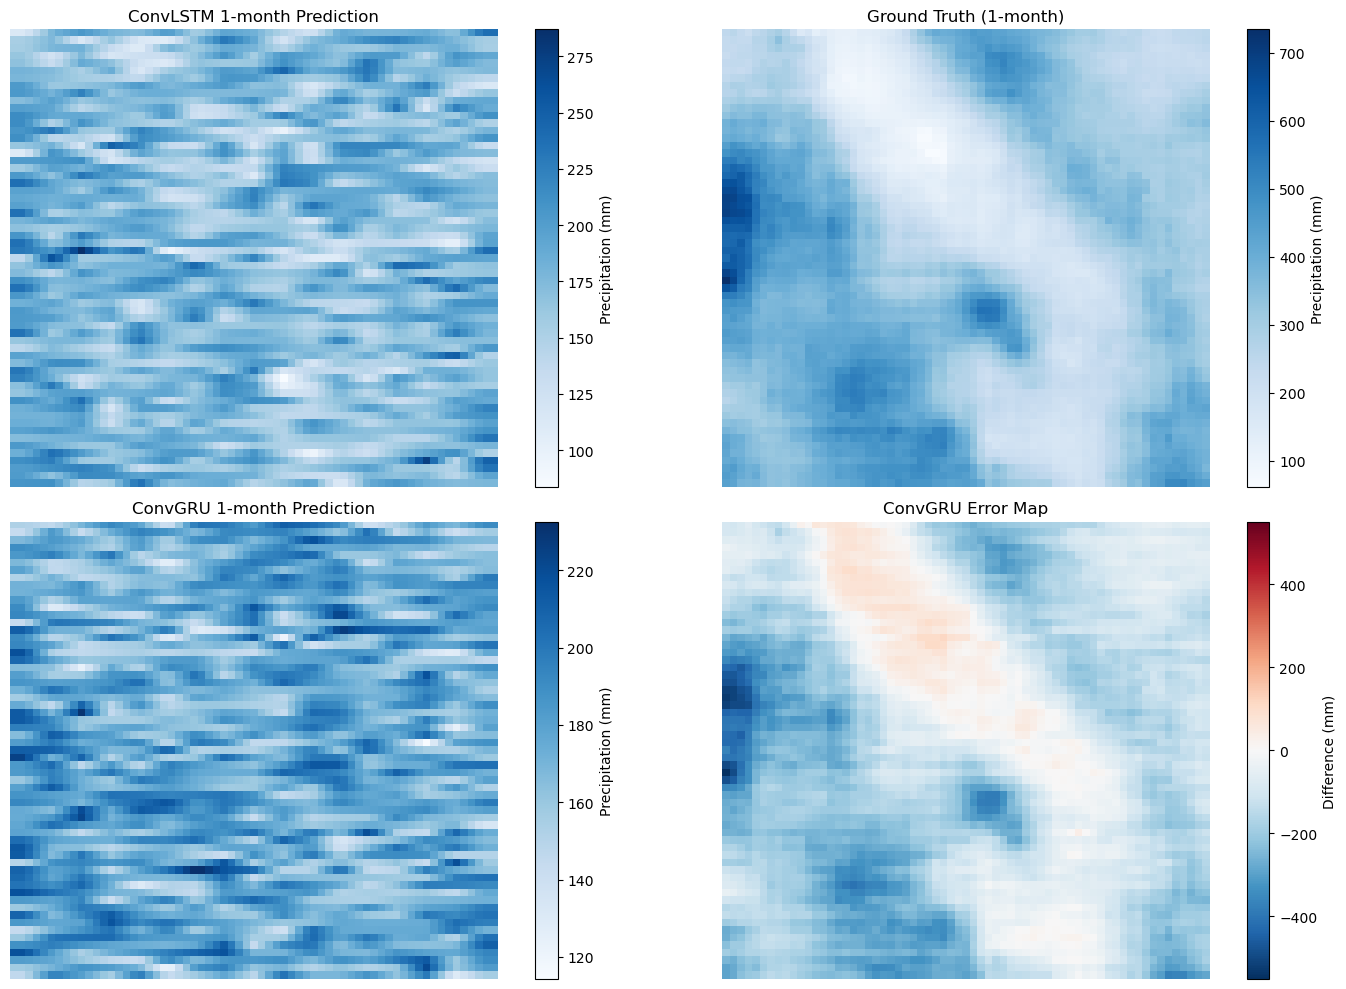

2025-06-01 18:30:43,239 - INFO - Line 18 - 
✅ Model training and evaluation completed successfully!



✅ Model training and evaluation completed successfully!


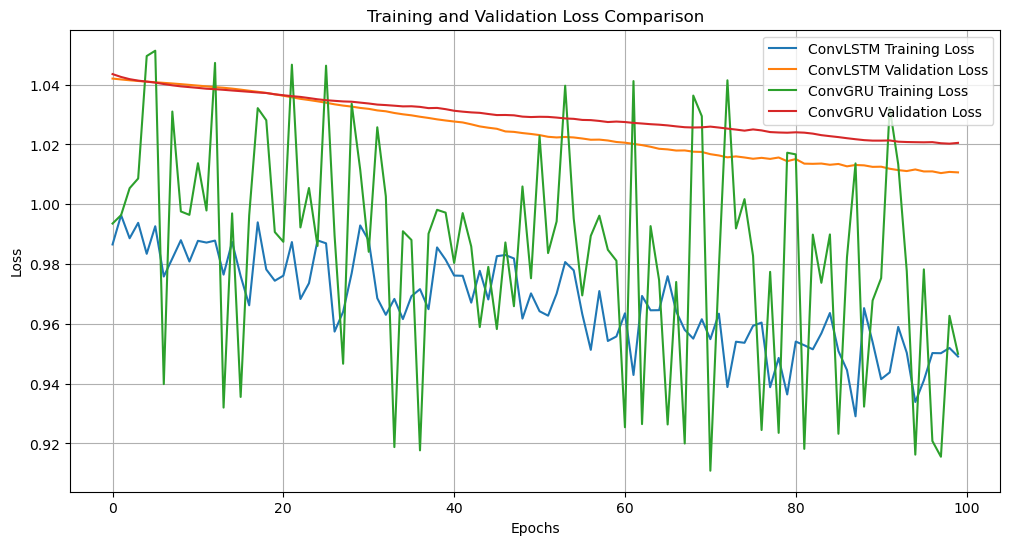

In [37]:
# Model Training Pipeline for ConvLSTM and ConvGRU with Precipitation Data
# =======================================================================

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import geopandas as gpd
from pathlib import Path
import os
import joblib

# Setting up paths for both local and Colab environments
if IN_COLAB:
    base_dir = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    if not (base_dir / 'data').exists():
        print("⚠️ Setting up Colab environment...")
        # Mount drive if not already mounted
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
else:
    base_dir = BASE_PATH  # Using already defined BASE_PATH

# Define paths
data_path = base_dir / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_with_windows.nc'
models_output_dir = base_dir / 'models' / 'output' / 'conv_models'
shape_path = base_dir / 'data' / 'input' / 'shapes' / 'MGN_Departamento.shp'

# Create output directory if it doesn't exist
models_output_dir.mkdir(exist_ok=True, parents=True)

# Load shapefile for visualization
try:
    dept_gdf = gpd.read_file(shape_path)
    log_and_print(f"✓ Shapefile loaded successfully: {shape_path}")
except Exception as e:
    log_and_print(f"⚠️ Could not load shapefile: {str(e)}")
    dept_gdf = None

# Configuration
INPUT_WINDOW = 60  # 5 years of monthly data
OUTPUT_HORIZON = 12  # 12 month forecast
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4

# Define dates for train/val/test split
TRAIN_START_DATE = pd.Timestamp('2010-01-01')  # 10 años de entrenamiento
TRAIN_END_DATE = pd.Timestamp('2019-12-31')    # Fin del entrenamiento
VAL_START_DATE = pd.Timestamp('2020-01-01')    # Inicio de validación
VAL_END_DATE = pd.Timestamp('2023-12-31')      # Fin de validación
TEST_START_DATE = pd.Timestamp('2024-01-01')   # Inicio de test/predicción
TEST_END_DATE = pd.Timestamp('2024-12-31')     # Fin de test/predicción
VAL_SPLIT = 1.0                                # Ya no necesitamos dividir el set de entrenamiento

# Feature list (from the provided code)
ALL_FEATURES = [
    'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
    'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag3',
    'total_precipitation_lag4', 'total_precipitation_lag12', 'total_precipitation_lag24', 'total_precipitation_lag36',
    'elevation', 'slope', 'aspect', 'cluster_elevation'
]

# Load dataset
log_and_print(f"Loading dataset from {data_path}")
try:
    ds = xr.open_dataset(data_path)
    
    # Verify dataset content
    log_and_print(f"Dataset dimensions: {ds.dims}")
    log_and_print(f"Dataset variables: {list(ds.data_vars)}")
    
    # Extract and display date range information
    min_date = pd.Timestamp(ds.time.min().values).strftime('%Y-%m-%d')
    max_date = pd.Timestamp(ds.time.max().values).strftime('%Y-%m-%d')
    log_and_print(f"🕒 Dataset time range: {min_date} to {max_date}")
    log_and_print(f"📊 Total time steps: {len(ds.time)}")
    
    # Check if precipitation variable is available
    if 'total_precipitation' in ds.data_vars:
        PRECIP_VAR = 'total_precipitation'
    elif 'precipitacion' in ds.data_vars:
        PRECIP_VAR = 'precipitacion'
    elif 'precip' in ds.data_vars:
        PRECIP_VAR = 'precip'
    else:
        raise ValueError("No precipitation variable found in dataset!")
    
    # Verify features are available
    available_features = [f for f in ALL_FEATURES if f in ds.data_vars]
    missing_features = [f for f in ALL_FEATURES if f not in ds.data_vars]
    
    if missing_features:
        log_and_print(f"⚠️ Missing features: {missing_features}")
        log_and_print(f"Will use available features: {available_features}")
    
    # Extract time, latitude, longitude dimensions
    times = ds.time.values
    lat_vals = ds.latitude.values
    lon_vals = ds.longitude.values
    
    log_and_print(f"✓ Dataset loaded successfully. Time period: {times[0]} to {times[-1]}")
    log_and_print(f"✓ Grid size: {len(lat_vals)}x{len(lon_vals)}")
    
except Exception as e:
    log_and_print(f"❌ Error loading dataset: {str(e)}")
    raise

# Define PyTorch models
class ConvLSTMCell(nn.Module):
    """ConvLSTM Cell implementation"""
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias
        
        # Combined gates convolution
        self.conv = nn.Conv2d(
            in_channels=self.input_channels + self.hidden_channels,
            out_channels=4 * self.hidden_channels,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias
        )
    
    def forward(self, input_tensor, hidden_state):
        h_cur, c_cur = hidden_state
        
        # Concatenate along channel axis
        combined = torch.cat([input_tensor, h_cur], dim=1)
        
        # Convolution step
        conv_output = self.conv(combined)
        
        # Split gates
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_channels, dim=1)
        
        # Apply activations
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        
        # Update cell state and output
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next
    
    def init_hidden(self, batch_size, height, width):
        return (torch.zeros(batch_size, self.hidden_channels, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_channels, height, width, device=self.conv.weight.device))

class ConvGRUCell(nn.Module):
    """ConvGRU Cell implementation"""
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvGRUCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias
        
        # Reset gate
        self.conv_reset = nn.Conv2d(
            in_channels=self.input_channels + self.hidden_channels,
            out_channels=self.hidden_channels,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias
        )
        
        # Update gate
        self.conv_update = nn.Conv2d(
            in_channels=self.input_channels + self.hidden_channels,
            out_channels=self.hidden_channels,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias
        )
        
        # Candidate activation
        self.conv_candidate = nn.Conv2d(
            in_channels=self.input_channels + self.hidden_channels,
            out_channels=self.hidden_channels,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias
        )
    
    def forward(self, input_tensor, hidden_state):
        # Concatenate along channel axis
        combined = torch.cat([input_tensor, hidden_state], dim=1)
        
        # Calculate reset and update gates
        reset_gate = torch.sigmoid(self.conv_reset(combined))
        update_gate = torch.sigmoid(self.conv_update(combined))
        
        # Calculate candidate
        reset_hidden = reset_gate * hidden_state
        combined_candidate = torch.cat([input_tensor, reset_hidden], dim=1)
        candidate = torch.tanh(self.conv_candidate(combined_candidate))
        
        # Update hidden state
        next_hidden = (1 - update_gate) * hidden_state + update_gate * candidate
        
        return next_hidden
    
    def init_hidden(self, batch_size, height, width):
        return torch.zeros(batch_size, self.hidden_channels, height, width, device=self.conv_reset.weight.device)

class ConvLSTMModel(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers, output_horizon, height, width):
        super(ConvLSTMModel, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.output_horizon = output_horizon
        self.height = height
        self.width = width
        
        # Stack of ConvLSTM cells
        self.cells = nn.ModuleList()
        for i in range(num_layers):
            in_channels = input_channels if i == 0 else hidden_channels
            self.cells.append(ConvLSTMCell(in_channels, hidden_channels, kernel_size))
        
        # Output projection
        self.output_conv = nn.Conv2d(hidden_channels, 1, kernel_size=1)
        
        # Final dense layer to produce multiple horizons - usando dimensión exacta
        self.output_linear = nn.Linear(height*width, height*width*output_horizon)
    
    def forward(self, x):
        # x shape: [batch, seq_len, channels, height, width]
        batch_size, seq_len, _, height, width = x.shape
        
        # Usar las dimensiones del input directamente
        self.height = height
        self.width = width
        
        # Initialize hidden states
        hidden_states = []
        for cell in self.cells:
            hidden_states.append(cell.init_hidden(batch_size, height, width))
        
        # Process input sequence
        for t in range(seq_len):
            x_t = x[:, t, :, :, :]
            
            for layer_idx, cell in enumerate(self.cells):
                # Pass through current cell
                if layer_idx == 0:
                    h_next, c_next = cell(x_t, hidden_states[layer_idx])
                else:
                    h_next, c_next = cell(hidden_states[layer_idx-1][0], hidden_states[layer_idx])
                
                # Update hidden state
                hidden_states[layer_idx] = (h_next, c_next)
        
        # Get final hidden state from last layer
        final_h = hidden_states[-1][0]
        
        # Project to output
        out = self.output_conv(final_h)  # [batch, 1, height, width]
        out = out.view(batch_size, -1)  # Flatten spatial dimensions
        
        # Reconstruir el output_linear si cambiaron las dimensiones
        if not hasattr(self, 'current_dims') or (self.current_dims != (height, width)):
            self.current_dims = (height, width)
            self.output_linear = nn.Linear(height*width, height*width*self.output_horizon).to(out.device)
            # Copiar pesos si es posible
            if hasattr(self, 'old_output_linear'):
                with torch.no_grad():
                    if self.output_linear.weight.shape == self.old_output_linear.weight.shape:
                        self.output_linear.weight.copy_(self.old_output_linear.weight)
                        self.output_linear.bias.copy_(self.old_output_linear.bias)
            self.old_output_linear = self.output_linear
        
        # Project to multiple horizons
        out = self.output_linear(out)
        out = out.view(batch_size, self.output_horizon, 1, height, width)
        
        # Verificar y corregir las dimensiones espaciales de salida
        expected_height = lat_vals.shape[0] if hasattr(lat_vals, 'shape') else 61  # Altura esperada (61)
        expected_width = lon_vals.shape[0] if hasattr(lon_vals, 'shape') else 65   # Anchura esperada (65)

        # Si las dimensiones no coinciden con lo esperado, redimensionar
        current_height, current_width = out.shape[-2], out.shape[-1]
        if current_height != expected_height or current_width != expected_width:
            # Aplanar para redimensionar
            out = out.view(batch_size * self.output_horizon, 1, current_height, current_width)
            # Redimensionar a las dimensiones correctas
            out = F.interpolate(out, size=(expected_height, expected_width), mode='bilinear', align_corners=False)
            # Volver a la forma original pero con dimensiones correctas
            out = out.view(batch_size, self.output_horizon, 1, expected_height, expected_width)
            
            if DEBUG_MODE:
                print(f"Redimensionado de salida: {current_height}×{current_width} → {expected_height}×{expected_width}")
                
        return out


class ConvGRUModel(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers, output_horizon, height, width):
        super(ConvGRUModel, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.output_horizon = output_horizon
        self.height = height
        self.width = width
        
        # Stack of ConvGRU cells
        self.cells = nn.ModuleList()
        for i in range(num_layers):
            in_channels = input_channels if i == 0 else hidden_channels
            self.cells.append(ConvGRUCell(in_channels, hidden_channels, kernel_size))
        
        # Output projection
        self.output_conv = nn.Conv2d(hidden_channels, 1, kernel_size=1)
        
        # Final dense layer to produce multiple horizons
        self.output_linear = nn.Linear(height*width, height*width*output_horizon)
    
    def forward(self, x):
        # x shape: [batch, seq_len, channels, height, width]
        batch_size, seq_len, _, height, width = x.shape
        
        # Usar las dimensiones del input directamente
        self.height = height
        self.width = width
        
        # Initialize hidden states
        hidden_states = []
        for cell in self.cells:
            hidden_states.append(cell.init_hidden(batch_size, height, width))
        
        # Process input sequence
        for t in range(seq_len):
            x_t = x[:, t, :, :, :]
            
            for layer_idx, cell in enumerate(self.cells):
                # Pass through current cell
                if layer_idx == 0:
                    h_next = cell(x_t, hidden_states[layer_idx])
                else:
                    h_next = cell(hidden_states[layer_idx-1], hidden_states[layer_idx])
                
                # Update hidden state
                hidden_states[layer_idx] = h_next
        
        # Get final hidden state from last layer
        final_h = hidden_states[-1]
        
        # Project to output
        out = self.output_conv(final_h)  # [batch, 1, height, width]
        out = out.view(batch_size, -1)  # Flatten spatial dimensions
        
        # Reconstruir el output_linear si cambiaron las dimensiones
        if not hasattr(self, 'current_dims') or (self.current_dims != (height, width)):
            self.current_dims = (height, width)
            self.output_linear = nn.Linear(height*width, height*width*self.output_horizon).to(out.device)
            # Copiar pesos si es posible
            if hasattr(self, 'old_output_linear'):
                with torch.no_grad():
                    if self.output_linear.weight.shape == self.old_output_linear.weight.shape:
                        self.output_linear.weight.copy_(self.old_output_linear.weight)
                        self.output_linear.bias.copy_(self.old_output_linear.bias)
            self.old_output_linear = self.output_linear
        
        # Project to multiple horizons
        out = self.output_linear(out)
        out = out.view(batch_size, self.output_horizon, 1, height, width)
        
        # Verificar y corregir las dimensiones espaciales de salida
        expected_height = lat_vals.shape[0] if hasattr(lat_vals, 'shape') else 61  # Altura esperada (61)
        expected_width = lon_vals.shape[0] if hasattr(lon_vals, 'shape') else 65   # Anchura esperada (65)

        # Si las dimensiones no coinciden con lo esperado, redimensionar
        current_height, current_width = out.shape[-2], out.shape[-1]
        if current_height != expected_height or current_width != expected_width:
            # Aplanar para redimensionar
            out = out.view(batch_size * self.output_horizon, 1, current_height, current_width)
            # Redimensionar a las dimensiones correctas
            out = F.interpolate(out, size=(expected_height, expected_width), mode='bilinear', align_corners=False)
            # Volver a la forma original pero con dimensiones correctas
            out = out.view(batch_size, self.output_horizon, 1, expected_height, expected_width)
            
            if DEBUG_MODE:
                print(f"Redimensionado de salida: {current_height}×{current_width} → {expected_height}×{expected_width}")
                
        return out

# Data preparation functions
def prepare_data_for_training():
    """Prepare data for training ConvLSTM and ConvGRU models"""
    log_and_print("Preparing data for training and testing...")
    
    # Filter out features that aren't in the dataset
    features = [f for f in ALL_FEATURES if f in ds.data_vars]
    
    # Extract arrays
    log_and_print(f"Using features: {features}")
    X_vars = ds[features].to_array().transpose("time", "latitude", "longitude", "variable").values
    y_var = ds[PRECIP_VAR].values
    
    # Debug information about the data
    log_and_print(f"X_vars shape: {X_vars.shape}, y_var shape: {y_var.shape}")
    log_and_print(f"X_vars type: {X_vars.dtype}, y_var type: {y_var.dtype}")
    
    # Safer check for NaN values that works with mixed data types
    x_nan_count = 0
    y_nan_count = 0
    
    # Check X_vars for NaNs (safely)
    try:
        if np.issubdtype(X_vars.dtype, np.number):
            x_nan_count = np.isnan(X_vars).sum()
    except TypeError:
        # If there are mixed types, count NaNs feature by feature
        x_nan_count = 0
        for i in range(X_vars.shape[-1]):
            try:
                if np.issubdtype(X_vars[..., i].dtype, np.number):
                    x_nan_count += np.isnan(X_vars[..., i]).sum()
            except (TypeError, ValueError):
                log_and_print(f"Feature {i} has non-numeric type: {X_vars[..., i].dtype}")
    
    # Check y_var for NaNs (safely)
    try:
        if np.issubdtype(y_var.dtype, np.number):
            y_nan_count = np.isnan(y_var).sum()
    except TypeError:
        log_and_print(f"Target variable has non-numeric type: {y_var.dtype}")
    
    log_and_print(f"X_vars approx NaN count: {x_nan_count}, y_var approx NaN count: {y_nan_count}")
    
    # Handle NaN values - fill with mean for X_vars and 0 for y_var
    # First, calculate means for each feature, ignoring NaN values
    feature_means = []
    for i in range(X_vars.shape[-1]):
        try:
            if np.issubdtype(X_vars[..., i].dtype, np.number):
                feature_means.append(np.nanmean(X_vars[..., i]))
            else:
                feature_means.append(0)  # Default value for non-numeric features
        except (TypeError, ValueError):
            feature_means.append(0)  # Default value for features causing errors
    
    log_and_print(f"Feature means (or default values): {feature_means}")
    
    # Fill NaN values
    for i in range(X_vars.shape[-1]):
        try:
            if np.issubdtype(X_vars[..., i].dtype, np.number):
                mask = np.isnan(X_vars[..., i])
                if mask.any():
                    X_vars[..., i][mask] = feature_means[i]
                    log_and_print(f"Filled {mask.sum()} NaN values in feature {i}")
        except (TypeError, ValueError):
            log_and_print(f"Skipping NaN filling for non-numeric feature {i}")
    
    # Fill NaN values in y_var with 0 (assuming precipitation)
    if np.issubdtype(y_var.dtype, np.number):
        y_mask = np.isnan(y_var)
        if y_mask.any():
            y_var = np.nan_to_num(y_var, nan=0.0)
            log_and_print(f"Filled {y_mask.sum()} NaN values in target variable")
    
    # Encode categorical cluster variable if present
    if 'cluster_elevation' in features:
        idx = features.index('cluster_elevation')
        le = LabelEncoder()
        
        # Get the cluster data
        flat = X_vars[..., idx].ravel()
        
        # Check data type
        if np.issubdtype(flat.dtype, np.number):
            # Handle numeric data with potential NaNs
            try:
                non_nan_mask = ~np.isnan(flat)
            except TypeError:
                # For integer types that don't support isnan
                non_nan_mask = np.ones_like(flat, dtype=bool)  # Assume no NaNs
            
            if non_nan_mask.any():
                # Only transform non-NaN values
                flat_non_nan = flat[non_nan_mask]
                encoded_values = le.fit_transform(flat_non_nan)
                
                # Put back the encoded values
                new_flat = np.full_like(flat, -1, dtype=np.int32)  # Use -1 as placeholder
                new_flat[non_nan_mask] = encoded_values
                X_vars[..., idx] = new_flat.reshape(X_vars[..., idx].shape)
            else:
                log_and_print("⚠️ All cluster values are NaN!")
        else:
            # Handle categorical/string data directly
            try:
                # Convert directly without checking for NaNs
                encoded_values = le.fit_transform(flat)
                X_vars[..., idx] = encoded_values.reshape(X_vars[..., idx].shape)
                log_and_print(f"✓ Successfully encoded {len(le.classes_)} unique cluster values")
            except Exception as e:
                log_and_print(f"⚠️ Error encoding cluster values: {str(e)}. Using zeros instead.")
                X_vars[..., idx] = np.zeros(X_vars[..., idx].shape)
    
    # Find indices for training, validation and test splits
    train_start_idx = None
    train_end_idx = None
    val_start_idx = None
    val_end_idx = None
    test_start_idx = None
    test_end_idx = None
    
    # Find the indices for our date range boundaries
    for i, t in enumerate(times):
        t_date = pd.Timestamp(t)
        if train_start_idx is None and t_date >= TRAIN_START_DATE:
            train_start_idx = i
            log_and_print(f"Training starts at index {i}: {t_date}")
        if train_end_idx is None and t_date > TRAIN_END_DATE:
            train_end_idx = i
            log_and_print(f"Training ends at index {i-1}: {pd.Timestamp(times[i-1])}")
        if val_start_idx is None and t_date >= VAL_START_DATE:
            val_start_idx = i
            log_and_print(f"Validation starts at index {i}: {t_date}")
        if val_end_idx is None and t_date > VAL_END_DATE:
            val_end_idx = i
            log_and_print(f"Validation ends at index {i-1}: {pd.Timestamp(times[i-1])}")
        if test_start_idx is None and t_date >= TEST_START_DATE:
            test_start_idx = i
            log_and_print(f"Testing starts at index {i}: {t_date}")
        if test_end_idx is None and t_date > TEST_END_DATE:
            test_end_idx = i
            log_and_print(f"Testing ends at index {i-1}: {pd.Timestamp(times[i-1])}")
            break

    # Check if we found all required indices and adjust if needed
    if train_start_idx is None:
        train_start_idx = 0
        log_and_print(f"⚠️ Train start date not found, using index 0")
    if train_end_idx is None:
        train_end_idx = len(times) // 3
        log_and_print(f"⚠️ Train end date not found, using first third: {train_end_idx}")
    if val_start_idx is None:
        val_start_idx = train_end_idx
        log_and_print(f"⚠️ Validation start date not found, using {val_start_idx}")
    if val_end_idx is None:
        val_end_idx = min(len(times) * 2 // 3, train_end_idx + (train_end_idx - train_start_idx))
        log_and_print(f"⚠️ Validation end date not found, using {val_end_idx}")
    if test_start_idx is None:
        test_start_idx = val_end_idx
        log_and_print(f"⚠️ Test start date not found, using {test_start_idx}")
    if test_end_idx is None:
        test_end_idx = min(len(times), test_start_idx + 12)  # Al menos 12 meses para test
        log_and_print(f"⚠️ Test end date not found, using {test_end_idx}")

    # Print actual date ranges based on the indices
    log_and_print(f"Actual train range: {times[train_start_idx]} to {times[train_end_idx-1]}")
    log_and_print(f"Actual validation range: {times[val_start_idx]} to {times[val_end_idx-1]}")
    log_and_print(f"Actual test range: {times[test_start_idx]} to {times[test_end_idx-1] if test_end_idx < len(times) else 'end of data'}")

    # Create sequences for training, validation and testing
    X_sequences_train = []
    y_sequences_train = []
    X_sequences_val = []
    y_sequences_val = []
    X_sequences_test = []
    y_sequences_test = []

    # For training data
    for i in range(train_start_idx, train_end_idx - INPUT_WINDOW - OUTPUT_HORIZON + 1):
        X_seq = X_vars[i:i+INPUT_WINDOW].copy()
        y_seq = y_var[i+INPUT_WINDOW:i+INPUT_WINDOW+OUTPUT_HORIZON].copy()
        X_sequences_train.append(X_seq)
        y_sequences_train.append(y_seq)

    # For validation data
    for i in range(val_start_idx, val_end_idx - INPUT_WINDOW - OUTPUT_HORIZON + 1):
        X_seq = X_vars[i:i+INPUT_WINDOW].copy()
        y_seq = y_var[i+INPUT_WINDOW:i+INPUT_WINDOW+OUTPUT_HORIZON].copy()
        X_sequences_val.append(X_seq)
        y_sequences_val.append(y_seq)

    # For test data (2024-01 to 2024-12)
    for i in range(test_start_idx, test_end_idx - INPUT_WINDOW - OUTPUT_HORIZON + 1):
        X_seq = X_vars[i:i+INPUT_WINDOW].copy()
        y_seq = y_var[i+INPUT_WINDOW:i+INPUT_WINDOW+OUTPUT_HORIZON].copy()
        X_sequences_test.append(X_seq)
        y_sequences_test.append(y_seq)
        first_date = pd.Timestamp(times[i])
        last_date = pd.Timestamp(times[i+INPUT_WINDOW+OUTPUT_HORIZON-1])
        log_and_print(f"✓ Created test sequence {len(X_sequences_test)}: input {first_date} to {pd.Timestamp(times[i+INPUT_WINDOW-1])}, output {pd.Timestamp(times[i+INPUT_WINDOW])} to {last_date}")
    
    # Convert to numpy arrays
    X_train = np.stack(X_sequences_train) if X_sequences_train else np.array([])
    y_train = np.stack(y_sequences_train) if y_sequences_train else np.array([])
    X_val = np.stack(X_sequences_val) if X_sequences_val else np.array([])
    y_val = np.stack(y_sequences_val) if y_sequences_val else np.array([])
    X_test = np.stack(X_sequences_test) if X_sequences_test else np.array([])
    y_test = np.stack(y_sequences_test) if y_sequences_test else np.array([])
    
    log_and_print(f"Training sequences: {len(X_train)}, Validation sequences: {len(X_val)}, Test sequences: {len(X_test)}")
    
    # Make sure we have at least some data
    if len(X_train) == 0 and len(X_val) == 0:
        log_and_print("❌ CRITICAL ERROR: No valid sequences found. Trying alternative approach...")
        # Last resort: Just create some sequences from the first available data
        X_sequences_all = []
        y_sequences_all = []
        for i in range(len(times) - INPUT_WINDOW - OUTPUT_HORIZON):
            X_seq = X_vars[i:i+INPUT_WINDOW].copy()
            y_seq = y_var[i+INPUT_WINDOW:i+INPUT_WINDOW+OUTPUT_HORIZON].copy()
            X_sequences_all.append(X_seq)
            y_sequences_all.append(y_seq)
        
        # Split data 80-20
        num_samples = len(X_sequences_all)
        train_size = int(0.8 * num_samples)
        
        X_train = np.stack(X_sequences_all[:train_size])
        y_train = np.stack(y_sequences_all[:train_size])
        X_val = np.stack(X_sequences_all[train_size:])
        y_val = np.stack(y_sequences_all[train_size:])
        
        log_and_print(f"Created {len(X_train)} training and {len(X_val)} validation sequences using alternative approach")
    
    # Standardize data (fit on train, apply to all)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Reshape to 2D for scaling
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    y_train_flat = y_train.reshape(-1, 1)
    
    # Fit and transform
    X_train_flat = scaler_X.fit_transform(X_train_flat)
    y_train_flat = scaler_y.fit_transform(y_train_flat)
    
    # Reshape back
    X_train = X_train_flat.reshape(X_train.shape)
    y_train = y_train_flat.reshape(y_train.shape)
    
    # Transform validation data
    if len(X_val) > 0:
        X_val_flat = X_val.reshape(-1, X_val.shape[-1])
        y_val_flat = y_val.reshape(-1, 1)
        X_val_flat = scaler_X.transform(X_val_flat)
        y_val_flat = scaler_y.transform(y_val_flat)
        X_val = X_val_flat.reshape(X_val.shape)
        y_val = y_val_flat.reshape(y_val.shape)
    
    # Transform test data
    if len(X_test) > 0:
        X_test_flat = X_test.reshape(-1, X_test.shape[-1])
        y_test_flat = y_test.reshape(-1, 1)
        X_test_flat = scaler_X.transform(X_test_flat)
        y_test_flat = scaler_y.transform(y_test_flat)
        X_test = X_test_flat.reshape(X_test.shape)
        y_test = y_test_flat.reshape(y_test.shape)
    
    # Verificar y transformar los arrays de manera segura
    log_and_print(f"Checking array shapes before transformation:")
    log_and_print(f"y_train shape: {y_train.shape}")
    log_and_print(f"y_val shape: {y_val.shape}")
    log_and_print(f"y_test shape: {y_test.shape if len(y_test) > 0 else 'empty'}")
    
    # Transformación segura de y_train
    if len(y_train) > 0:
        if len(y_train.shape) == 1:  # Array 1D
            y_train = y_train.reshape(-1, 1, 1, 1, 1)
            log_and_print(f"Reshaped 1D y_train to 5D: {y_train.shape}")
        elif len(y_train.shape) == 2:  # [batch, features]
            y_train = y_train.reshape(y_train.shape[0], 1, 1, 1, -1)
            log_and_print(f"Reshaped 2D y_train to 5D: {y_train.shape}")
        elif len(y_train.shape) == 3:  # [batch, seq, features] or [batch, height, width]
            if y_train.shape[1] == OUTPUT_HORIZON:
                y_train = y_train[:, :, np.newaxis]  # Add channel dim
            else:
                y_train = y_train[:, np.newaxis, np.newaxis, :, :]
        elif len(y_train.shape) == 4:  # [batch, seq, height, width]
            y_train = y_train[:, :, np.newaxis, :, :]  # Add channel dim
    
    # Transformación segura de y_val
    if len(y_val) > 0:
        if len(y_val.shape) == 1:  # Array 1D
            y_val = y_val.reshape(-1, 1, 1, 1, 1)
            log_and_print(f"Reshaped 1D y_val to 5D: {y_val.shape}")
        elif len(y_val.shape) == 2:  # [batch, features]
            y_val = y_val.reshape(y_val.shape[0], 1, 1, 1, -1)
            log_and_print(f"Reshaped 2D y_val to 5D: {y_val.shape}")
        elif len(y_val.shape) == 3:  # [batch, seq, features] or [batch, height, width]
            if y_val.shape[1] == OUTPUT_HORIZON:
                y_val = y_val[:, :, np.newaxis]  # Add channel dim
            else:
                y_val = y_val[:, np.newaxis, np.newaxis, :, :]
        elif len(y_val.shape) == 4:  # [batch, seq, height, width]
            y_val = y_val[:, :, np.newaxis, :, :]  # Add channel dim
    
    # Transformación segura de y_test
    if len(y_test) > 0:
        if len(y_test.shape) == 1:  # Array 1D
            y_test = y_test.reshape(-1, 1, 1, 1, 1)
            log_and_print(f"Reshaped 1D y_test to 5D: {y_test.shape}")
        elif len(y_test.shape) == 2:  # [batch, features]
            y_test = y_test.reshape(y_test.shape[0], 1, 1, 1, -1)
            log_and_print(f"Reshaped 2D y_test to 5D: {y_test.shape}")
        elif len(y_test.shape) == 3:  # [batch, seq, features] or [batch, height, width]
            if y_test.shape[1] == OUTPUT_HORIZON:
                y_test = y_test[:, :, np.newaxis]  # Add channel dim
            else:
                y_test = y_test[:, np.newaxis, np.newaxis, :, :]
        elif len(y_test.shape) == 4:  # [batch, seq, height, width]
            y_test = y_test[:, :, np.newaxis, :, :]  # Add channel dim
    
    log_and_print(f"Final shapes after transformation:")
    log_and_print(f"y_train: {y_train.shape}")
    log_and_print(f"y_val: {y_val.shape}")
    log_and_print(f"y_test: {y_test.shape if len(y_test) > 0 else 'empty'}")
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test) if len(X_test) > 0 else None
    y_test_tensor = torch.FloatTensor(y_test) if len(y_test) > 0 else None
    
    # Create dataset objects and data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor) if X_test_tensor is not None else None
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) if test_dataset is not None else None
    
    # Verificar que los cargadores tengan datos
    log_and_print(f"Verificando cargadores de datos:")
    log_and_print(f"- Train loader: {len(train_loader)} lotes ({len(train_dataset)} muestras)")
    log_and_print(f"- Validation loader: {len(val_loader)} lotes ({len(val_dataset)} muestras)")
    if test_loader:
        log_and_print(f"- Test loader: {len(test_loader)} lotes ({len(test_dataset)} muestras)")
    else:
        log_and_print(f"- Test loader: No disponible")
    
    # Si el cargador de validación está vacío, mostrar advertencia
    if len(val_loader) == 0:
        log_and_print("⚠️ ADVERTENCIA: El cargador de validación está vacío.")
        log_and_print(f"Rango de validación: {VAL_START_DATE} a {VAL_END_DATE}")
    
    # Save the scalers for future use
    joblib.dump(scaler_X, models_output_dir / 'scaler_X.joblib')
    joblib.dump(scaler_y, models_output_dir / 'scaler_y.joblib')
    log_and_print(f"✓ Saved scalers to {models_output_dir}")
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'train_shape': X_train.shape,
        'val_shape': X_val.shape if len(X_val) > 0 else None,
        'test_shape': X_test.shape if len(X_test) > 0 else None,
        'features': features,
        'test_dates': times[test_start_idx:test_start_idx+OUTPUT_HORIZON] if len(X_test) > 0 else None
    }

# Training function
def train_model(model_type, data_dict):
    """Train either ConvLSTM or ConvGRU model"""
    train_loader = data_dict['train_loader']
    val_loader = data_dict['val_loader']
    train_shape = data_dict['train_shape']
    features = data_dict['features']
    
    # Verificar si el cargador de validación está vacío
    if len(val_loader) == 0:
        log_and_print("⚠️ ADVERTENCIA: El cargador de validación está vacío. Usando un subset del entrenamiento para validación.")
        # Crear un pequeño subconjunto del conjunto de entrenamiento para validación
        train_dataset = train_loader.dataset
        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        
        if val_size > 0:
            train_subset, val_subset = torch.utils.data.random_split(
                train_dataset, [train_size, val_size]
            )
            # Recrear cargadores de datos
            train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
            data_dict['val_loader'] = val_loader
            log_and_print(f"✓ Creado conjunto de validación con {val_size} muestras del conjunto de entrenamiento")
        else:
            log_and_print("❌ No hay suficientes datos para crear un conjunto de validación.")
            # Establecer un valor predeterminado alto para la pérdida de validación
            val_loader = None
    
    # Debug information about train_shape to diagnose the issue
    log_and_print(f"Train shape: {train_shape}")
    
    # More robust way to extract dimensions
    try:
        # Try standard unpacking first
        batch_size, seq_len, feature_dim, height, width = train_shape
        log_and_print(f"Successfully unpacked dimensions: seq_len={seq_len}, feature_dim={feature_dim}, height={height}, width={width}")
    except ValueError as e:
        # If unpacking fails, extract dimensions more carefully
        log_and_print(f"Error unpacking dimensions: {e}")
        log_and_print(f"Using safer approach to extract dimensions...")
        
        batch_size = train_shape[0] if len(train_shape) > 0 else 1
        seq_len = train_shape[1] if len(train_shape) > 1 else INPUT_WINDOW
        feature_dim = train_shape[2] if len(train_shape) > 2 else len(features)
        
        # For height and width, first check if we have enough dimensions
        if len(train_shape) > 3:
            height = train_shape[3]
        else:
            height = lat_vals.shape[0] if 'lat_vals' in globals() else 61  # Default value
            log_and_print(f"Using default height: {height}")
        
        if len(train_shape) > 4:
            width = train_shape[4]
        else:
            width = lon_vals.shape[0] if 'lon_vals' in globals() else 65  # Default value
            log_and_print(f"Using default width: {width}")
    
    # Create model based on specified type
    if model_type == 'ConvLSTM':
        model = ConvLSTMModel(
            input_channels=feature_dim,
            hidden_channels=32,
            kernel_size=3,
            num_layers=2,
            output_horizon=OUTPUT_HORIZON,
            height=height,
            width=width
        )
        model_name = "ConvLSTM"
    else:
        model = ConvGRUModel(
            input_channels=feature_dim,
            hidden_channels=32,
            kernel_size=3,
            num_layers=2,
            output_horizon=OUTPUT_HORIZON,
            height=height,
            width=width
        )
        model_name = "ConvGRU"
    
    model = model.to(DEVICE)
    log_and_print(f"Created {model_name} model with input shape: [{batch_size}, {seq_len}, {feature_dim}, {height}, {width}]")
    
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    
    # Training variables
    best_val_loss = float('inf')
    best_model = None
    train_losses = []
    val_losses = []
    epochs_no_improve = 0
    PATIENCE = 10  # Early stopping patience
    
    # Training loop
    log_and_print(f"Starting {model_name} training for {EPOCHS} epochs")
    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        epoch_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Verificar dimensiones y adaptar si es necesario
            if outputs.shape != targets.shape:
                log_and_print(f"⚠️ Dimension mismatch: outputs {outputs.shape} vs targets {targets.shape}")
                
                # Si las dimensiones espaciales no coinciden, redimensionar targets o outputs según sea necesario
                if outputs.shape[-2:] != targets.shape[-2:]:
                    # Determinar qué dimensiones son correctas basadas en los datos del dataset
                    correct_height = lat_vals.shape[0] if hasattr(lat_vals, 'shape') else 61
                    correct_width = lon_vals.shape[0] if hasattr(lon_vals, 'shape') else 65
                    
                    # Si las dimensiones del target son las correctas, redimensionar outputs
                    if targets.shape[-2] == correct_height and targets.shape[-1] == correct_width:
                        log_and_print(f"Reshaping outputs to match target dimensions")
                        outputs_reshaped = F.interpolate(
                            outputs.view(-1, 1, outputs.shape[-2], outputs.shape[-1]),
                            size=targets.shape[-2:], 
                            mode='bilinear',
                            align_corners=False
                        )
                        outputs = outputs_reshaped.view(
                            outputs.shape[0], 
                            outputs.shape[1],
                            outputs.shape[2],
                            targets.shape[-2],
                            targets.shape[-1]
                        )
                    # Si las dimensiones del output son las correctas, redimensionar targets
                    else:
                        log_and_print(f"Reshaping targets to match output dimensions")
                        targets_reshaped = F.interpolate(
                            targets.view(-1, 1, targets.shape[-2], targets.shape[-1]),
                            size=outputs.shape[-2:], 
                            mode='bilinear',
                            align_corners=False
                        )
                        targets = targets_reshaped.view(
                            targets.shape[0],
                            targets.shape[1],
                            targets.shape[2],
                            outputs.shape[-2],
                            outputs.shape[-1]
                        )
                    
                    log_and_print(f"New shapes - outputs: {outputs.shape}, targets: {targets.shape}")
            
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Print progress for every 20% of batches
            if (batch_idx + 1) % max(1, len(train_loader) // 5) == 0:
                log_and_print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.6f}")
        
        # Calculate average training loss
        avg_train_loss = epoch_loss / len(train_loader) if len(train_loader) > 0 else float('inf')
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        # Verificar si hay un cargador de validación disponible
        if val_loader is not None and len(val_loader) > 0:
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs = inputs.to(DEVICE)
                    targets = targets.to(DEVICE)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
        else:
            # Si no hay datos de validación, usar la pérdida de entrenamiento o un valor alto
            log_and_print("⚠️ No hay datos de validación disponibles, usando pérdida de entrenamiento")
            avg_val_loss = avg_train_loss * 1.2  # Penalizar un poco
        
        val_losses.append(avg_val_loss)
        
        # Print epoch summary
        log_and_print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict().copy()
            epochs_no_improve = 0
            
            # Save best model checkpoint
            model_path = models_output_dir / f"{model_name}_best.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
                'features': features
            }, model_path)
            log_and_print(f"New best model saved! (Val Loss: {best_val_loss:.6f})")
        else:
            epochs_no_improve += 1
        
        # Early stopping
        if epochs_no_improve >= PATIENCE:
            log_and_print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    # Load best model for evaluation
    if best_model is not None:
        model.load_state_dict(best_model)
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} Training Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(models_output_dir / f"{model_name}_training_curve.png")
    plt.close()
    
    # Save final model (in addition to the best model already saved)
    final_model_path = models_output_dir / f"{model_name}_final.pt"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_val_loss,
        'features': features,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }, final_model_path)
    log_and_print(f"Final model saved to {final_model_path}")
    
    return model, data_dict['scaler_y'], train_losses, val_losses, best_val_loss

# Evaluation function
def evaluate_model(model, val_loader, scaler_y):
    """Evaluate model performance on validation data"""
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            
            # Move to CPU for evaluation
            outputs = outputs.cpu().numpy()
            targets = targets.numpy()
            
            all_predictions.append(outputs)
            all_targets.append(targets)
    
    # Concatenate all batches
    all_targets = np.concatenate(all_targets, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    
    # Save original shape for proper reshaping later
    orig_shape = all_targets.shape
    
    # Reshape to 2D for inverse scaling - preserving batch size
    all_targets_flat = all_targets.reshape(-1, 1)
    all_predictions_flat = all_predictions.reshape(-1, 1)
    
    # Inverse transform
    all_targets_unscaled = scaler_y.inverse_transform(all_targets_flat)
    all_predictions_unscaled = scaler_y.inverse_transform(all_predictions_flat)
    
    # Reshape back to original shape
    all_targets_original = all_targets_unscaled.reshape(orig_shape)
    all_predictions_original = all_predictions_unscaled.reshape(orig_shape)
    
    # Calculate metrics for each horizon
    metrics_dict = {}
    for h in range(OUTPUT_HORIZON):
        # Check dimensions before indexing
        if len(all_targets_original.shape) >= 2:
            target_h = all_targets_original[:, h].flatten() if h < all_targets_original.shape[1] else all_targets_original.flatten()
            pred_h = all_predictions_original[:, h].flatten() if h < all_predictions_original.shape[1] else all_predictions_original.flatten()
        else:
            # Handle 1D arrays (unlikely but safe)
            target_h = all_targets_original.flatten()
            pred_h = all_predictions_original.flatten()
            log_and_print(f"Warning: Metrics calculated on flattened data, shape={all_targets_original.shape}")
        
        rmse = np.sqrt(mean_squared_error(target_h, pred_h))
        mae = mean_absolute_error(target_h, pred_h)
        r2 = r2_score(target_h, pred_h)
        
        metrics_dict[h+1] = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }
    
    log_and_print(f"Evaluation complete. Metrics: {metrics_dict}")
    return metrics_dict, all_targets_original, all_predictions_original

# Main execution
def train_precipitation_models():
    # 1) Prepare data
    log_and_print("\n" + "="*60)
    log_and_print("PREPARING DATA")
    log_and_print("="*60)
    data_dict = prepare_data_for_training()
    
    # 2) Train and evaluate ConvLSTM model
    log_and_print("\n" + "="*60)
    log_and_print("TRAINING ConvLSTM MODEL")
    log_and_print("="*60)
    convlstm_model, y_scaler, lstm_train_losses, lstm_val_losses, lstm_best_val = train_model('ConvLSTM', data_dict)
    log_and_print(f"ConvLSTM best validation loss: {lstm_best_val:.6f}")
    
    # Evaluate ConvLSTM on validation set
    log_and_print("\n" + "="*60)
    log_and_print("ConvLSTM VALIDATION EVALUATION")
    log_and_print("="*60)
    convlstm_metrics, convlstm_targets, convlstm_preds = evaluate_model(
        convlstm_model, data_dict['val_loader'], y_scaler
    )
    
    for horizon, metrics in convlstm_metrics.items():
        log_and_print(f"Horizon {horizon} month(s): RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R²={metrics['R2']:.4f}")
    
    # 3) Train and evaluate ConvGRU model
    log_and_print("\n" + "="*60)
    log_and_print("TRAINING ConvGRU MODEL")
    log_and_print("="*60)
    convgru_model, y_scaler, gru_train_losses, gru_val_losses, gru_best_val = train_model('ConvGRU', data_dict)
    log_and_print(f"ConvGRU best validation loss: {gru_best_val:.6f}")
    
    # Evaluate ConvGRU on validation set
    log_and_print("\n" + "="*60)
    log_and_print("ConvGRU VALIDATION EVALUATION")
    log_and_print("="*60)
    convgru_metrics, convgru_targets, convgru_preds = evaluate_model(
        convgru_model, data_dict['val_loader'], y_scaler
    )
    
    for horizon, metrics in convgru_metrics.items():
        log_and_print(f"Horizon {horizon} month(s): RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R²={metrics['R2']:.4f}")
    
    # 4) Compare validation metrics between models
    log_and_print("\n" + "="*60)
    log_and_print("MODEL COMPARISON (VALIDATION)")
    log_and_print("="*60)
    
    comparison_table = []
    for h in range(1, OUTPUT_HORIZON+1):
        comparison_table.append({
            'Horizon': h,
            'ConvLSTM RMSE': convlstm_metrics[h]['RMSE'],
            'ConvGRU RMSE': convgru_metrics[h]['RMSE'],
            'Diff (%)': (convgru_metrics[h]['RMSE'] - convlstm_metrics[h]['RMSE'])/convlstm_metrics[h]['RMSE']*100
        })
    
    # Display as table
    import pandas as pd
    comparison_df = pd.DataFrame(comparison_table)
    log_and_print("\nModel comparison by horizon (RMSE):")
    print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    
    # 5) Visualize predictions
    log_and_print("\n" + "="*60)
    log_and_print("VISUALIZING PREDICTIONS")
    log_and_print("="*60)
    
    # Plot sample validation predictions
    plt.figure(figsize=(15, 10))

    # Plot for ConvLSTM prediction
    plt.subplot(2, 2, 1)
    sample_idx = 0  # First sample
    horizon_idx = 0  # First horizon (1-month)

    pred_map = convlstm_preds[sample_idx, horizon_idx, 0]
    true_map = convlstm_targets[sample_idx, horizon_idx, 0]
    
    # Create a difference map and actually use it
    diff_map = pred_map - true_map

    # Plot prediction
    plt.imshow(pred_map, cmap='Blues')
    plt.colorbar(label='Precipitation (mm)')
    plt.title(f'ConvLSTM 1-month Prediction')
    plt.axis('off')

    # Plot ground truth
    plt.subplot(2, 2, 2)
    plt.imshow(true_map, cmap='Blues')
    plt.colorbar(label='Precipitation (mm)')
    plt.title(f'Ground Truth (1-month)')
    plt.axis('off')

    # Plot for ConvGRU prediction
    plt.subplot(2, 2, 3)
    pred_map_gru = convgru_preds[sample_idx, horizon_idx, 0]
    
    # Plot prediction
    plt.imshow(pred_map_gru, cmap='Blues')
    plt.colorbar(label='Precipitation (mm)')
    plt.title(f'ConvGRU 1-month Prediction')
    plt.axis('off')

    # Plot difference map (errors)
    plt.subplot(2, 2, 4)
    diff_map_gru = pred_map_gru - true_map
    plt.imshow(diff_map_gru, cmap='RdBu_r', vmin=-np.abs(diff_map_gru).max(), vmax=np.abs(diff_map_gru).max())
    plt.colorbar(label='Difference (mm)')
    plt.title(f'ConvGRU Error Map')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(models_output_dir / "validation_predictions_comparison.png")
    plt.show()
    
    # 6) Test on future data if available
    if data_dict['test_loader'] is not None:
        log_and_print("\n" + "="*60)
        log_and_print(f"EVALUATING ON TEST DATA (2024)")
        log_and_print("="*60)
        
        # Test ConvLSTM
        convlstm_test_metrics, convlstm_test_targets, convlstm_test_preds = evaluate_model(
            convlstm_model, data_dict['test_loader'], y_scaler
        )
        
        log_and_print("\nConvLSTM TEST METRICS:")
        for horizon, metrics in convlstm_test_metrics.items():
            date = data_dict['test_dates'][horizon-1] if horizon-1 < len(data_dict['test_dates']) else "Unknown"
            log_and_print(f"Horizon {horizon} ({date}): RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R²={metrics['R2']:.4f}")
        
        # Test ConvGRU
        convgru_test_metrics, convgru_test_targets, convgru_test_preds = evaluate_model(
            convgru_model, data_dict['test_loader'], y_scaler
        )
        
        log_and_print("\nConvGRU TEST METRICS:")
        for horizon, metrics in convgru_test_metrics.items():
            date = data_dict['test_dates'][horizon-1] if horizon-1 < len(data_dict['test_dates']) else "Unknown"
            log_and_print(f"Horizon {horizon} ({date}): RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R²={metrics['R2']:.4f}")
    
    log_and_print("\n✅ Model training and evaluation completed successfully!")
    
    return {
        'convlstm_model': convlstm_model,
        'convgru_model': convgru_model,
        'convlstm_metrics': convlstm_metrics,
        'convgru_metrics': convgru_metrics,
        'y_scaler': y_scaler,
        'train_losses': {
            'lstm': lstm_train_losses,
            'gru': gru_train_losses
        },
        'val_losses': {
            'lstm': lstm_val_losses,
            'gru': gru_val_losses
        },
        'best_val_loss': {
            'lstm': lstm_best_val,
            'gru': gru_best_val
        },
        'models_path': str(models_output_dir / "precipitation_models_ensemble.pt"),
    }

# Execute training now instead of just defining the functions
if __name__ == "__main__" or 'get_ipython' in globals():
    log_and_print("\n" + "="*80)
    log_and_print("STARTING PRECIPITATION MODEL TRAINING")
    log_and_print("="*80)
    
    # Actually execute the training and store results
    results = train_precipitation_models()
    
    # Plot comparison of training curves
    plt.figure(figsize=(12, 6))
    plt.plot(results['train_losses']['lstm'], label='ConvLSTM Training Loss')
    plt.plot(results['val_losses']['lstm'], label='ConvLSTM Validation Loss')
    plt.plot(results['train_losses']['gru'], label='ConvGRU Training Loss')
    plt.plot(results['val_losses']['gru'], label='ConvGRU Validation Loss')
    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(models_output_dir / "training_validation_loss_comparison.png")
    plt.show()